In [19]:
from rdkit import Chem, RDLogger, Geometry
from rdkit.Chem import AllChem, PandasTools, SaltRemover, Draw
import pandas as pd

def add_nitrogen_charges(mol):
    RDLogger.DisableLog('rdApp.*')
    mol.UpdatePropertyCache(strict=False)
    ps = Chem.DetectChemistryProblems(mol)
    if not ps:
        Chem.SanitizeMol(mol)
        return mol
    for p in ps:
        if p.GetType()=='AtomValenceException':
            at = mol.GetAtomWithIdx(p.GetAtomIdx())
            if at.GetAtomicNum()==7: # and at.GetFormalCharge()==0 and at.GetExplicitValence()==4:
                at.SetFormalCharge(1)
    Chem.SanitizeMol(mol)
    RDLogger.EnableLog('rdApp.*')
    return mol

with Chem.SDMolSupplier('/Users/user/Coding/library_exploration/Enamine-FullCatalogue_EUR.sdf', sanitize=False) as sdfh:
    bbs = pd.DataFrame([{'mol': mol, 
                        'Price_EUR_100mg': mol.GetDoubleProp('Price_EUR_100mg'),
                        'Class': mol.GetProp('Class'),
                        'Subclass': mol.GetProp('Subclass'),
                        } for mol in sdfh if mol.HasProp('Price_EUR_100mg')])
    
for mol in bbs.mol:
    try:
        add_nitrogen_charges(mol)
    except Exception as error:
        pass

[15:56:31] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 69 ignored


In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
from IPython.display import display
from rdkit.Chem.Draw import SimilarityMaps

with Chem.SDMolSupplier('../A71EV2A/A71EV2A_combined.sdf') as sdfh:
    hits = list(sdfh)

In [7]:
import re

for hit in hits:
    original = hit.GetProp('_Name')
    name = re.match(r'\w+-(x\d+)', original).group(1)
    hit.SetProp('id', original)
    hit.SetProp('_Name', name)

In [9]:
from gist_import import GistImporter
from types import ModuleType
from typing import List
from rdkit import Chem

url = 'https://raw.githubusercontent.com/matteoferla/Fragment-hit-follow-up-chemistry/main/fragment_elaboration_scripts/fragment.py'
frag: ModuleType = GistImporter.from_github(url).to_module()

fhits = []
for hit in hits:
    fhits.extend(frag.fragment(hit))

In [21]:
import numpy as np
good_refs = [np.array([10.267,  12.571,  22.645]), 
             np.array([14.058, 12.954, 24.799]),
             np.array([8.631,  15.149,  21.624])
            ]
bad_refs = [np.array([9.635,   9.373,  23.162]), np.array([7.731,  11.707,  25.211])]
fluff = []
for hit in fhits:
    conf: Chem.Conformer = hit.GetConformer()
    pos: np.array = conf.GetPositions()
    for ref in bad_refs:
        if np.linalg.norm(pos - ref, axis=1).min() > 2:
            break
    else:
        continue
    for ref in good_refs:
        if np.linalg.norm(pos - ref, axis=1).min() < 2:
            break
    else:
        continue
    fluff.append(hit)

with Chem.SDWriter('not-pocket.sdf') as sdfh:
    for hit in fluff:
        sdfh.write(hit)
        
len(fluff)

35

cmd.pseudoatom('carbonyl_sphere', pos=[10.267,  12.571,  22.645], vdw=1.0); cmd.show('spheres', 'carbonyl_sphere')
cmd.pseudoatom('pocket_sphere', pos=[7.731,  11.707,  25.211], vdw=1.0); cmd.show('spheres', 'pocket_sphere')

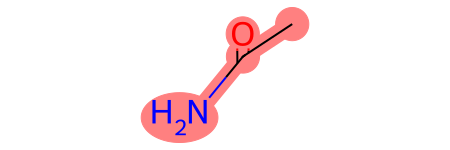

In [69]:
amide = fluff[1]
amide

In [70]:
from fragmenstein import Monster

acylchloro = AllChem.RemoveAllHs(Monster([amide]).place_smiles('C(=O)Cl').positioned_mol)
carboxylic_acid = AllChem.RemoveAllHs(Monster([amide]).place_smiles('C(=O)[O-]').positioned_mol)

In [73]:
from openbabel import openbabel as ob

def rdkit_to_mol2(mol):
    obmol = ob.OBMol()
    conv = ob.OBConversion()
    conv.SetInFormat("mol")
    # desalt the crude way:
    conv.ReadString(obmol, Chem.MolToMolBlock(mol))
    #obmol.PerceiveBondOrders()  # commented out as I am using SMILES not PDB
    #ob.OBBuilder().Build(obmol)
    conv.SetOutFormat("mol2")
    obmol.SetTitle( name )
    set_pdb_info(obmol)
    return conv.WriteString(obmol)

Path('amide.mol2').write_text(rdkit_to_mol2(amide))
Path('acylchloro.mol2').write_text(rdkit_to_mol2(acylchloro))
Path('carboxylic_acid.mol2').write_text(rdkit_to_mol2(carboxylic_acid))

398

In [42]:
from rdkit.Chem import Descriptors

acylx = Chem.MolFromSmarts('C(=O)[Cl,Br,OH1,O-]')
bbs['wanted'] = bbs.mol.apply(lambda mol: mol.HasSubstructMatch(acylx))
amino = Chem.MolFromSmarts('[NH2X3,NH3X4+]')
bbs['unwanted'] = bbs.mol.apply(lambda mol: mol.HasSubstructMatch(amino))

In [51]:
def is_good(mol):
    if Descriptors.ExactMolWt(mol) > 200:
        return False
    if Descriptors.NumRotatableBonds(mol) > 3:
        return False
    if Descriptors.NumHAcceptors(mol) + Descriptors.NumHDonors(mol) <= 2:
        return False
    return True

bbs['good'] = bbs.mol.apply(is_good)

In [58]:
wanted_bbs = bbs.loc[bbs.good & bbs.wanted & ~bbs.unwanted & (bbs.Price_EUR_100mg < 200)]\
             .sort_values('Price_EUR_100mg')\
             .mol.to_list()
with Chem.SDWriter('EnamineBB_carbo.sdf') as sdfh:
    for bb in wanted_bbs:
        sdfh.write(bb)

In [416]:
len(bbs), len(wanted_bbs)

(303087, 5003)

In [63]:
from pathlib import Path
from openbabel import openbabel as ob

def smiles_to_mol2block_bonds_pH(smiles, name: str, pH: float=7.4) -> str:
    obmol = ob.OBMol()
    conv = ob.OBConversion()
    conv.SetInFormat("smi")
    # desalt the crude way:
    conv.ReadString(obmol, max(smiles.split('.'), key=len))
    #obmol.PerceiveBondOrders()  # commented out as I am using SMILES not PDB
    obmol.CorrectForPH(pH)
    obmol.AddHydrogens()
    ob.OBBuilder().Build(obmol)
    conv.SetOutFormat("mol2")
    obmol.SetTitle( name )
    set_pdb_info(obmol)
    return conv.WriteString(obmol)

def set_pdb_info(obmol, resn='LIG', chain='X'):
    residue = ob.OBResidue()
    assert obmol.AddResidue(residue)
    for i, atom in enumerate(ob.OBMolAtomIter(obmol)):
        #residue = atom.GetResidue()
        residue.AddAtom(atom)
        residue.SetName(resn)
        residue.SetNum(1)
        residue.SetChain(chain)
        #atom.SetResidue(residue)
        residue.SetHetAtom(atom, True)

mol2_path = Path('bb.mol2')
mol2_path.parent.mkdir(parents=True, exist_ok=True)
with mol2_path.open('w') as f:
    for bb in wanted_bbs:
        molblock = smiles_to_mol2block_bonds_pH(Chem.MolToSmiles(bb), bb.GetProp('ID'))
        f.write(molblock + "\n")

In [97]:
from rdkit.Chem import PandasTools

df = PandasTools.LoadSDF('docked/docked_bb.sdf', molColName='mol', idName='ID') 

In [98]:
import numpy as np
good_refs = [np.array([10.267,  12.571,  22.645]), 
             np.array([14.058, 12.954, 24.799]),
             np.array([8.631,  15.149,  21.624])
            ]
bad_refs = [np.array([9.635,   9.373,  23.162]), np.array([7.731,  11.707,  25.211])]

def assign(mol, cutoff=2):
    conf: Chem.Conformer = mol.GetConformer()
    pos: np.array = conf.GetPositions()
    for i, ref in enumerate(bad_refs):
        if np.linalg.norm(pos - ref, axis=1).min() < cutoff:
            return f'bad_#{i}'
    for ref in good_refs:
        if np.linalg.norm(pos - ref, axis=1).min() < cutoff:
            return 'good'
    else:
        return 'elsewhere'
    
df['verdict'] = df.mol.apply(assign)
df['verdict'].value_counts()

verdict
good         19809
bad_#0       15042
bad_#1        4425
elsewhere      184
Name: count, dtype: int64

In [120]:
df['Gold.Goldscore.Fitness'] = df['Gold.Goldscore.Fitness'].astype(float)
cutoff = df['Gold.Goldscore.Fitness'].quantile(0.95)
mask = (df['verdict'] == 'good') & (df['Gold.Goldscore.Fitness'] > cutoff)
print(sum(mask))
PandasTools.WriteSDF(df.loc[mask].sort_values('Gold.Goldscore.Fitness', ascending=False),
                    'bb_filtered.sdf',
                    molColName='mol', idName='ID',
                    allNumeric=True)

1830


In [121]:
df = df.loc[mask].sort_values('Gold.Goldscore.Fitness', ascending=False).copy()

In [439]:
col

'Gold.Goldscore.Hbonds'

In [440]:
for col in df.columns:
    if 'Gold.Goldscore.' in col and col not in ('Gold.Goldscore.Hbonds',):
        df[col] = df[col].astype(float)

In [218]:
def is_mmff94able(mol: Chem.Mol):
    mmff94_atomic_numbers = [1, 6, 7, 8, 9, 15, 16, 17, 35, 53]
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() not in mmff94_atomic_numbers:
            return False
    return True

def is_monocarboxylic(mol: Chem.Mol):
    carbo = Chem.MolFromSmarts('C(=O)[O-,OH1]')
    # test mol --> succinate = Chem.MolFromSmiles('C(=O)(O)CC(=O)(O)')
    return len(mol.GetSubstructMatches(carbo)) == 1

In [348]:
df['is_mmff94able'] = df.mol.apply(is_mmff94able)
df['is_monocarboxylic'] = df.mol.apply(is_monocarboxylic)

In [ ]:
def make_cutting(mol, delenda=Chem.MolFromSmarts('C(=O)[O-,OH1]'), label='_decarboxylated'):
    """
    Returns mol w/o delenda, bar for the first atom (as carbon).
    Default: removes carboxylic acid oxygens
    """
    assert mol.HasSubstructMatch(delenda)
    cutting = AllChem.ReplaceSubstructs(mol, delenda, Chem.MolFromSmiles('*'))[0]
    name = cutting.GetProp('_Name')
    cutting.SetProp('_Name', name.split('|')[0] + label)
    pivot_point: Geometry.Point3D = mol.GetConformer().GetAtomPosition( mol.GetSubstructMatch(delenda)[0] )
    pivot_idx = cutting.GetSubstructMatch(Chem.MolFromSmiles('*'))[0]
    cutting.GetConformer().SetAtomPosition(pivot_idx, pivot_point)
    pivot_atom = cutting.GetAtomWithIdx(pivot_idx)
    pivot_atom.SetAtomicNum(6)
    pivot_atom.SetBoolProp('isPivot', True)
    AllChem.SanitizeMol(cutting)
    return cutting, pivot_idx

def make_reacted(mol):
    """
    Get matching substruct seems to ignore isotope, so without going down the props route,
    for now I just use one period below. Silicon.
    (I do not want to mess up existing amides)
    """
    silylamide = Chem.MolFromSmiles('[Si](=O)NC')
    rxd = AllChem.ReplaceSubstructs(mol, carbo, silylamide)[0]
    rxd.RemoveAllConformers()
    rxd.SetProp('_Name', 'reacted')
    cuttingside_idx, _, _, baseside_idx = rxd.GetSubstructMatch(silylamide)
    rxd.GetAtomWithIdx(cuttingside_idx).SetAtomicNum(6)
    AllChem.SanitizeMol(rxd)
    return rxd, cuttingside_idx, baseside_idx

In [355]:
scored = []
Wictor.work_path = 'output2'

for identifier, mol in df.loc[df.is_mmff94able & df.is_monocarboxylic].sort_values('Gold.Goldscore.Fitness', ascending=False).set_index('ID').mol.items():
    name = mol.GetProp('_Name').split('|')[0]
    print(name)
    try:
        cutting, cutting_ref_idx = make_cutting(mol)
        rxd, cuttingside_idx, baseside_idx = make_reacted(mol)
        vicky = Wictor([methylamino, cutting], pdb_filename='/Users/user/Coding/ASAP/EV-A71-2A-protease/iter3/Ax0310a_min2.pdb')
        custom_map = {'methylamino': {0: baseside_idx}, cutting.GetProp('_Name'): {cutting_ref_idx: cuttingside_idx}}
        vicky.place(rxd, long_name='amido-'+name, custom_map=custom_map)
        scored.append({'ID': identifier,
         'min_mol': vicky.minimized_mol,
         'MMFF_score': vicky.MMFF_score(vicky.minimized_mol),
         'CN_RMSD': vicky.mrmsd.rmsds[0], **vicky.summarize()})
    except Exception as error:
        print(name, error.__class__.__name__, str(error))

amido-EN300-268779 - Folder output2/amido-EN300-268779 exists.


EN300-268779


amido-EN300-268779 - Folder output2/amido-EN300-268779 exists.


EN300-1191580


amido-EN300-1191580 - Folder output2/amido-EN300-1191580 exists.


EN300-203147


amido-EN300-1191580 - Folder output2/amido-EN300-1191580 exists.


EN300-203147 FragmensteinError No custom map satisfied by any of the options.
EN300-1191580


amido-EN300-1191580 - Folder output2/amido-EN300-1191580 exists.
amido-EN300-1191580 - Folder output2/amido-EN300-1191580 exists.


EN300-1191580


amido-EN300-1191580 - Folder output2/amido-EN300-1191580 exists.
amido-EN300-1191580 - Folder output2/amido-EN300-1191580 exists.


EN300-1191580


amido-EN300-1191580 - Folder output2/amido-EN300-1191580 exists.
amido-EN300-1191580 - Folder output2/amido-EN300-1191580 exists.


EN300-1191580


amido-EN300-1191580 - Folder output2/amido-EN300-1191580 exists.
amido-EN300-203147 - Folder output2/amido-EN300-203147 exists.


EN300-203147


amido-EN300-1191580 - Folder output2/amido-EN300-1191580 exists.


EN300-203147 FragmensteinError No custom map satisfied by any of the options.
EN300-1191580


amido-EN300-1191580 - Folder output2/amido-EN300-1191580 exists.


EN300-142568


amido-EN300-142568 - Folder output2/amido-EN300-142568 exists.
amido-EN300-203147 - Folder output2/amido-EN300-203147 exists.


EN300-203147


amido-EN300-203147 - Folder output2/amido-EN300-203147 exists.


EN300-203147 FragmensteinError No custom map satisfied by any of the options.
EN300-203147


amido-EN300-203147 - Folder output2/amido-EN300-203147 exists.


EN300-203147 FragmensteinError No custom map satisfied by any of the options.
EN300-203147
EN300-203147 FragmensteinError No custom map satisfied by any of the options.
EN300-316256


amido-EN300-316256 - Folder output2/amido-EN300-316256 exists.
amido-EN300-1191580 - Folder output2/amido-EN300-1191580 exists.


EN300-1191580


amido-EN300-1191580 - Folder output2/amido-EN300-1191580 exists.
amido-EN300-1191580 - Folder output2/amido-EN300-1191580 exists.


EN300-1191580


amido-EN300-1191580 - Folder output2/amido-EN300-1191580 exists.
amido-EN300-1191580 - Folder output2/amido-EN300-1191580 exists.


EN300-1191580


amido-EN300-1191580 - Folder output2/amido-EN300-1191580 exists.
amido-EN300-142568 - Folder output2/amido-EN300-142568 exists.


EN300-142568


amido-EN300-142568 - Folder output2/amido-EN300-142568 exists.
amido-EN300-203147 - Folder output2/amido-EN300-203147 exists.


EN300-203147


amido-EN300-1191580 - Folder output2/amido-EN300-1191580 exists.


EN300-203147 FragmensteinError No custom map satisfied by any of the options.
EN300-1191580


amido-EN300-1191580 - Folder output2/amido-EN300-1191580 exists.
amido-EN300-203147 - Folder output2/amido-EN300-203147 exists.


EN300-203147


amido-EN300-268779 - Folder output2/amido-EN300-268779 exists.


EN300-203147 FragmensteinError No custom map satisfied by any of the options.
EN300-268779


amido-EN300-268779 - Folder output2/amido-EN300-268779 exists.
amido-EN300-203147 - Folder output2/amido-EN300-203147 exists.


EN300-203147


amido-EN300-142568 - Folder output2/amido-EN300-142568 exists.


EN300-203147 FragmensteinError No custom map satisfied by any of the options.
EN300-142568


amido-EN300-142568 - Folder output2/amido-EN300-142568 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-268779 - Folder output2/amido-EN300-268779 exists.


EN300-30756
EN300-30756 OverflowError can't convert negative value to unsigned int
EN300-268779


amido-EN300-268779 - Folder output2/amido-EN300-268779 exists.
amido-EN300-30756 - Folder output2/amido-EN300-30756 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-30756 - Folder output2/amido-EN300-30756 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-268779 - Folder output2/amido-EN300-268779 exists.


EN300-30756
EN300-30756 OverflowError can't convert negative value to unsigned int
EN300-30756
EN300-30756 OverflowError can't convert negative value to unsigned int
EN300-268779


amido-EN300-268779 - Folder output2/amido-EN300-268779 exists.


EN300-97429


amido-EN300-97429 - Folder output2/amido-EN300-97429 exists.
amido-EN300-30756 - Folder output2/amido-EN300-30756 exists.


EN300-30756


amido-EN300-268779 - Folder output2/amido-EN300-268779 exists.


EN300-30756 FragmensteinError No custom map satisfied by any of the options.
EN300-268779


amido-EN300-268779 - Folder output2/amido-EN300-268779 exists.
amido-EN300-97429 - Folder output2/amido-EN300-97429 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-142568 - Folder output2/amido-EN300-142568 exists.


EN300-97429
EN300-97429 OverflowError can't convert negative value to unsigned int
EN300-142568


amido-EN300-142568 - Folder output2/amido-EN300-142568 exists.
amido-EN300-30756 - Folder output2/amido-EN300-30756 exists.
Provided mapping is very unfavourable... using that along for expanding the search


EN300-30756
EN300-30756 OverflowError can't convert negative value to unsigned int
EN300-312318


amido-EN300-312318 - Folder output2/amido-EN300-312318 exists.
amido-EN300-203147 - Folder output2/amido-EN300-203147 exists.


EN300-203147


amido-EN300-203147 - Folder output2/amido-EN300-203147 exists.
amido-EN300-142568 - Folder output2/amido-EN300-142568 exists.


EN300-142568


amido-EN300-142568 - Folder output2/amido-EN300-142568 exists.


EN300-10887


amido-EN300-10887 - Folder output2/amido-EN300-10887 exists.
amido-EN300-10887 - Folder output2/amido-EN300-10887 exists.


EN300-10887


amido-EN300-10887 - Folder output2/amido-EN300-10887 exists.
amido-EN300-30756 - Folder output2/amido-EN300-30756 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-10887 - Folder output2/amido-EN300-10887 exists.


EN300-30756
EN300-30756 OverflowError can't convert negative value to unsigned int
EN300-10887


amido-EN300-10887 - Folder output2/amido-EN300-10887 exists.
amido-EN300-142568 - Folder output2/amido-EN300-142568 exists.


EN300-142568


amido-EN300-142568 - Folder output2/amido-EN300-142568 exists.
amido-EN300-268779 - Folder output2/amido-EN300-268779 exists.


EN300-268779


amido-EN300-268779 - Folder output2/amido-EN300-268779 exists.
amido-EN300-97429 - Folder output2/amido-EN300-97429 exists.


EN300-97429


amido-EN300-142568 - Folder output2/amido-EN300-142568 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-97429 - Folder output2/amido-EN300-97429 exists.


EN300-97429 FragmensteinError No custom map satisfied by any of the options.
EN300-142568
EN300-142568 OverflowError can't convert negative value to unsigned int
EN300-97429


amido-EN300-97429 - Folder output2/amido-EN300-97429 exists.


EN300-379248


amido-EN300-379248 - Folder output2/amido-EN300-379248 exists.
amido-EN300-97429 - Folder output2/amido-EN300-97429 exists.


EN300-97429


amido-EN300-97429 - Folder output2/amido-EN300-97429 exists.


EN300-97429 FragmensteinError No custom map satisfied by any of the options.
EN300-97429


amido-EN300-10887 - Folder output2/amido-EN300-10887 exists.


EN300-97429 FragmensteinError No custom map satisfied by any of the options.
EN300-10887


amido-EN300-10887 - Folder output2/amido-EN300-10887 exists.
amido-EN300-30756 - Folder output2/amido-EN300-30756 exists.


EN300-30756


amido-EN300-10887 - Folder output2/amido-EN300-10887 exists.


EN300-30756 FragmensteinError No custom map satisfied by any of the options.
EN300-10887


amido-EN300-10887 - Folder output2/amido-EN300-10887 exists.
amido-EN300-10887 - Folder output2/amido-EN300-10887 exists.
Provided mapping is very unfavourable... using that along for expanding the search


EN300-10887
EN300-10887 OverflowError can't convert negative value to unsigned int
EN300-28948692


amido-EN300-28948692 - Folder output2/amido-EN300-28948692 exists.


EN300-176855
EN300-176855 FragmensteinError No custom map satisfied by any of the options.
EN300-181178


amido-EN300-181178 - Folder output2/amido-EN300-181178 exists.


EN300-7444943


amido-EN300-7444943 - Folder output2/amido-EN300-7444943 exists.


EN300-16798


amido-EN300-16798 - Folder output2/amido-EN300-16798 exists.


EN300-112535


amido-EN300-112535 - Folder output2/amido-EN300-112535 exists.
amido-EN300-142568 - Folder output2/amido-EN300-142568 exists.


EN300-142568


amido-EN300-142568 - Folder output2/amido-EN300-142568 exists.
amido-EN300-112535 - Folder output2/amido-EN300-112535 exists.


EN300-112535


amido-EN300-112535 - Folder output2/amido-EN300-112535 exists.


EN300-1067793


amido-EN300-10887 - Folder output2/amido-EN300-10887 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-112535 - Folder output2/amido-EN300-112535 exists.


EN300-1067793 FragmensteinError No custom map satisfied by any of the options.
EN300-10887
EN300-10887 OverflowError can't convert negative value to unsigned int
EN300-112535


amido-EN300-112535 - Folder output2/amido-EN300-112535 exists.
amido-EN300-379248 - Folder output2/amido-EN300-379248 exists.


EN300-379248


amido-EN300-379248 - Folder output2/amido-EN300-379248 exists.


EN300-140207


amido-EN300-140207 - Folder output2/amido-EN300-140207 exists.
amido-EN300-140207 - Folder output2/amido-EN300-140207 exists.


EN300-140207


amido-EN300-140207 - Folder output2/amido-EN300-140207 exists.


EN300-21137


amido-EN300-21137 - Folder output2/amido-EN300-21137 exists.
amido-EN300-21137 - Folder output2/amido-EN300-21137 exists.


EN300-21137


amido-EN300-21137 - Folder output2/amido-EN300-21137 exists.
amido-EN300-112535 - Folder output2/amido-EN300-112535 exists.


EN300-112535


amido-EN300-112535 - Folder output2/amido-EN300-112535 exists.
amido-EN300-10887 - Folder output2/amido-EN300-10887 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-181178 - Folder output2/amido-EN300-181178 exists.


EN300-10887
EN300-10887 OverflowError can't convert negative value to unsigned int
EN300-181178


amido-EN300-181178 - Folder output2/amido-EN300-181178 exists.
amido-EN300-28948692 - Folder output2/amido-EN300-28948692 exists.


EN300-28948692


amido-EN300-28948692 - Folder output2/amido-EN300-28948692 exists.
amido-EN300-7444943 - Folder output2/amido-EN300-7444943 exists.


EN300-7444943


amido-EN300-7444943 - Folder output2/amido-EN300-7444943 exists.
amido-EN300-28948692 - Folder output2/amido-EN300-28948692 exists.


EN300-28948692


amido-EN300-28948692 - Folder output2/amido-EN300-28948692 exists.
amido-EN300-21137 - Folder output2/amido-EN300-21137 exists.


EN300-21137


amido-EN300-21137 - Folder output2/amido-EN300-21137 exists.
amido-EN300-142568 - Folder output2/amido-EN300-142568 exists.


EN300-142568


amido-EN300-142568 - Folder output2/amido-EN300-142568 exists.
amido-EN300-379248 - Folder output2/amido-EN300-379248 exists.


EN300-379248


amido-EN300-379248 - Folder output2/amido-EN300-379248 exists.
amido-EN300-28948692 - Folder output2/amido-EN300-28948692 exists.


EN300-28948692


amido-EN300-28948692 - Folder output2/amido-EN300-28948692 exists.
amido-EN300-181178 - Folder output2/amido-EN300-181178 exists.


EN300-181178


amido-EN300-181178 - Folder output2/amido-EN300-181178 exists.
amido-EN300-28948692 - Folder output2/amido-EN300-28948692 exists.


EN300-28948692


amido-EN300-28948692 - Folder output2/amido-EN300-28948692 exists.
amido-EN300-7444943 - Folder output2/amido-EN300-7444943 exists.


EN300-7444943


amido-EN300-7444943 - Folder output2/amido-EN300-7444943 exists.
amido-EN300-30756 - Folder output2/amido-EN300-30756 exists.


EN300-30756


amido-EN300-379248 - Folder output2/amido-EN300-379248 exists.


EN300-30756 FragmensteinError No custom map satisfied by any of the options.
EN300-379248


amido-EN300-379248 - Folder output2/amido-EN300-379248 exists.
amido-EN300-21137 - Folder output2/amido-EN300-21137 exists.


EN300-21137


amido-EN300-21137 - Folder output2/amido-EN300-21137 exists.
amido-EN300-140207 - Folder output2/amido-EN300-140207 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-21137 - Folder output2/amido-EN300-21137 exists.


EN300-140207
EN300-140207 OverflowError can't convert negative value to unsigned int
EN300-21137


amido-EN300-21137 - Folder output2/amido-EN300-21137 exists.
amido-EN300-268779 - Folder output2/amido-EN300-268779 exists.


EN300-268779


amido-EN300-268779 - Folder output2/amido-EN300-268779 exists.
amido-EN300-140207 - Folder output2/amido-EN300-140207 exists.


EN300-140207


amido-EN300-140207 - Folder output2/amido-EN300-140207 exists.


EN300-54579


amido-EN300-54579 - Folder output2/amido-EN300-54579 exists.
amido-EN300-112535 - Folder output2/amido-EN300-112535 exists.


EN300-112535


amido-EN300-112535 - Folder output2/amido-EN300-112535 exists.


EN300-28258


amido-EN300-28258 - Folder output2/amido-EN300-28258 exists.
amido-EN300-10887 - Folder output2/amido-EN300-10887 exists.
Provided mapping is very unfavourable... using that along for expanding the search


EN300-10887
EN300-10887 OverflowError can't convert negative value to unsigned int
EN300-52080


amido-EN300-52080 - Folder output2/amido-EN300-52080 exists.
amido-EN300-7444943 - Folder output2/amido-EN300-7444943 exists.


EN300-7444943


amido-EN300-7444943 - Folder output2/amido-EN300-7444943 exists.
amido-EN300-140207 - Folder output2/amido-EN300-140207 exists.


EN300-140207


amido-EN300-140207 - Folder output2/amido-EN300-140207 exists.
amido-EN300-1067793 - Folder output2/amido-EN300-1067793 exists.


EN300-1067793


amido-EN300-1067793 - Folder output2/amido-EN300-1067793 exists.


EN300-51891


amido-EN300-51891 - Folder output2/amido-EN300-51891 exists.
amido-EN300-21137 - Folder output2/amido-EN300-21137 exists.


EN300-21137


amido-EN300-21137 - Folder output2/amido-EN300-21137 exists.
amido-EN300-54579 - Folder output2/amido-EN300-54579 exists.


EN300-54579


amido-EN300-54579 - Folder output2/amido-EN300-54579 exists.


EN300-331979


amido-EN300-331979 - Folder output2/amido-EN300-331979 exists.
amido-EN300-112535 - Folder output2/amido-EN300-112535 exists.


EN300-112535


amido-EN300-112535 - Folder output2/amido-EN300-112535 exists.


EN300-29536


amido-EN300-29536 - Folder output2/amido-EN300-29536 exists.
amido-EN300-140207 - Folder output2/amido-EN300-140207 exists.


EN300-140207


amido-EN300-140207 - Folder output2/amido-EN300-140207 exists.


EN300-66800


amido-EN300-66800 - Folder output2/amido-EN300-66800 exists.
amido-EN300-140207 - Folder output2/amido-EN300-140207 exists.


EN300-140207


amido-EN300-140207 - Folder output2/amido-EN300-140207 exists.
amido-EN300-29536 - Folder output2/amido-EN300-29536 exists.


EN300-29536


amido-EN300-29536 - Folder output2/amido-EN300-29536 exists.
amido-EN300-379248 - Folder output2/amido-EN300-379248 exists.


EN300-379248


amido-EN300-379248 - Folder output2/amido-EN300-379248 exists.
amido-EN300-1067793 - Folder output2/amido-EN300-1067793 exists.


EN300-1067793


amido-EN300-1067793 - Folder output2/amido-EN300-1067793 exists.


EN300-257782


amido-EN300-257782 - Folder output2/amido-EN300-257782 exists.
amido-EN300-52080 - Folder output2/amido-EN300-52080 exists.


EN300-52080


amido-EN300-52080 - Folder output2/amido-EN300-52080 exists.
amido-EN300-28948692 - Folder output2/amido-EN300-28948692 exists.


EN300-28948692


amido-EN300-28948692 - Folder output2/amido-EN300-28948692 exists.
amido-EN300-1067793 - Folder output2/amido-EN300-1067793 exists.


EN300-1067793


amido-EN300-1067793 - Folder output2/amido-EN300-1067793 exists.
amido-EN300-21137 - Folder output2/amido-EN300-21137 exists.


EN300-21137


amido-EN300-21137 - Folder output2/amido-EN300-21137 exists.
amido-EN300-30756 - Folder output2/amido-EN300-30756 exists.
Provided mapping is very unfavourable... using that along for expanding the search


EN300-30756
EN300-30756 OverflowError can't convert negative value to unsigned int
EN300-7368674


amido-EN300-16798 - Folder output2/amido-EN300-16798 exists.


EN300-7368674 FragmensteinError No custom map satisfied by any of the options.
EN300-16798


amido-EN300-16798 - Folder output2/amido-EN300-16798 exists.
amido-EN300-29536 - Folder output2/amido-EN300-29536 exists.


EN300-29536


amido-EN300-29536 - Folder output2/amido-EN300-29536 exists.


EN300-113145


amido-EN300-113145 - Folder output2/amido-EN300-113145 exists.
amido-EN300-29536 - Folder output2/amido-EN300-29536 exists.


EN300-29536


amido-EN300-29536 - Folder output2/amido-EN300-29536 exists.
amido-EN300-29536 - Folder output2/amido-EN300-29536 exists.


EN300-29536


amido-EN300-29536 - Folder output2/amido-EN300-29536 exists.
amido-EN300-1067793 - Folder output2/amido-EN300-1067793 exists.


EN300-1067793


amido-EN300-268779 - Folder output2/amido-EN300-268779 exists.


EN300-1067793 FragmensteinError No custom map satisfied by any of the options.
EN300-268779


amido-EN300-268779 - Folder output2/amido-EN300-268779 exists.
amido-EN300-113145 - Folder output2/amido-EN300-113145 exists.


EN300-113145


amido-EN300-113145 - Folder output2/amido-EN300-113145 exists.
amido-EN300-66800 - Folder output2/amido-EN300-66800 exists.


EN300-66800


amido-EN300-66800 - Folder output2/amido-EN300-66800 exists.
amido-EN300-379248 - Folder output2/amido-EN300-379248 exists.


EN300-379248


amido-EN300-379248 - Folder output2/amido-EN300-379248 exists.
amido-EN300-97429 - Folder output2/amido-EN300-97429 exists.


EN300-97429


amido-EN300-28948692 - Folder output2/amido-EN300-28948692 exists.


EN300-97429 FragmensteinError No custom map satisfied by any of the options.
EN300-28948692


amido-EN300-28948692 - Folder output2/amido-EN300-28948692 exists.
amido-EN300-54579 - Folder output2/amido-EN300-54579 exists.


EN300-54579


amido-EN300-54579 - Folder output2/amido-EN300-54579 exists.
amido-EN300-52080 - Folder output2/amido-EN300-52080 exists.


EN300-52080


amido-EN300-52080 - Folder output2/amido-EN300-52080 exists.
amido-EN300-54579 - Folder output2/amido-EN300-54579 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-1067793 - Folder output2/amido-EN300-1067793 exists.


EN300-54579
EN300-54579 OverflowError can't convert negative value to unsigned int
EN300-1067793


amido-EN300-1067793 - Folder output2/amido-EN300-1067793 exists.


EN300-30808


amido-EN300-30808 - Folder output2/amido-EN300-30808 exists.
amido-EN300-112535 - Folder output2/amido-EN300-112535 exists.


EN300-112535


amido-EN300-112535 - Folder output2/amido-EN300-112535 exists.


EN300-80525


amido-EN300-80525 - Folder output2/amido-EN300-80525 exists.
amido-EN300-7444943 - Folder output2/amido-EN300-7444943 exists.


EN300-7444943


amido-EN300-7444943 - Folder output2/amido-EN300-7444943 exists.
amido-EN300-112535 - Folder output2/amido-EN300-112535 exists.


EN300-112535


amido-EN300-112535 - Folder output2/amido-EN300-112535 exists.
amido-EN300-97429 - Folder output2/amido-EN300-97429 exists.


EN300-97429


amido-EN300-113145 - Folder output2/amido-EN300-113145 exists.


EN300-97429 FragmensteinError No custom map satisfied by any of the options.
EN300-113145


amido-EN300-113145 - Folder output2/amido-EN300-113145 exists.
amido-EN300-29536 - Folder output2/amido-EN300-29536 exists.


EN300-29536


amido-EN300-29536 - Folder output2/amido-EN300-29536 exists.
amido-EN300-51891 - Folder output2/amido-EN300-51891 exists.


EN300-51891


amido-EN300-51891 - Folder output2/amido-EN300-51891 exists.


EN300-29757


amido-EN300-29757 - Folder output2/amido-EN300-29757 exists.


EN300-63969


amido-EN300-63969 - Folder output2/amido-EN300-63969 exists.


EN300-72592


amido-EN300-72592 - Folder output2/amido-EN300-72592 exists.
amido-EN300-140207 - Folder output2/amido-EN300-140207 exists.


EN300-140207


amido-EN300-140207 - Folder output2/amido-EN300-140207 exists.
amido-EN300-140207 - Folder output2/amido-EN300-140207 exists.


EN300-140207


amido-EN300-140207 - Folder output2/amido-EN300-140207 exists.
amido-EN300-113145 - Folder output2/amido-EN300-113145 exists.


EN300-113145


amido-EN300-113145 - Folder output2/amido-EN300-113145 exists.
amido-EN300-379248 - Folder output2/amido-EN300-379248 exists.


EN300-379248


amido-EN300-379248 - Folder output2/amido-EN300-379248 exists.
amido-EN300-203147 - Folder output2/amido-EN300-203147 exists.


EN300-203147


amido-EN300-203147 - Folder output2/amido-EN300-203147 exists.
amido-EN300-28258 - Folder output2/amido-EN300-28258 exists.


EN300-28258


amido-EN300-28258 - Folder output2/amido-EN300-28258 exists.
amido-EN300-52080 - Folder output2/amido-EN300-52080 exists.


EN300-52080


amido-EN300-52080 - Folder output2/amido-EN300-52080 exists.


EN300-09239


amido-EN300-97429 - Folder output2/amido-EN300-97429 exists.


EN300-09239 FragmensteinError No custom map satisfied by any of the options.
EN300-97429


amido-EN300-21137 - Folder output2/amido-EN300-21137 exists.


EN300-97429 FragmensteinError No custom map satisfied by any of the options.
EN300-21137


amido-EN300-21137 - Folder output2/amido-EN300-21137 exists.
amido-EN300-257782 - Folder output2/amido-EN300-257782 exists.


EN300-257782


amido-EN300-257782 - Folder output2/amido-EN300-257782 exists.
amido-EN300-331979 - Folder output2/amido-EN300-331979 exists.


EN300-331979


amido-EN300-72592 - Folder output2/amido-EN300-72592 exists.


EN300-331979 FragmensteinError No custom map satisfied by any of the options.
EN300-72592


amido-EN300-72592 - Folder output2/amido-EN300-72592 exists.
amido-EN300-113145 - Folder output2/amido-EN300-113145 exists.


EN300-113145


amido-EN300-113145 - Folder output2/amido-EN300-113145 exists.
amido-EN300-113145 - Folder output2/amido-EN300-113145 exists.


EN300-113145


amido-EN300-113145 - Folder output2/amido-EN300-113145 exists.


EN300-323280


amido-EN300-323280 - Folder output2/amido-EN300-323280 exists.
amido-EN300-30808 - Folder output2/amido-EN300-30808 exists.


EN300-30808


amido-EN300-113145 - Folder output2/amido-EN300-113145 exists.


EN300-30808 FragmensteinError No custom map satisfied by any of the options.
EN300-113145


amido-EN300-113145 - Folder output2/amido-EN300-113145 exists.
amido-EN300-331979 - Folder output2/amido-EN300-331979 exists.


EN300-331979


amido-EN300-331979 - Folder output2/amido-EN300-331979 exists.
amido-EN300-29536 - Folder output2/amido-EN300-29536 exists.


EN300-29536


amido-EN300-29536 - Folder output2/amido-EN300-29536 exists.


EN300-118411


amido-EN300-118411 - Folder output2/amido-EN300-118411 exists.


EN300-8574619


amido-EN300-8574619 - Folder output2/amido-EN300-8574619 exists.
amido-EN300-1067793 - Folder output2/amido-EN300-1067793 exists.


EN300-1067793


amido-EN300-1067793 - Folder output2/amido-EN300-1067793 exists.
amido-EN300-72592 - Folder output2/amido-EN300-72592 exists.


EN300-72592


amido-EN300-72592 - Folder output2/amido-EN300-72592 exists.
amido-EN300-66800 - Folder output2/amido-EN300-66800 exists.


EN300-66800


amido-EN300-66800 - Folder output2/amido-EN300-66800 exists.


EN300-51296


amido-EN300-113145 - Folder output2/amido-EN300-113145 exists.


EN300-51296 FragmensteinError No custom map satisfied by any of the options.
EN300-113145


amido-EN300-113145 - Folder output2/amido-EN300-113145 exists.


EN300-69065


amido-EN300-69065 - Folder output2/amido-EN300-69065 exists.
amido-EN300-54579 - Folder output2/amido-EN300-54579 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-268779 - Folder output2/amido-EN300-268779 exists.


EN300-54579
EN300-54579 OverflowError can't convert negative value to unsigned int
EN300-268779


amido-EN300-268779 - Folder output2/amido-EN300-268779 exists.
amido-EN300-7444943 - Folder output2/amido-EN300-7444943 exists.


EN300-7444943


amido-EN300-28258 - Folder output2/amido-EN300-28258 exists.


EN300-7444943 FragmensteinError No custom map satisfied by any of the options.
EN300-28258


amido-EN300-28258 - Folder output2/amido-EN300-28258 exists.


EN300-230242


amido-EN300-230242 - Folder output2/amido-EN300-230242 exists.
amido-EN300-29536 - Folder output2/amido-EN300-29536 exists.


EN300-29536


amido-EN300-29536 - Folder output2/amido-EN300-29536 exists.
amido-EN300-66800 - Folder output2/amido-EN300-66800 exists.


EN300-66800


amido-EN300-66800 - Folder output2/amido-EN300-66800 exists.


EN300-124007


amido-EN300-124007 - Folder output2/amido-EN300-124007 exists.
amido-EN300-72592 - Folder output2/amido-EN300-72592 exists.


EN300-72592


amido-EN300-72592 - Folder output2/amido-EN300-72592 exists.
amido-EN300-21137 - Folder output2/amido-EN300-21137 exists.


EN300-21137


amido-EN300-21137 - Folder output2/amido-EN300-21137 exists.


EN300-745641


amido-EN300-745641 - Folder output2/amido-EN300-745641 exists.
amido-EN300-72592 - Folder output2/amido-EN300-72592 exists.


EN300-72592


amido-EN300-66800 - Folder output2/amido-EN300-66800 exists.


EN300-72592 FragmensteinError No custom map satisfied by any of the options.
EN300-66800


amido-EN300-66800 - Folder output2/amido-EN300-66800 exists.
amido-EN300-29536 - Folder output2/amido-EN300-29536 exists.


EN300-29536


amido-EN300-112535 - Folder output2/amido-EN300-112535 exists.


EN300-29536 FragmensteinError No custom map satisfied by any of the options.
EN300-112535


amido-EN300-112535 - Folder output2/amido-EN300-112535 exists.
amido-EN300-66800 - Folder output2/amido-EN300-66800 exists.


EN300-66800


amido-EN300-66800 - Folder output2/amido-EN300-66800 exists.


EN300-06318


amido-EN300-06318 - Folder output2/amido-EN300-06318 exists.
amido-EN300-7368674 - Folder output2/amido-EN300-7368674 exists.


EN300-7368674


amido-EN300-7368674 - Folder output2/amido-EN300-7368674 exists.


EN300-27814


amido-EN300-27814 - Folder output2/amido-EN300-27814 exists.
amido-EN300-66800 - Folder output2/amido-EN300-66800 exists.


EN300-66800


amido-EN300-66800 - Folder output2/amido-EN300-66800 exists.
amido-EN300-140207 - Folder output2/amido-EN300-140207 exists.


EN300-140207


amido-EN300-140207 - Folder output2/amido-EN300-140207 exists.
amido-EN300-66800 - Folder output2/amido-EN300-66800 exists.


EN300-66800


amido-EN300-66800 - Folder output2/amido-EN300-66800 exists.
amido-EN300-06318 - Folder output2/amido-EN300-06318 exists.


EN300-06318


amido-EN300-06318 - Folder output2/amido-EN300-06318 exists.
amido-EN300-52080 - Folder output2/amido-EN300-52080 exists.


EN300-52080


amido-EN300-52080 - Folder output2/amido-EN300-52080 exists.
amido-EN300-54579 - Folder output2/amido-EN300-54579 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-181178 - Folder output2/amido-EN300-181178 exists.


EN300-54579
EN300-54579 OverflowError can't convert negative value to unsigned int
EN300-181178


amido-EN300-181178 - Folder output2/amido-EN300-181178 exists.
amido-EN300-28258 - Folder output2/amido-EN300-28258 exists.


EN300-28258


amido-EN300-28258 - Folder output2/amido-EN300-28258 exists.
amido-EN300-06318 - Folder output2/amido-EN300-06318 exists.


EN300-06318


amido-EN300-06318 - Folder output2/amido-EN300-06318 exists.
amido-EN300-06318 - Folder output2/amido-EN300-06318 exists.


EN300-06318


amido-EN300-06318 - Folder output2/amido-EN300-06318 exists.
amido-EN300-112535 - Folder output2/amido-EN300-112535 exists.


EN300-112535


amido-EN300-112535 - Folder output2/amido-EN300-112535 exists.
amido-EN300-312318 - Folder output2/amido-EN300-312318 exists.


EN300-312318


amido-EN300-312318 - Folder output2/amido-EN300-312318 exists.
amido-EN300-21137 - Folder output2/amido-EN300-21137 exists.


EN300-21137


amido-EN300-21137 - Folder output2/amido-EN300-21137 exists.


EN300-133269


amido-EN300-133269 - Folder output2/amido-EN300-133269 exists.
amido-EN300-52080 - Folder output2/amido-EN300-52080 exists.


EN300-52080


amido-EN300-52080 - Folder output2/amido-EN300-52080 exists.


EN300-92711


amido-EN300-92711 - Folder output2/amido-EN300-92711 exists.
amido-EN300-745641 - Folder output2/amido-EN300-745641 exists.


EN300-745641


amido-EN300-27814 - Folder output2/amido-EN300-27814 exists.


EN300-745641 FragmensteinError No custom map satisfied by any of the options.
EN300-27814


amido-EN300-27814 - Folder output2/amido-EN300-27814 exists.


EN300-102507


amido-EN300-102507 - Folder output2/amido-EN300-102507 exists.


EN300-147023


amido-EN300-147023 - Folder output2/amido-EN300-147023 exists.


EN300-24140


amido-EN300-24140 - Folder output2/amido-EN300-24140 exists.
amido-EN300-268779 - Folder output2/amido-EN300-268779 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-51296 - Folder output2/amido-EN300-51296 exists.


EN300-268779
EN300-268779 OverflowError can't convert negative value to unsigned int
EN300-51296


amido-EN300-51296 - Folder output2/amido-EN300-51296 exists.
amido-EN300-29536 - Folder output2/amido-EN300-29536 exists.


EN300-29536


amido-EN300-29536 - Folder output2/amido-EN300-29536 exists.
amido-EN300-51891 - Folder output2/amido-EN300-51891 exists.


EN300-51891


amido-EN300-51891 - Folder output2/amido-EN300-51891 exists.
amido-EN300-323280 - Folder output2/amido-EN300-323280 exists.


EN300-323280


amido-EN300-323280 - Folder output2/amido-EN300-323280 exists.


EN300-53266


amido-EN300-53266 - Folder output2/amido-EN300-53266 exists.
amido-EN300-28258 - Folder output2/amido-EN300-28258 exists.


EN300-28258


amido-EN300-28258 - Folder output2/amido-EN300-28258 exists.
amido-EN300-8574619 - Folder output2/amido-EN300-8574619 exists.


EN300-8574619


amido-EN300-8574619 - Folder output2/amido-EN300-8574619 exists.


EN300-1072932


amido-EN300-1072932 - Folder output2/amido-EN300-1072932 exists.


EN300-123092


amido-EN300-123092 - Folder output2/amido-EN300-123092 exists.
amido-EN300-323280 - Folder output2/amido-EN300-323280 exists.


EN300-323280


amido-EN300-323280 - Folder output2/amido-EN300-323280 exists.
amido-EN300-24140 - Folder output2/amido-EN300-24140 exists.


EN300-24140


amido-EN300-24140 - Folder output2/amido-EN300-24140 exists.
amido-EN300-147023 - Folder output2/amido-EN300-147023 exists.


EN300-147023


amido-EN300-24140 - Folder output2/amido-EN300-24140 exists.


EN300-147023 FragmensteinError No custom map satisfied by any of the options.
EN300-24140


amido-EN300-24140 - Folder output2/amido-EN300-24140 exists.
amido-EN300-28948692 - Folder output2/amido-EN300-28948692 exists.


EN300-28948692


amido-EN300-28948692 - Folder output2/amido-EN300-28948692 exists.
amido-EN300-30808 - Folder output2/amido-EN300-30808 exists.


EN300-30808


amido-EN300-30808 - Folder output2/amido-EN300-30808 exists.


EN300-54417


amido-EN300-54417 - Folder output2/amido-EN300-54417 exists.


EN300-178905


amido-EN300-178905 - Folder output2/amido-EN300-178905 exists.


EN300-171942


amido-EN300-171942 - Folder output2/amido-EN300-171942 exists.
amido-EN300-53266 - Folder output2/amido-EN300-53266 exists.


EN300-53266


amido-EN300-53266 - Folder output2/amido-EN300-53266 exists.
amido-EN300-53266 - Folder output2/amido-EN300-53266 exists.


EN300-53266


amido-EN300-53266 - Folder output2/amido-EN300-53266 exists.


EN300-833016


amido-EN300-833016 - Folder output2/amido-EN300-833016 exists.
amido-EN300-28258 - Folder output2/amido-EN300-28258 exists.


EN300-28258


amido-EN300-28258 - Folder output2/amido-EN300-28258 exists.
amido-EN300-53266 - Folder output2/amido-EN300-53266 exists.


EN300-53266


amido-EN300-53266 - Folder output2/amido-EN300-53266 exists.


EN300-270447


amido-EN300-270447 - Folder output2/amido-EN300-270447 exists.


EN300-1718344


amido-EN300-51891 - Folder output2/amido-EN300-51891 exists.


EN300-1718344 FragmensteinError No custom map satisfied by any of the options.
EN300-51891


amido-EN300-51891 - Folder output2/amido-EN300-51891 exists.
amido-EN300-24140 - Folder output2/amido-EN300-24140 exists.


EN300-24140


amido-EN300-24140 - Folder output2/amido-EN300-24140 exists.


EN300-301901


amido-EN300-301901 - Folder output2/amido-EN300-301901 exists.
amido-EN300-27814 - Folder output2/amido-EN300-27814 exists.


EN300-27814


amido-EN300-833016 - Folder output2/amido-EN300-833016 exists.


EN300-27814 FragmensteinError No custom map satisfied by any of the options.
EN300-833016


amido-EN300-833016 - Folder output2/amido-EN300-833016 exists.
amido-EN300-1072932 - Folder output2/amido-EN300-1072932 exists.


EN300-1072932


amido-EN300-1072932 - Folder output2/amido-EN300-1072932 exists.
amido-EN300-24140 - Folder output2/amido-EN300-24140 exists.


EN300-24140


amido-EN300-24140 - Folder output2/amido-EN300-24140 exists.
amido-EN300-54417 - Folder output2/amido-EN300-54417 exists.


EN300-54417


amido-EN300-54417 - Folder output2/amido-EN300-54417 exists.


EN300-68494
EN300-68494 FragmensteinError No custom map satisfied by any of the options.
EN300-09670


amido-EN300-54579 - Folder output2/amido-EN300-54579 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-7444943 - Folder output2/amido-EN300-7444943 exists.


EN300-09670 FragmensteinError No custom map satisfied by any of the options.
EN300-54579
EN300-54579 OverflowError can't convert negative value to unsigned int
EN300-7444943


amido-EN300-24140 - Folder output2/amido-EN300-24140 exists.


EN300-7444943 FragmensteinError No custom map satisfied by any of the options.
EN300-24140


amido-EN300-24140 - Folder output2/amido-EN300-24140 exists.
amido-EN300-833016 - Folder output2/amido-EN300-833016 exists.


EN300-833016


amido-EN300-833016 - Folder output2/amido-EN300-833016 exists.
amido-EN300-745641 - Folder output2/amido-EN300-745641 exists.


EN300-745641


amido-EN300-745641 - Folder output2/amido-EN300-745641 exists.
amido-EN300-16798 - Folder output2/amido-EN300-16798 exists.


EN300-16798


amido-EN300-16798 - Folder output2/amido-EN300-16798 exists.
amido-EN300-1072932 - Folder output2/amido-EN300-1072932 exists.


EN300-1072932


amido-EN300-1072932 - Folder output2/amido-EN300-1072932 exists.
amido-EN300-323280 - Folder output2/amido-EN300-323280 exists.


EN300-323280


amido-EN300-323280 - Folder output2/amido-EN300-323280 exists.
amido-EN300-63969 - Folder output2/amido-EN300-63969 exists.


EN300-63969


amido-EN300-63969 - Folder output2/amido-EN300-63969 exists.
amido-EN300-1072932 - Folder output2/amido-EN300-1072932 exists.


EN300-1072932


amido-EN300-1072932 - Folder output2/amido-EN300-1072932 exists.
amido-EN300-72592 - Folder output2/amido-EN300-72592 exists.


EN300-72592


amido-EN300-72592 - Folder output2/amido-EN300-72592 exists.
amido-EN300-833016 - Folder output2/amido-EN300-833016 exists.


EN300-833016


amido-EN300-833016 - Folder output2/amido-EN300-833016 exists.


EN300-902756


amido-EN300-902756 - Folder output2/amido-EN300-902756 exists.
amido-EN300-24140 - Folder output2/amido-EN300-24140 exists.


EN300-24140


amido-EN300-24140 - Folder output2/amido-EN300-24140 exists.


EN300-344066


amido-EN300-344066 - Folder output2/amido-EN300-344066 exists.
amido-EN300-257782 - Folder output2/amido-EN300-257782 exists.


EN300-257782


amido-EN300-257782 - Folder output2/amido-EN300-257782 exists.
amido-EN300-270447 - Folder output2/amido-EN300-270447 exists.


EN300-270447


amido-EN300-28258 - Folder output2/amido-EN300-28258 exists.


EN300-270447 FragmensteinError No custom map satisfied by any of the options.
EN300-28258


amido-EN300-28258 - Folder output2/amido-EN300-28258 exists.
amido-EN300-09239 - Folder output2/amido-EN300-09239 exists.


EN300-09239


amido-EN300-09239 - Folder output2/amido-EN300-09239 exists.
amido-EN300-24140 - Folder output2/amido-EN300-24140 exists.


EN300-24140


amido-EN300-24140 - Folder output2/amido-EN300-24140 exists.
amido-EN300-344066 - Folder output2/amido-EN300-344066 exists.


EN300-344066


amido-EN300-344066 - Folder output2/amido-EN300-344066 exists.


EN300-312266


amido-EN300-312266 - Folder output2/amido-EN300-312266 exists.
amido-EN300-54417 - Folder output2/amido-EN300-54417 exists.


EN300-54417


amido-EN300-54417 - Folder output2/amido-EN300-54417 exists.
amido-EN300-1072932 - Folder output2/amido-EN300-1072932 exists.


EN300-1072932


amido-EN300-1072932 - Folder output2/amido-EN300-1072932 exists.
amido-EN300-54417 - Folder output2/amido-EN300-54417 exists.


EN300-54417


amido-EN300-54417 - Folder output2/amido-EN300-54417 exists.
amido-EN300-24140 - Folder output2/amido-EN300-24140 exists.


EN300-24140


amido-EN300-24140 - Folder output2/amido-EN300-24140 exists.


EN300-268604


amido-EN300-268604 - Folder output2/amido-EN300-268604 exists.


EN300-148960


amido-EN300-148960 - Folder output2/amido-EN300-148960 exists.
amido-EN300-745641 - Folder output2/amido-EN300-745641 exists.


EN300-745641


amido-EN300-745641 - Folder output2/amido-EN300-745641 exists.
amido-EN300-1072932 - Folder output2/amido-EN300-1072932 exists.


EN300-1072932


amido-EN300-1072932 - Folder output2/amido-EN300-1072932 exists.


EN300-2671990


amido-EN300-2671990 - Folder output2/amido-EN300-2671990 exists.


EN300-26300


amido-EN300-26300 - Folder output2/amido-EN300-26300 exists.


EN300-210191


amido-EN300-210191 - Folder output2/amido-EN300-210191 exists.
amido-EN300-323280 - Folder output2/amido-EN300-323280 exists.


EN300-323280


amido-EN300-323280 - Folder output2/amido-EN300-323280 exists.
amido-EN300-210191 - Folder output2/amido-EN300-210191 exists.


EN300-210191


amido-EN300-210191 - Folder output2/amido-EN300-210191 exists.
amido-EN300-124007 - Folder output2/amido-EN300-124007 exists.


EN300-124007


amido-EN300-124007 - Folder output2/amido-EN300-124007 exists.
amido-EN300-331979 - Folder output2/amido-EN300-331979 exists.


EN300-331979


amido-EN300-331979 - Folder output2/amido-EN300-331979 exists.
amido-EN300-148960 - Folder output2/amido-EN300-148960 exists.


EN300-148960


amido-EN300-148960 - Folder output2/amido-EN300-148960 exists.


EN300-06030


amido-EN300-06030 - Folder output2/amido-EN300-06030 exists.
amido-EN300-833016 - Folder output2/amido-EN300-833016 exists.


EN300-833016


amido-EN300-833016 - Folder output2/amido-EN300-833016 exists.
amido-EN300-147023 - Folder output2/amido-EN300-147023 exists.


EN300-147023


amido-EN300-147023 - Folder output2/amido-EN300-147023 exists.
amido-EN300-54417 - Folder output2/amido-EN300-54417 exists.


EN300-54417


amido-EN300-54417 - Folder output2/amido-EN300-54417 exists.


EN300-14481


amido-EN300-14481 - Folder output2/amido-EN300-14481 exists.
amido-EN300-745641 - Folder output2/amido-EN300-745641 exists.


EN300-745641


amido-EN300-745641 - Folder output2/amido-EN300-745641 exists.


EN300-331721


amido-EN300-331721 - Folder output2/amido-EN300-331721 exists.
amido-EN300-06030 - Folder output2/amido-EN300-06030 exists.


EN300-06030


amido-EN300-06030 - Folder output2/amido-EN300-06030 exists.
amido-EN300-27814 - Folder output2/amido-EN300-27814 exists.


EN300-27814


amido-EN300-27814 - Folder output2/amido-EN300-27814 exists.
amido-EN300-124007 - Folder output2/amido-EN300-124007 exists.


EN300-124007


amido-EN300-124007 - Folder output2/amido-EN300-124007 exists.
amido-EN300-06030 - Folder output2/amido-EN300-06030 exists.


EN300-06030


amido-EN300-06030 - Folder output2/amido-EN300-06030 exists.
amido-EN300-902756 - Folder output2/amido-EN300-902756 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-316256 - Folder output2/amido-EN300-316256 exists.


EN300-902756
EN300-902756 OverflowError can't convert negative value to unsigned int
EN300-316256


amido-EN300-316256 - Folder output2/amido-EN300-316256 exists.
amido-EN300-1067793 - Folder output2/amido-EN300-1067793 exists.


EN300-1067793


amido-EN300-1067793 - Folder output2/amido-EN300-1067793 exists.
amido-EN300-124007 - Folder output2/amido-EN300-124007 exists.


EN300-124007


amido-EN300-124007 - Folder output2/amido-EN300-124007 exists.
amido-EN300-2671990 - Folder output2/amido-EN300-2671990 exists.


EN300-2671990


amido-EN300-2671990 - Folder output2/amido-EN300-2671990 exists.
amido-EN300-270447 - Folder output2/amido-EN300-270447 exists.


EN300-270447
EN300-270447 FragmensteinError No custom map satisfied by any of the options.
EN300-00790


amido-EN300-00790 - Folder output2/amido-EN300-00790 exists.
amido-EN300-344066 - Folder output2/amido-EN300-344066 exists.


EN300-344066


amido-EN300-344066 - Folder output2/amido-EN300-344066 exists.
amido-EN300-2671990 - Folder output2/amido-EN300-2671990 exists.


EN300-2671990


amido-EN300-2671990 - Folder output2/amido-EN300-2671990 exists.
amido-EN300-123092 - Folder output2/amido-EN300-123092 exists.


EN300-123092


amido-EN300-123092 - Folder output2/amido-EN300-123092 exists.
amido-EN300-06030 - Folder output2/amido-EN300-06030 exists.


EN300-06030


amido-EN300-06030 - Folder output2/amido-EN300-06030 exists.
amido-EN300-68494 - Folder output2/amido-EN300-68494 exists.


EN300-68494


amido-EN300-210191 - Folder output2/amido-EN300-210191 exists.


EN300-68494 FragmensteinError No custom map satisfied by any of the options.
EN300-210191


amido-EN300-210191 - Folder output2/amido-EN300-210191 exists.
amido-EN300-06030 - Folder output2/amido-EN300-06030 exists.


EN300-06030


amido-EN300-06030 - Folder output2/amido-EN300-06030 exists.
amido-EN300-06030 - Folder output2/amido-EN300-06030 exists.


EN300-06030


amido-EN300-06030 - Folder output2/amido-EN300-06030 exists.
amido-EN300-344066 - Folder output2/amido-EN300-344066 exists.


EN300-344066


amido-EN300-344066 - Folder output2/amido-EN300-344066 exists.
amido-EN300-09239 - Folder output2/amido-EN300-09239 exists.


EN300-09239


amido-EN300-09239 - Folder output2/amido-EN300-09239 exists.
amido-EN300-270447 - Folder output2/amido-EN300-270447 exists.


EN300-270447


amido-EN300-270447 - Folder output2/amido-EN300-270447 exists.
amido-EN300-745641 - Folder output2/amido-EN300-745641 exists.


EN300-745641


amido-EN300-745641 - Folder output2/amido-EN300-745641 exists.
amido-EN300-148960 - Folder output2/amido-EN300-148960 exists.


EN300-148960


amido-EN300-148960 - Folder output2/amido-EN300-148960 exists.
amido-EN300-1072932 - Folder output2/amido-EN300-1072932 exists.


EN300-1072932


amido-EN300-1072932 - Folder output2/amido-EN300-1072932 exists.


EN300-07703


amido-EN300-07703 - Folder output2/amido-EN300-07703 exists.
amido-EN300-28258 - Folder output2/amido-EN300-28258 exists.


EN300-28258


amido-EN300-28258 - Folder output2/amido-EN300-28258 exists.
amido-EN300-06030 - Folder output2/amido-EN300-06030 exists.


EN300-06030


amido-EN300-06030 - Folder output2/amido-EN300-06030 exists.


EN300-7412182


amido-EN300-7412182 - Folder output2/amido-EN300-7412182 exists.
amido-EN300-118411 - Folder output2/amido-EN300-118411 exists.


EN300-118411


amido-EN300-118411 - Folder output2/amido-EN300-118411 exists.


EN300-24305


amido-EN300-147023 - Folder output2/amido-EN300-147023 exists.


EN300-24305 FragmensteinError No custom map satisfied by any of the options.
EN300-147023


amido-EN300-147023 - Folder output2/amido-EN300-147023 exists.
amido-EN300-301901 - Folder output2/amido-EN300-301901 exists.


EN300-301901


amido-EN300-301901 - Folder output2/amido-EN300-301901 exists.


EN300-332724


amido-EN300-332724 - Folder output2/amido-EN300-332724 exists.
amido-EN300-06030 - Folder output2/amido-EN300-06030 exists.


EN300-06030


amido-EN300-06030 - Folder output2/amido-EN300-06030 exists.


EN300-62024


amido-EN300-62024 - Folder output2/amido-EN300-62024 exists.
amido-EN300-745641 - Folder output2/amido-EN300-745641 exists.


EN300-745641


amido-EN300-745641 - Folder output2/amido-EN300-745641 exists.
amido-EN300-124007 - Folder output2/amido-EN300-124007 exists.


EN300-124007


amido-EN300-124007 - Folder output2/amido-EN300-124007 exists.
amido-EN300-52080 - Folder output2/amido-EN300-52080 exists.


EN300-52080


amido-EN300-52080 - Folder output2/amido-EN300-52080 exists.
amido-EN300-06318 - Folder output2/amido-EN300-06318 exists.


EN300-06318


amido-EN300-06318 - Folder output2/amido-EN300-06318 exists.
amido-EN300-51891 - Folder output2/amido-EN300-51891 exists.


EN300-51891


amido-EN300-51891 - Folder output2/amido-EN300-51891 exists.


EN300-1722455


amido-EN300-1722455 - Folder output2/amido-EN300-1722455 exists.
amido-EN300-1072932 - Folder output2/amido-EN300-1072932 exists.


EN300-1072932


amido-EN300-06030 - Folder output2/amido-EN300-06030 exists.


EN300-1072932 FragmensteinError No custom map satisfied by any of the options.
EN300-06030


amido-EN300-06030 - Folder output2/amido-EN300-06030 exists.
amido-EN300-54417 - Folder output2/amido-EN300-54417 exists.


EN300-54417


amido-EN300-54417 - Folder output2/amido-EN300-54417 exists.
amido-EN300-902756 - Folder output2/amido-EN300-902756 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-331721 - Folder output2/amido-EN300-331721 exists.


EN300-902756
EN300-902756 OverflowError can't convert negative value to unsigned int
EN300-331721


amido-EN300-331721 - Folder output2/amido-EN300-331721 exists.
amido-EN300-24140 - Folder output2/amido-EN300-24140 exists.


EN300-24140
EN300-24140 FragmensteinError No custom map satisfied by any of the options.
EN300-16947


amido-EN300-16947 - Folder output2/amido-EN300-16947 exists.
amido-EN300-51891 - Folder output2/amido-EN300-51891 exists.


EN300-51891


amido-EN300-51891 - Folder output2/amido-EN300-51891 exists.
amido-EN300-178905 - Folder output2/amido-EN300-178905 exists.


EN300-178905


amido-EN300-178905 - Folder output2/amido-EN300-178905 exists.
amido-EN300-51891 - Folder output2/amido-EN300-51891 exists.


EN300-51891


amido-EN300-51891 - Folder output2/amido-EN300-51891 exists.
amido-EN300-344066 - Folder output2/amido-EN300-344066 exists.


EN300-344066


amido-EN300-344066 - Folder output2/amido-EN300-344066 exists.
amido-EN300-06030 - Folder output2/amido-EN300-06030 exists.


EN300-06030


amido-EN300-06030 - Folder output2/amido-EN300-06030 exists.


EN300-72031


amido-EN300-72031 - Folder output2/amido-EN300-72031 exists.
amido-EN300-1072932 - Folder output2/amido-EN300-1072932 exists.


EN300-1072932
EN300-1072932 FragmensteinError No custom map satisfied by any of the options.
EN300-45524


amido-EN300-45524 - Folder output2/amido-EN300-45524 exists.


EN300-832943


amido-EN300-832943 - Folder output2/amido-EN300-832943 exists.
amido-EN300-2671990 - Folder output2/amido-EN300-2671990 exists.


EN300-2671990


amido-EN300-2671990 - Folder output2/amido-EN300-2671990 exists.
amido-EN300-210191 - Folder output2/amido-EN300-210191 exists.


EN300-210191


amido-EN300-210191 - Folder output2/amido-EN300-210191 exists.


EN300-2681462
EN300-2681462 FragmensteinError No custom map satisfied by any of the options.
EN300-132221


amido-EN300-132221 - Folder output2/amido-EN300-132221 exists.
amido-EN300-92711 - Folder output2/amido-EN300-92711 exists.


EN300-92711


amido-EN300-92711 - Folder output2/amido-EN300-92711 exists.


EN300-12928


amido-EN300-12928 - Folder output2/amido-EN300-12928 exists.
amido-EN300-2671990 - Folder output2/amido-EN300-2671990 exists.


EN300-2671990


amido-EN300-2671990 - Folder output2/amido-EN300-2671990 exists.
amido-EN300-92711 - Folder output2/amido-EN300-92711 exists.


EN300-92711


amido-EN300-16798 - Folder output2/amido-EN300-16798 exists.


EN300-92711 FragmensteinError No custom map satisfied by any of the options.
EN300-16798


amido-EN300-16798 - Folder output2/amido-EN300-16798 exists.
amido-EN300-833016 - Folder output2/amido-EN300-833016 exists.


EN300-833016


amido-EN300-833016 - Folder output2/amido-EN300-833016 exists.
amido-EN300-118411 - Folder output2/amido-EN300-118411 exists.


EN300-118411


amido-EN300-118411 - Folder output2/amido-EN300-118411 exists.
amido-EN300-28258 - Folder output2/amido-EN300-28258 exists.


EN300-28258
EN300-28258 FragmensteinError No custom map satisfied by any of the options.
EN300-103435


amido-EN300-103435 - Folder output2/amido-EN300-103435 exists.


EN300-100670


amido-EN300-100670 - Folder output2/amido-EN300-100670 exists.


EN300-189918


amido-EN300-189918 - Folder output2/amido-EN300-189918 exists.
amido-EN300-268604 - Folder output2/amido-EN300-268604 exists.


EN300-268604


amido-EN300-268604 - Folder output2/amido-EN300-268604 exists.
amido-EN300-09670 - Folder output2/amido-EN300-09670 exists.


EN300-09670


amido-EN300-09670 - Folder output2/amido-EN300-09670 exists.


EN300-146788


amido-EN300-146788 - Folder output2/amido-EN300-146788 exists.
amido-EN300-270447 - Folder output2/amido-EN300-270447 exists.


EN300-270447


amido-EN300-06318 - Folder output2/amido-EN300-06318 exists.


EN300-270447 FragmensteinError No custom map satisfied by any of the options.
EN300-06318


amido-EN300-06318 - Folder output2/amido-EN300-06318 exists.


EN300-18016


amido-EN300-18016 - Folder output2/amido-EN300-18016 exists.
amido-EN300-323280 - Folder output2/amido-EN300-323280 exists.


EN300-323280


amido-EN300-323280 - Folder output2/amido-EN300-323280 exists.
amido-EN300-331979 - Folder output2/amido-EN300-331979 exists.


EN300-331979


amido-EN300-331979 - Folder output2/amido-EN300-331979 exists.


EN300-69537


amido-EN300-69537 - Folder output2/amido-EN300-69537 exists.


EN300-304869


amido-EN300-304869 - Folder output2/amido-EN300-304869 exists.
amido-EN300-54417 - Folder output2/amido-EN300-54417 exists.


EN300-54417


amido-EN300-54417 - Folder output2/amido-EN300-54417 exists.
amido-EN300-745641 - Folder output2/amido-EN300-745641 exists.


EN300-745641


amido-EN300-745641 - Folder output2/amido-EN300-745641 exists.


EN300-106289


amido-EN300-106289 - Folder output2/amido-EN300-106289 exists.
amido-EN300-06318 - Folder output2/amido-EN300-06318 exists.


EN300-06318


amido-EN300-06318 - Folder output2/amido-EN300-06318 exists.


EN300-10898


amido-EN300-10898 - Folder output2/amido-EN300-10898 exists.
amido-EN300-16798 - Folder output2/amido-EN300-16798 exists.


EN300-16798


amido-EN300-16798 - Folder output2/amido-EN300-16798 exists.
amido-EN300-2671990 - Folder output2/amido-EN300-2671990 exists.


EN300-2671990


amido-EN300-2671990 - Folder output2/amido-EN300-2671990 exists.
amido-EN300-2671990 - Folder output2/amido-EN300-2671990 exists.


EN300-2671990


amido-EN300-2671990 - Folder output2/amido-EN300-2671990 exists.
amido-EN300-148960 - Folder output2/amido-EN300-148960 exists.


EN300-148960


amido-EN300-148960 - Folder output2/amido-EN300-148960 exists.
amido-EN300-210191 - Folder output2/amido-EN300-210191 exists.


EN300-210191


amido-EN300-210191 - Folder output2/amido-EN300-210191 exists.
amido-EN300-902756 - Folder output2/amido-EN300-902756 exists.


EN300-902756


amido-EN300-902756 - Folder output2/amido-EN300-902756 exists.
amido-EN300-210191 - Folder output2/amido-EN300-210191 exists.


EN300-210191


amido-EN300-210191 - Folder output2/amido-EN300-210191 exists.
amido-EN300-26300 - Folder output2/amido-EN300-26300 exists.


EN300-26300


amido-EN300-26300 - Folder output2/amido-EN300-26300 exists.
amido-EN300-54579 - Folder output2/amido-EN300-54579 exists.


EN300-54579


amido-EN300-54579 - Folder output2/amido-EN300-54579 exists.


EN300-70527


amido-EN300-70527 - Folder output2/amido-EN300-70527 exists.
amido-EN300-2671990 - Folder output2/amido-EN300-2671990 exists.


EN300-2671990


amido-EN300-2671990 - Folder output2/amido-EN300-2671990 exists.
amido-EN300-832943 - Folder output2/amido-EN300-832943 exists.


EN300-832943
EN300-832943 FragmensteinError No custom map satisfied by any of the options.
EN300-32037


amido-EN300-32037 - Folder output2/amido-EN300-32037 exists.
amido-EN300-80525 - Folder output2/amido-EN300-80525 exists.


EN300-80525


amido-EN300-80525 - Folder output2/amido-EN300-80525 exists.
amido-EN300-147023 - Folder output2/amido-EN300-147023 exists.


EN300-147023


amido-EN300-147023 - Folder output2/amido-EN300-147023 exists.


EN300-100582


amido-EN300-100582 - Folder output2/amido-EN300-100582 exists.
amido-EN300-16798 - Folder output2/amido-EN300-16798 exists.


EN300-16798


amido-EN300-16798 - Folder output2/amido-EN300-16798 exists.


EN300-14584


amido-EN300-270447 - Folder output2/amido-EN300-270447 exists.


EN300-14584 FragmensteinError No custom map satisfied by any of the options.
EN300-270447


amido-EN300-270447 - Folder output2/amido-EN300-270447 exists.
amido-EN300-312266 - Folder output2/amido-EN300-312266 exists.


EN300-312266


amido-EN300-312266 - Folder output2/amido-EN300-312266 exists.
amido-EN300-92711 - Folder output2/amido-EN300-92711 exists.


EN300-92711
EN300-92711 FragmensteinError No custom map satisfied by any of the options.
EN300-316221


amido-EN300-316221 - Folder output2/amido-EN300-316221 exists.
amido-EN300-832943 - Folder output2/amido-EN300-832943 exists.


EN300-832943


amido-EN300-832943 - Folder output2/amido-EN300-832943 exists.
amido-EN300-1067793 - Folder output2/amido-EN300-1067793 exists.


EN300-1067793


amido-EN300-1067793 - Folder output2/amido-EN300-1067793 exists.


EN300-72545


amido-EN300-72545 - Folder output2/amido-EN300-72545 exists.


EN300-370750


amido-EN300-370750 - Folder output2/amido-EN300-370750 exists.


EN300-898227


amido-EN300-898227 - Folder output2/amido-EN300-898227 exists.
amido-EN300-14481 - Folder output2/amido-EN300-14481 exists.


EN300-14481


amido-EN300-14481 - Folder output2/amido-EN300-14481 exists.


EN300-781984


amido-EN300-72545 - Folder output2/amido-EN300-72545 exists.


EN300-781984 FragmensteinError No custom map satisfied by any of the options.
EN300-72545


amido-EN300-72545 - Folder output2/amido-EN300-72545 exists.
amido-EN300-100670 - Folder output2/amido-EN300-100670 exists.


EN300-100670


amido-EN300-100670 - Folder output2/amido-EN300-100670 exists.


EN300-269063


amido-EN300-269063 - Folder output2/amido-EN300-269063 exists.


EN300-832910


amido-EN300-832910 - Folder output2/amido-EN300-832910 exists.
amido-EN300-331721 - Folder output2/amido-EN300-331721 exists.


EN300-331721


amido-EN300-331721 - Folder output2/amido-EN300-331721 exists.


EN300-237787


amido-EN300-237787 - Folder output2/amido-EN300-237787 exists.
amido-EN300-72545 - Folder output2/amido-EN300-72545 exists.


EN300-72545


amido-EN300-72545 - Folder output2/amido-EN300-72545 exists.


EN300-41257


amido-EN300-41257 - Folder output2/amido-EN300-41257 exists.
amido-EN300-24305 - Folder output2/amido-EN300-24305 exists.


EN300-24305


amido-EN300-124007 - Folder output2/amido-EN300-124007 exists.


EN300-24305 FragmensteinError No custom map satisfied by any of the options.
EN300-124007


amido-EN300-781984 - Folder output2/amido-EN300-781984 exists.


EN300-124007 FragmensteinError No custom map satisfied by any of the options.
EN300-781984


amido-EN300-781984 - Folder output2/amido-EN300-781984 exists.
amido-EN300-80525 - Folder output2/amido-EN300-80525 exists.


EN300-80525


amido-EN300-80525 - Folder output2/amido-EN300-80525 exists.


EN300-80525 FragmensteinError No custom map satisfied by any of the options.
EN300-80525


amido-EN300-80525 - Folder output2/amido-EN300-80525 exists.


EN300-11679


amido-EN300-11679 - Folder output2/amido-EN300-11679 exists.
amido-EN300-41257 - Folder output2/amido-EN300-41257 exists.


EN300-41257


amido-EN300-41257 - Folder output2/amido-EN300-41257 exists.
amido-EN300-2671990 - Folder output2/amido-EN300-2671990 exists.


EN300-2671990


amido-EN300-2671990 - Folder output2/amido-EN300-2671990 exists.


EN300-12434


amido-EN300-12434 - Folder output2/amido-EN300-12434 exists.
amido-EN300-68494 - Folder output2/amido-EN300-68494 exists.


EN300-68494


amido-EN300-269063 - Folder output2/amido-EN300-269063 exists.


EN300-68494 FragmensteinError No custom map satisfied by any of the options.
EN300-269063


amido-EN300-269063 - Folder output2/amido-EN300-269063 exists.


EN300-21471


amido-EN300-21471 - Folder output2/amido-EN300-21471 exists.


EN300-13332


amido-EN300-832910 - Folder output2/amido-EN300-832910 exists.


EN300-13332 FragmensteinError No custom map satisfied by any of the options.
EN300-832910


amido-EN300-832910 - Folder output2/amido-EN300-832910 exists.
amido-EN300-69065 - Folder output2/amido-EN300-69065 exists.


EN300-69065


amido-EN300-69065 - Folder output2/amido-EN300-69065 exists.
amido-EN300-69537 - Folder output2/amido-EN300-69537 exists.


EN300-69537


amido-EN300-69537 - Folder output2/amido-EN300-69537 exists.
amido-EN300-30756 - Folder output2/amido-EN300-30756 exists.


EN300-30756


amido-EN300-72545 - Folder output2/amido-EN300-72545 exists.


EN300-30756 FragmensteinError No custom map satisfied by any of the options.
EN300-72545


amido-EN300-72545 - Folder output2/amido-EN300-72545 exists.
amido-EN300-316256 - Folder output2/amido-EN300-316256 exists.


EN300-316256


amido-EN300-316256 - Folder output2/amido-EN300-316256 exists.


EN300-14342


amido-EN300-14342 - Folder output2/amido-EN300-14342 exists.
amido-EN300-147023 - Folder output2/amido-EN300-147023 exists.


EN300-147023


amido-EN300-147023 - Folder output2/amido-EN300-147023 exists.
amido-EN300-316256 - Folder output2/amido-EN300-316256 exists.


EN300-316256


amido-EN300-316256 - Folder output2/amido-EN300-316256 exists.


EN300-24217609


amido-EN300-24217609 - Folder output2/amido-EN300-24217609 exists.
amido-EN300-323280 - Folder output2/amido-EN300-323280 exists.


EN300-323280


amido-EN300-323280 - Folder output2/amido-EN300-323280 exists.
amido-EN300-24305 - Folder output2/amido-EN300-24305 exists.


EN300-24305
EN300-24305 FragmensteinError No custom map satisfied by any of the options.
EN300-48602


amido-EN300-48602 - Folder output2/amido-EN300-48602 exists.
amido-EN300-332724 - Folder output2/amido-EN300-332724 exists.


EN300-332724


amido-EN300-332724 - Folder output2/amido-EN300-332724 exists.
amido-EN300-72592 - Folder output2/amido-EN300-72592 exists.


EN300-72592


amido-EN300-72592 - Folder output2/amido-EN300-72592 exists.
amido-EN300-21471 - Folder output2/amido-EN300-21471 exists.


EN300-21471


amido-EN300-21471 - Folder output2/amido-EN300-21471 exists.
amido-EN300-331721 - Folder output2/amido-EN300-331721 exists.


EN300-331721


amido-EN300-331721 - Folder output2/amido-EN300-331721 exists.
amido-EN300-69537 - Folder output2/amido-EN300-69537 exists.


EN300-69537


amido-EN300-69537 - Folder output2/amido-EN300-69537 exists.
amido-EN300-54417 - Folder output2/amido-EN300-54417 exists.


EN300-54417


amido-EN300-54417 - Folder output2/amido-EN300-54417 exists.
amido-EN300-323280 - Folder output2/amido-EN300-323280 exists.


EN300-323280


amido-EN300-323280 - Folder output2/amido-EN300-323280 exists.
amido-EN300-10898 - Folder output2/amido-EN300-10898 exists.


EN300-10898


amido-EN300-10898 - Folder output2/amido-EN300-10898 exists.
amido-EN300-237787 - Folder output2/amido-EN300-237787 exists.


EN300-237787


amido-EN300-237787 - Folder output2/amido-EN300-237787 exists.
amido-EN300-331721 - Folder output2/amido-EN300-331721 exists.


EN300-331721


amido-EN300-147023 - Folder output2/amido-EN300-147023 exists.


EN300-331721 FragmensteinError No custom map satisfied by any of the options.
EN300-147023


amido-EN300-147023 - Folder output2/amido-EN300-147023 exists.


EN300-186505


amido-EN300-186505 - Folder output2/amido-EN300-186505 exists.


EN300-84745


amido-EN300-84745 - Folder output2/amido-EN300-84745 exists.


EN300-04021


amido-EN300-04021 - Folder output2/amido-EN300-04021 exists.


EN300-16452


amido-EN300-16452 - Folder output2/amido-EN300-16452 exists.
amido-EN300-270447 - Folder output2/amido-EN300-270447 exists.


EN300-270447


amido-EN300-270447 - Folder output2/amido-EN300-270447 exists.
amido-EN300-92711 - Folder output2/amido-EN300-92711 exists.


EN300-92711
EN300-92711 FragmensteinError No custom map satisfied by any of the options.
EN300-151298


amido-EN300-151298 - Folder output2/amido-EN300-151298 exists.


EN300-312690


amido-EN300-72545 - Folder output2/amido-EN300-72545 exists.


EN300-312690 FragmensteinError No custom map satisfied by any of the options.
EN300-72545


amido-EN300-1718344 - Folder output2/amido-EN300-1718344 exists.


EN300-72545 FragmensteinError No custom map satisfied by any of the options.
EN300-1718344


amido-EN300-1718344 - Folder output2/amido-EN300-1718344 exists.
amido-EN300-10898 - Folder output2/amido-EN300-10898 exists.


EN300-10898


amido-EN300-10898 - Folder output2/amido-EN300-10898 exists.


EN300-2716340


amido-EN300-2716340 - Folder output2/amido-EN300-2716340 exists.


EN300-45412


amido-EN300-45412 - Folder output2/amido-EN300-45412 exists.
amido-EN300-269063 - Folder output2/amido-EN300-269063 exists.


EN300-269063


amido-EN300-269063 - Folder output2/amido-EN300-269063 exists.
amido-EN300-2671990 - Folder output2/amido-EN300-2671990 exists.


EN300-2671990


amido-EN300-2671990 - Folder output2/amido-EN300-2671990 exists.
amido-EN300-29757 - Folder output2/amido-EN300-29757 exists.


EN300-29757


amido-EN300-29757 - Folder output2/amido-EN300-29757 exists.


EN300-43832


amido-EN300-43832 - Folder output2/amido-EN300-43832 exists.
amido-EN300-176855 - Folder output2/amido-EN300-176855 exists.


EN300-176855


amido-EN300-269063 - Folder output2/amido-EN300-269063 exists.


EN300-176855 FragmensteinError No custom map satisfied by any of the options.
EN300-269063


amido-EN300-269063 - Folder output2/amido-EN300-269063 exists.
amido-EN300-332724 - Folder output2/amido-EN300-332724 exists.


EN300-332724


amido-EN300-332724 - Folder output2/amido-EN300-332724 exists.
amido-EN300-21471 - Folder output2/amido-EN300-21471 exists.


EN300-21471


amido-EN300-21471 - Folder output2/amido-EN300-21471 exists.
amido-EN300-118411 - Folder output2/amido-EN300-118411 exists.


EN300-118411


amido-EN300-118411 - Folder output2/amido-EN300-118411 exists.
amido-EN300-10898 - Folder output2/amido-EN300-10898 exists.


EN300-10898


amido-EN300-10898 - Folder output2/amido-EN300-10898 exists.


EN300-905232


amido-EN300-905232 - Folder output2/amido-EN300-905232 exists.
amido-EN300-269063 - Folder output2/amido-EN300-269063 exists.


EN300-269063


amido-EN300-269063 - Folder output2/amido-EN300-269063 exists.


EN300-191886


amido-EN300-191886 - Folder output2/amido-EN300-191886 exists.
amido-EN300-898227 - Folder output2/amido-EN300-898227 exists.


EN300-898227


amido-EN300-898227 - Folder output2/amido-EN300-898227 exists.
amido-EN300-133269 - Folder output2/amido-EN300-133269 exists.


EN300-133269


amido-EN300-133269 - Folder output2/amido-EN300-133269 exists.
amido-EN300-269063 - Folder output2/amido-EN300-269063 exists.


EN300-269063


amido-EN300-269063 - Folder output2/amido-EN300-269063 exists.
amido-EN300-48602 - Folder output2/amido-EN300-48602 exists.


EN300-48602


amido-EN300-48602 - Folder output2/amido-EN300-48602 exists.
amido-EN300-124007 - Folder output2/amido-EN300-124007 exists.


EN300-124007


amido-EN300-124007 - Folder output2/amido-EN300-124007 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-14584 - Folder output2/amido-EN300-14584 exists.


EN300-17128
EN300-17128 OverflowError can't convert negative value to unsigned int
EN300-14584


amido-EN300-14584 - Folder output2/amido-EN300-14584 exists.


EN300-120216


amido-EN300-269063 - Folder output2/amido-EN300-269063 exists.


EN300-120216 FragmensteinError No custom map satisfied by any of the options.
EN300-269063


amido-EN300-269063 - Folder output2/amido-EN300-269063 exists.
amido-EN300-832943 - Folder output2/amido-EN300-832943 exists.


EN300-832943


amido-EN300-832943 - Folder output2/amido-EN300-832943 exists.
amido-EN300-21471 - Folder output2/amido-EN300-21471 exists.


EN300-21471


amido-EN300-21471 - Folder output2/amido-EN300-21471 exists.
amido-EN300-237787 - Folder output2/amido-EN300-237787 exists.


EN300-237787


amido-EN300-237787 - Folder output2/amido-EN300-237787 exists.
amido-EN300-745641 - Folder output2/amido-EN300-745641 exists.


EN300-745641


amido-EN300-745641 - Folder output2/amido-EN300-745641 exists.


EN300-09391


amido-EN300-09391 - Folder output2/amido-EN300-09391 exists.


EN300-215165


amido-EN300-215165 - Folder output2/amido-EN300-215165 exists.
amido-EN300-27814 - Folder output2/amido-EN300-27814 exists.


EN300-27814


amido-EN300-27814 - Folder output2/amido-EN300-27814 exists.
amido-EN300-898227 - Folder output2/amido-EN300-898227 exists.


EN300-898227


amido-EN300-898227 - Folder output2/amido-EN300-898227 exists.


EN300-60836


amido-EN300-60836 - Folder output2/amido-EN300-60836 exists.


EN300-13498


amido-EN300-13498 - Folder output2/amido-EN300-13498 exists.
amido-EN300-09391 - Folder output2/amido-EN300-09391 exists.


EN300-09391


amido-EN300-09391 - Folder output2/amido-EN300-09391 exists.
amido-EN300-331721 - Folder output2/amido-EN300-331721 exists.


EN300-331721


amido-EN300-331721 - Folder output2/amido-EN300-331721 exists.
amido-EN300-106289 - Folder output2/amido-EN300-106289 exists.


EN300-106289


amido-EN300-106289 - Folder output2/amido-EN300-106289 exists.
amido-EN300-13498 - Folder output2/amido-EN300-13498 exists.


EN300-13498


amido-EN300-13498 - Folder output2/amido-EN300-13498 exists.
amido-EN300-151298 - Folder output2/amido-EN300-151298 exists.


EN300-151298


amido-EN300-151298 - Folder output2/amido-EN300-151298 exists.
amido-EN300-237787 - Folder output2/amido-EN300-237787 exists.


EN300-237787


amido-EN300-237787 - Folder output2/amido-EN300-237787 exists.
amido-EN300-68494 - Folder output2/amido-EN300-68494 exists.


EN300-68494


amido-EN300-09391 - Folder output2/amido-EN300-09391 exists.


EN300-68494 FragmensteinError No custom map satisfied by any of the options.
EN300-09391


amido-EN300-09391 - Folder output2/amido-EN300-09391 exists.
amido-EN300-16947 - Folder output2/amido-EN300-16947 exists.


EN300-16947


amido-EN300-16947 - Folder output2/amido-EN300-16947 exists.
amido-EN300-100670 - Folder output2/amido-EN300-100670 exists.


EN300-100670


amido-EN300-100670 - Folder output2/amido-EN300-100670 exists.
amido-EN300-21471 - Folder output2/amido-EN300-21471 exists.


EN300-21471


amido-EN300-21471 - Folder output2/amido-EN300-21471 exists.
amido-EN300-312690 - Folder output2/amido-EN300-312690 exists.


EN300-312690


amido-EN300-16798 - Folder output2/amido-EN300-16798 exists.


EN300-312690 FragmensteinError No custom map satisfied by any of the options.
EN300-16798


amido-EN300-16798 - Folder output2/amido-EN300-16798 exists.
amido-EN300-147023 - Folder output2/amido-EN300-147023 exists.


EN300-147023


amido-EN300-147023 - Folder output2/amido-EN300-147023 exists.
amido-EN300-41257 - Folder output2/amido-EN300-41257 exists.


EN300-41257


amido-EN300-41257 - Folder output2/amido-EN300-41257 exists.


EN300-333112


amido-EN300-333112 - Folder output2/amido-EN300-333112 exists.
amido-EN300-147023 - Folder output2/amido-EN300-147023 exists.


EN300-147023


amido-EN300-147023 - Folder output2/amido-EN300-147023 exists.
amido-EN300-905232 - Folder output2/amido-EN300-905232 exists.


EN300-905232


amido-EN300-905232 - Folder output2/amido-EN300-905232 exists.
amido-EN300-72545 - Folder output2/amido-EN300-72545 exists.


EN300-72545


amido-EN300-72545 - Folder output2/amido-EN300-72545 exists.
amido-EN300-84745 - Folder output2/amido-EN300-84745 exists.


EN300-84745


amido-EN300-84745 - Folder output2/amido-EN300-84745 exists.
amido-EN300-344066 - Folder output2/amido-EN300-344066 exists.


EN300-344066


amido-EN300-12928 - Folder output2/amido-EN300-12928 exists.


EN300-344066 FragmensteinError No custom map satisfied by any of the options.
EN300-12928


amido-EN300-12928 - Folder output2/amido-EN300-12928 exists.


EN300-1720727


amido-EN300-1720727 - Folder output2/amido-EN300-1720727 exists.
amido-EN300-72545 - Folder output2/amido-EN300-72545 exists.


EN300-72545


amido-EN300-72545 - Folder output2/amido-EN300-72545 exists.
amido-EN300-72031 - Folder output2/amido-EN300-72031 exists.


EN300-72031


amido-EN300-72031 - Folder output2/amido-EN300-72031 exists.
amido-EN300-13332 - Folder output2/amido-EN300-13332 exists.


EN300-13332


amido-EN300-13332 - Folder output2/amido-EN300-13332 exists.
amido-EN300-21471 - Folder output2/amido-EN300-21471 exists.


EN300-21471


amido-EN300-06318 - Folder output2/amido-EN300-06318 exists.


EN300-21471 FragmensteinError No custom map satisfied by any of the options.
EN300-06318


amido-EN300-06318 - Folder output2/amido-EN300-06318 exists.


EN300-39184


amido-EN300-39184 - Folder output2/amido-EN300-39184 exists.


EN300-44310


amido-EN300-44310 - Folder output2/amido-EN300-44310 exists.
amido-EN300-12928 - Folder output2/amido-EN300-12928 exists.


EN300-12928


amido-EN300-12928 - Folder output2/amido-EN300-12928 exists.
amido-EN300-1720727 - Folder output2/amido-EN300-1720727 exists.


EN300-1720727


amido-EN300-1720727 - Folder output2/amido-EN300-1720727 exists.
amido-EN300-301901 - Folder output2/amido-EN300-301901 exists.


EN300-301901


amido-EN300-301901 - Folder output2/amido-EN300-301901 exists.
amido-EN300-832943 - Folder output2/amido-EN300-832943 exists.


EN300-832943


amido-EN300-41257 - Folder output2/amido-EN300-41257 exists.


EN300-832943 FragmensteinError No custom map satisfied by any of the options.
EN300-41257


amido-EN300-41257 - Folder output2/amido-EN300-41257 exists.
amido-EN300-370750 - Folder output2/amido-EN300-370750 exists.


EN300-370750


amido-EN300-370750 - Folder output2/amido-EN300-370750 exists.
amido-EN300-51296 - Folder output2/amido-EN300-51296 exists.


EN300-51296


amido-EN300-51296 - Folder output2/amido-EN300-51296 exists.
amido-EN300-13498 - Folder output2/amido-EN300-13498 exists.


EN300-13498


amido-EN300-13498 - Folder output2/amido-EN300-13498 exists.
amido-EN300-124007 - Folder output2/amido-EN300-124007 exists.


EN300-124007


amido-EN300-146788 - Folder output2/amido-EN300-146788 exists.


EN300-124007 FragmensteinError No custom map satisfied by any of the options.
EN300-146788


amido-EN300-146788 - Folder output2/amido-EN300-146788 exists.
amido-EN300-301901 - Folder output2/amido-EN300-301901 exists.


EN300-301901


amido-EN300-301901 - Folder output2/amido-EN300-301901 exists.
amido-EN300-151298 - Folder output2/amido-EN300-151298 exists.


EN300-151298


amido-EN300-151298 - Folder output2/amido-EN300-151298 exists.
amido-EN300-06318 - Folder output2/amido-EN300-06318 exists.


EN300-06318


amido-EN300-06318 - Folder output2/amido-EN300-06318 exists.
amido-EN300-18016 - Folder output2/amido-EN300-18016 exists.


EN300-18016


amido-EN300-18016 - Folder output2/amido-EN300-18016 exists.
amido-EN300-323280 - Folder output2/amido-EN300-323280 exists.


EN300-323280


amido-EN300-323280 - Folder output2/amido-EN300-323280 exists.
amido-EN300-12928 - Folder output2/amido-EN300-12928 exists.


EN300-12928


amido-EN300-12928 - Folder output2/amido-EN300-12928 exists.
amido-EN300-269063 - Folder output2/amido-EN300-269063 exists.


EN300-269063


amido-EN300-269063 - Folder output2/amido-EN300-269063 exists.
amido-EN300-29757 - Folder output2/amido-EN300-29757 exists.


EN300-29757


amido-EN300-29757 - Folder output2/amido-EN300-29757 exists.
amido-EN300-60836 - Folder output2/amido-EN300-60836 exists.


EN300-60836


amido-EN300-60836 - Folder output2/amido-EN300-60836 exists.


EN300-12098


amido-EN300-12098 - Folder output2/amido-EN300-12098 exists.
amido-EN300-106289 - Folder output2/amido-EN300-106289 exists.


EN300-106289


amido-EN300-106289 - Folder output2/amido-EN300-106289 exists.
amido-EN300-72592 - Folder output2/amido-EN300-72592 exists.


EN300-72592


amido-EN300-72592 - Folder output2/amido-EN300-72592 exists.
amido-EN300-69537 - Folder output2/amido-EN300-69537 exists.


EN300-69537


amido-EN300-69537 - Folder output2/amido-EN300-69537 exists.
amido-EN300-237787 - Folder output2/amido-EN300-237787 exists.


EN300-237787


amido-EN300-237787 - Folder output2/amido-EN300-237787 exists.
amido-EN300-18016 - Folder output2/amido-EN300-18016 exists.


EN300-18016


amido-EN300-18016 - Folder output2/amido-EN300-18016 exists.
amido-EN300-14584 - Folder output2/amido-EN300-14584 exists.


EN300-14584


amido-EN300-14584 - Folder output2/amido-EN300-14584 exists.
amido-EN300-100670 - Folder output2/amido-EN300-100670 exists.


EN300-100670


amido-EN300-100670 - Folder output2/amido-EN300-100670 exists.
amido-EN300-151298 - Folder output2/amido-EN300-151298 exists.


EN300-151298


amido-EN300-151298 - Folder output2/amido-EN300-151298 exists.
amido-EN300-344066 - Folder output2/amido-EN300-344066 exists.


EN300-344066


amido-EN300-344066 - Folder output2/amido-EN300-344066 exists.
amido-EN300-230242 - Folder output2/amido-EN300-230242 exists.


EN300-230242


amido-EN300-69065 - Folder output2/amido-EN300-69065 exists.


EN300-230242 FragmensteinError No custom map satisfied by any of the options.
EN300-69065


amido-EN300-69065 - Folder output2/amido-EN300-69065 exists.
amido-EN300-54417 - Folder output2/amido-EN300-54417 exists.


EN300-54417


amido-EN300-54417 - Folder output2/amido-EN300-54417 exists.
amido-EN300-48602 - Folder output2/amido-EN300-48602 exists.


EN300-48602


amido-EN300-48602 - Folder output2/amido-EN300-48602 exists.
amido-EN300-301901 - Folder output2/amido-EN300-301901 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-898227 - Folder output2/amido-EN300-898227 exists.


EN300-301901
EN300-301901 OverflowError can't convert negative value to unsigned int
EN300-898227


amido-EN300-898227 - Folder output2/amido-EN300-898227 exists.
amido-EN300-17128 - Folder output2/amido-EN300-17128 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-106289 - Folder output2/amido-EN300-106289 exists.


EN300-17128
EN300-17128 OverflowError can't convert negative value to unsigned int
EN300-106289


amido-EN300-106289 - Folder output2/amido-EN300-106289 exists.
amido-EN300-92711 - Folder output2/amido-EN300-92711 exists.


EN300-92711


amido-EN300-12434 - Folder output2/amido-EN300-12434 exists.


EN300-92711 FragmensteinError No custom map satisfied by any of the options.
EN300-12434


amido-EN300-12434 - Folder output2/amido-EN300-12434 exists.


EN300-156557


amido-EN300-156557 - Folder output2/amido-EN300-156557 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-29757 - Folder output2/amido-EN300-29757 exists.


EN300-25755
EN300-25755 OverflowError can't convert negative value to unsigned int
EN300-29757


amido-EN300-29757 - Folder output2/amido-EN300-29757 exists.
amido-EN300-12928 - Folder output2/amido-EN300-12928 exists.


EN300-12928


amido-EN300-12928 - Folder output2/amido-EN300-12928 exists.
amido-EN300-106289 - Folder output2/amido-EN300-106289 exists.


EN300-106289


amido-EN300-106289 - Folder output2/amido-EN300-106289 exists.
amido-EN300-333112 - Folder output2/amido-EN300-333112 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-16798 - Folder output2/amido-EN300-16798 exists.


EN300-333112
EN300-333112 OverflowError can't convert negative value to unsigned int
EN300-16798


amido-EN300-16798 - Folder output2/amido-EN300-16798 exists.
amido-EN300-269063 - Folder output2/amido-EN300-269063 exists.


EN300-269063


amido-EN300-269063 - Folder output2/amido-EN300-269063 exists.
amido-EN300-898227 - Folder output2/amido-EN300-898227 exists.


EN300-898227


amido-EN300-898227 - Folder output2/amido-EN300-898227 exists.
amido-EN300-902756 - Folder output2/amido-EN300-902756 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-16947 - Folder output2/amido-EN300-16947 exists.


EN300-902756
EN300-902756 OverflowError can't convert negative value to unsigned int
EN300-16947


amido-EN300-16947 - Folder output2/amido-EN300-16947 exists.
amido-EN300-312266 - Folder output2/amido-EN300-312266 exists.


EN300-312266


amido-EN300-312266 - Folder output2/amido-EN300-312266 exists.
amido-EN300-268604 - Folder output2/amido-EN300-268604 exists.


EN300-268604


amido-EN300-268604 - Folder output2/amido-EN300-268604 exists.
amido-EN300-69065 - Folder output2/amido-EN300-69065 exists.


EN300-69065


amido-EN300-69065 - Folder output2/amido-EN300-69065 exists.
amido-EN300-124007 - Folder output2/amido-EN300-124007 exists.


EN300-124007


amido-EN300-124007 - Folder output2/amido-EN300-124007 exists.
amido-EN300-09239 - Folder output2/amido-EN300-09239 exists.


EN300-09239


amido-EN300-09239 - Folder output2/amido-EN300-09239 exists.
amido-EN300-905232 - Folder output2/amido-EN300-905232 exists.


EN300-905232


amido-EN300-905232 - Folder output2/amido-EN300-905232 exists.


EN300-321423


amido-EN300-321423 - Folder output2/amido-EN300-321423 exists.


EN300-1845415
EN300-1845415 FragmensteinError No custom map satisfied by any of the options.
EN300-3062916


amido-EN300-3062916 - Folder output2/amido-EN300-3062916 exists.


EN300-10695


amido-EN300-10695 - Folder output2/amido-EN300-10695 exists.
amido-EN300-905232 - Folder output2/amido-EN300-905232 exists.


EN300-905232


amido-EN300-905232 - Folder output2/amido-EN300-905232 exists.


EN300-80995


amido-EN300-80995 - Folder output2/amido-EN300-80995 exists.


EN300-62433


amido-EN300-62433 - Folder output2/amido-EN300-62433 exists.
amido-EN300-301901 - Folder output2/amido-EN300-301901 exists.


EN300-301901


amido-EN300-301901 - Folder output2/amido-EN300-301901 exists.
amido-EN300-10695 - Folder output2/amido-EN300-10695 exists.


EN300-10695


amido-EN300-10695 - Folder output2/amido-EN300-10695 exists.
amido-EN300-14342 - Folder output2/amido-EN300-14342 exists.


EN300-14342


amido-EN300-14342 - Folder output2/amido-EN300-14342 exists.
amido-EN300-10695 - Folder output2/amido-EN300-10695 exists.


EN300-10695


amido-EN300-10695 - Folder output2/amido-EN300-10695 exists.
amido-EN300-12434 - Folder output2/amido-EN300-12434 exists.


EN300-12434


amido-EN300-12434 - Folder output2/amido-EN300-12434 exists.
amido-EN300-898227 - Folder output2/amido-EN300-898227 exists.


EN300-898227


amido-EN300-898227 - Folder output2/amido-EN300-898227 exists.


EN300-238209


amido-EN300-238209 - Folder output2/amido-EN300-238209 exists.
amido-EN300-43832 - Folder output2/amido-EN300-43832 exists.


EN300-43832


amido-EN300-43832 - Folder output2/amido-EN300-43832 exists.
amido-EN300-54579 - Folder output2/amido-EN300-54579 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-268604 - Folder output2/amido-EN300-268604 exists.


EN300-54579
EN300-54579 OverflowError can't convert negative value to unsigned int
EN300-268604


amido-EN300-268604 - Folder output2/amido-EN300-268604 exists.
amido-EN300-92711 - Folder output2/amido-EN300-92711 exists.


EN300-92711


amido-EN300-92711 - Folder output2/amido-EN300-92711 exists.
amido-EN300-41257 - Folder output2/amido-EN300-41257 exists.


EN300-41257


amido-EN300-41257 - Folder output2/amido-EN300-41257 exists.
amido-EN300-12928 - Folder output2/amido-EN300-12928 exists.


EN300-12928


amido-EN300-12928 - Folder output2/amido-EN300-12928 exists.
amido-EN300-301901 - Folder output2/amido-EN300-301901 exists.


EN300-301901


amido-EN300-301901 - Folder output2/amido-EN300-301901 exists.
amido-EN300-344066 - Folder output2/amido-EN300-344066 exists.


EN300-344066


amido-EN300-344066 - Folder output2/amido-EN300-344066 exists.
amido-EN300-832910 - Folder output2/amido-EN300-832910 exists.


EN300-832910


amido-EN300-832910 - Folder output2/amido-EN300-832910 exists.
amido-EN300-17128 - Folder output2/amido-EN300-17128 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-151298 - Folder output2/amido-EN300-151298 exists.


EN300-17128
EN300-17128 OverflowError can't convert negative value to unsigned int
EN300-151298


amido-EN300-151298 - Folder output2/amido-EN300-151298 exists.


EN300-1852693


amido-EN300-1852693 - Folder output2/amido-EN300-1852693 exists.
amido-EN300-69537 - Folder output2/amido-EN300-69537 exists.


EN300-69537


amido-EN300-69537 - Folder output2/amido-EN300-69537 exists.
amido-EN300-332724 - Folder output2/amido-EN300-332724 exists.


EN300-332724


amido-EN300-332724 - Folder output2/amido-EN300-332724 exists.
amido-EN300-43832 - Folder output2/amido-EN300-43832 exists.


EN300-43832
EN300-43832 FragmensteinError No custom map satisfied by any of the options.
EN300-123695


amido-EN300-123695 - Folder output2/amido-EN300-123695 exists.
amido-EN300-316256 - Folder output2/amido-EN300-316256 exists.


EN300-316256


amido-EN300-316256 - Folder output2/amido-EN300-316256 exists.
amido-EN300-16452 - Folder output2/amido-EN300-16452 exists.


EN300-16452


amido-EN300-16452 - Folder output2/amido-EN300-16452 exists.


EN300-1198109


amido-EN300-1198109 - Folder output2/amido-EN300-1198109 exists.


EN300-3043749


amido-EN300-3043749 - Folder output2/amido-EN300-3043749 exists.
amido-EN300-333112 - Folder output2/amido-EN300-333112 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-29757 - Folder output2/amido-EN300-29757 exists.


EN300-333112
EN300-333112 OverflowError can't convert negative value to unsigned int
EN300-29757


amido-EN300-29757 - Folder output2/amido-EN300-29757 exists.
amido-EN300-44310 - Folder output2/amido-EN300-44310 exists.


EN300-44310


amido-EN300-44310 - Folder output2/amido-EN300-44310 exists.
amido-EN300-1722455 - Folder output2/amido-EN300-1722455 exists.


EN300-1722455


amido-EN300-1722455 - Folder output2/amido-EN300-1722455 exists.


EN300-1723285


amido-EN300-16947 - Folder output2/amido-EN300-16947 exists.


EN300-1723285 FragmensteinError No custom map satisfied by any of the options.
EN300-16947


amido-EN300-16947 - Folder output2/amido-EN300-16947 exists.
amido-EN300-269063 - Folder output2/amido-EN300-269063 exists.


EN300-269063


amido-EN300-106289 - Folder output2/amido-EN300-106289 exists.


EN300-269063 FragmensteinError No custom map satisfied by any of the options.
EN300-106289


amido-EN300-106289 - Folder output2/amido-EN300-106289 exists.
amido-EN300-43832 - Folder output2/amido-EN300-43832 exists.


EN300-43832
EN300-43832 FragmensteinError No custom map satisfied by any of the options.
EN300-26550


amido-EN300-26550 - Folder output2/amido-EN300-26550 exists.
amido-EN300-44310 - Folder output2/amido-EN300-44310 exists.


EN300-44310


amido-EN300-44310 - Folder output2/amido-EN300-44310 exists.
amido-EN300-62433 - Folder output2/amido-EN300-62433 exists.


EN300-62433
EN300-62433 FragmensteinError No custom map satisfied by any of the options.
EN300-16833


amido-EN300-16833 - Folder output2/amido-EN300-16833 exists.
amido-EN300-45412 - Folder output2/amido-EN300-45412 exists.


EN300-45412


amido-EN300-45412 - Folder output2/amido-EN300-45412 exists.
amido-EN300-10695 - Folder output2/amido-EN300-10695 exists.


EN300-10695


amido-EN300-10695 - Folder output2/amido-EN300-10695 exists.
amido-EN300-92711 - Folder output2/amido-EN300-92711 exists.


EN300-92711


amido-EN300-333112 - Folder output2/amido-EN300-333112 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-09391 - Folder output2/amido-EN300-09391 exists.


EN300-92711 FragmensteinError No custom map satisfied by any of the options.
EN300-333112
EN300-333112 OverflowError can't convert negative value to unsigned int
EN300-09391


amido-EN300-09391 - Folder output2/amido-EN300-09391 exists.
amido-EN300-898227 - Folder output2/amido-EN300-898227 exists.


EN300-898227


amido-EN300-898227 - Folder output2/amido-EN300-898227 exists.
amido-EN300-51891 - Folder output2/amido-EN300-51891 exists.


EN300-51891


amido-EN300-51891 - Folder output2/amido-EN300-51891 exists.
amido-EN300-215165 - Folder output2/amido-EN300-215165 exists.


EN300-215165


amido-EN300-215165 - Folder output2/amido-EN300-215165 exists.
amido-EN300-28258 - Folder output2/amido-EN300-28258 exists.


EN300-28258


amido-EN300-44310 - Folder output2/amido-EN300-44310 exists.


EN300-28258 FragmensteinError No custom map satisfied by any of the options.
EN300-44310


amido-EN300-44310 - Folder output2/amido-EN300-44310 exists.
amido-EN300-14584 - Folder output2/amido-EN300-14584 exists.


EN300-14584


amido-EN300-14584 - Folder output2/amido-EN300-14584 exists.
amido-EN300-16947 - Folder output2/amido-EN300-16947 exists.


EN300-16947


amido-EN300-16947 - Folder output2/amido-EN300-16947 exists.


EN300-14731


amido-EN300-14731 - Folder output2/amido-EN300-14731 exists.
amido-EN300-09391 - Folder output2/amido-EN300-09391 exists.


EN300-09391


amido-EN300-09391 - Folder output2/amido-EN300-09391 exists.
amido-EN300-26550 - Folder output2/amido-EN300-26550 exists.


EN300-26550


amido-EN300-26550 - Folder output2/amido-EN300-26550 exists.
amido-EN300-43832 - Folder output2/amido-EN300-43832 exists.


EN300-43832


amido-EN300-43832 - Folder output2/amido-EN300-43832 exists.
amido-EN300-13332 - Folder output2/amido-EN300-13332 exists.


EN300-13332


amido-EN300-13332 - Folder output2/amido-EN300-13332 exists.
amido-EN300-333112 - Folder output2/amido-EN300-333112 exists.


EN300-333112


amido-EN300-333112 - Folder output2/amido-EN300-333112 exists.
amido-EN300-62433 - Folder output2/amido-EN300-62433 exists.


EN300-62433


amido-EN300-62433 - Folder output2/amido-EN300-62433 exists.
amido-EN300-43832 - Folder output2/amido-EN300-43832 exists.


EN300-43832


amido-EN300-43832 - Folder output2/amido-EN300-43832 exists.
amido-EN300-237787 - Folder output2/amido-EN300-237787 exists.


EN300-237787


amido-EN300-237787 - Folder output2/amido-EN300-237787 exists.


EN300-24326


amido-EN300-24326 - Folder output2/amido-EN300-24326 exists.


EN300-52027


amido-EN300-52027 - Folder output2/amido-EN300-52027 exists.
amido-EN300-69537 - Folder output2/amido-EN300-69537 exists.


EN300-69537


amido-EN300-69537 - Folder output2/amido-EN300-69537 exists.
amido-EN300-781984 - Folder output2/amido-EN300-781984 exists.


EN300-781984


amido-EN300-781984 - Folder output2/amido-EN300-781984 exists.
amido-EN300-333112 - Folder output2/amido-EN300-333112 exists.


EN300-333112


amido-EN300-2716340 - Folder output2/amido-EN300-2716340 exists.


EN300-333112 FragmensteinError No custom map satisfied by any of the options.
EN300-2716340


amido-EN300-2716340 - Folder output2/amido-EN300-2716340 exists.
amido-EN300-41257 - Folder output2/amido-EN300-41257 exists.


EN300-41257


amido-EN300-41257 - Folder output2/amido-EN300-41257 exists.


EN300-27261


amido-EN300-27261 - Folder output2/amido-EN300-27261 exists.
amido-EN300-16833 - Folder output2/amido-EN300-16833 exists.


EN300-16833


amido-EN300-16833 - Folder output2/amido-EN300-16833 exists.
amido-EN300-80525 - Folder output2/amido-EN300-80525 exists.


EN300-80525


amido-EN300-80525 - Folder output2/amido-EN300-80525 exists.


EN300-123591


amido-EN300-123591 - Folder output2/amido-EN300-123591 exists.
amido-EN300-16833 - Folder output2/amido-EN300-16833 exists.


EN300-16833


amido-EN300-16833 - Folder output2/amido-EN300-16833 exists.
amido-EN300-13498 - Folder output2/amido-EN300-13498 exists.


EN300-13498


amido-EN300-13498 - Folder output2/amido-EN300-13498 exists.
amido-EN300-333112 - Folder output2/amido-EN300-333112 exists.


EN300-333112


amido-EN300-48602 - Folder output2/amido-EN300-48602 exists.


EN300-333112 FragmensteinError No custom map satisfied by any of the options.
EN300-48602


amido-EN300-48602 - Folder output2/amido-EN300-48602 exists.
amido-EN300-370750 - Folder output2/amido-EN300-370750 exists.


EN300-370750


amido-EN300-370750 - Folder output2/amido-EN300-370750 exists.
amido-EN300-43832 - Folder output2/amido-EN300-43832 exists.


EN300-43832


amido-EN300-43832 - Folder output2/amido-EN300-43832 exists.
amido-EN300-10695 - Folder output2/amido-EN300-10695 exists.


EN300-10695


amido-EN300-10695 - Folder output2/amido-EN300-10695 exists.
amido-EN300-51296 - Folder output2/amido-EN300-51296 exists.


EN300-51296


amido-EN300-51296 - Folder output2/amido-EN300-51296 exists.
amido-EN300-268604 - Folder output2/amido-EN300-268604 exists.


EN300-268604


amido-EN300-268604 - Folder output2/amido-EN300-268604 exists.
amido-EN300-27261 - Folder output2/amido-EN300-27261 exists.


EN300-27261


amido-EN300-27261 - Folder output2/amido-EN300-27261 exists.
amido-EN300-69065 - Folder output2/amido-EN300-69065 exists.


EN300-69065


amido-EN300-69065 - Folder output2/amido-EN300-69065 exists.
amido-EN300-18016 - Folder output2/amido-EN300-18016 exists.


EN300-18016


amido-EN300-18016 - Folder output2/amido-EN300-18016 exists.
amido-EN300-18016 - Folder output2/amido-EN300-18016 exists.


EN300-18016


amido-EN300-18016 - Folder output2/amido-EN300-18016 exists.
amido-EN300-832943 - Folder output2/amido-EN300-832943 exists.


EN300-832943


amido-EN300-832943 - Folder output2/amido-EN300-832943 exists.
amido-EN300-1072932 - Folder output2/amido-EN300-1072932 exists.


EN300-1072932


amido-EN300-26550 - Folder output2/amido-EN300-26550 exists.


EN300-1072932 FragmensteinError No custom map satisfied by any of the options.
EN300-26550


amido-EN300-26550 - Folder output2/amido-EN300-26550 exists.
amido-EN300-151298 - Folder output2/amido-EN300-151298 exists.


EN300-151298


amido-EN300-151298 - Folder output2/amido-EN300-151298 exists.
amido-EN300-69537 - Folder output2/amido-EN300-69537 exists.


EN300-69537


amido-EN300-69537 - Folder output2/amido-EN300-69537 exists.
amido-EN300-124007 - Folder output2/amido-EN300-124007 exists.


EN300-124007
EN300-124007 FragmensteinError No custom map satisfied by any of the options.
EN300-246232


amido-EN300-370750 - Folder output2/amido-EN300-370750 exists.


EN300-246232 FragmensteinError No custom map satisfied by any of the options.
EN300-370750


amido-EN300-370750 - Folder output2/amido-EN300-370750 exists.
amido-EN300-316256 - Folder output2/amido-EN300-316256 exists.


EN300-316256


amido-EN300-316256 - Folder output2/amido-EN300-316256 exists.
amido-EN300-43832 - Folder output2/amido-EN300-43832 exists.


EN300-43832


amido-EN300-43832 - Folder output2/amido-EN300-43832 exists.


EN300-92487


amido-EN300-92487 - Folder output2/amido-EN300-92487 exists.
amido-EN300-13332 - Folder output2/amido-EN300-13332 exists.


EN300-13332


amido-EN300-13332 - Folder output2/amido-EN300-13332 exists.


EN300-08022


amido-EN300-08022 - Folder output2/amido-EN300-08022 exists.
amido-EN300-332724 - Folder output2/amido-EN300-332724 exists.


EN300-332724


amido-EN300-332724 - Folder output2/amido-EN300-332724 exists.


EN300-310993


amido-EN300-310993 - Folder output2/amido-EN300-310993 exists.
amido-EN300-898227 - Folder output2/amido-EN300-898227 exists.


EN300-898227


amido-EN300-898227 - Folder output2/amido-EN300-898227 exists.
amido-EN300-1845415 - Folder output2/amido-EN300-1845415 exists.


EN300-1845415


amido-EN300-1845415 - Folder output2/amido-EN300-1845415 exists.
amido-EN300-43832 - Folder output2/amido-EN300-43832 exists.


EN300-43832


amido-EN300-43832 - Folder output2/amido-EN300-43832 exists.
amido-EN300-10695 - Folder output2/amido-EN300-10695 exists.


EN300-10695


amido-EN300-10695 - Folder output2/amido-EN300-10695 exists.
amido-EN300-8574619 - Folder output2/amido-EN300-8574619 exists.


EN300-8574619
EN300-8574619 FragmensteinError No custom map satisfied by any of the options.
EN300-239852


amido-EN300-239852 - Folder output2/amido-EN300-239852 exists.


EN300-34888


amido-EN300-34888 - Folder output2/amido-EN300-34888 exists.
amido-EN300-09391 - Folder output2/amido-EN300-09391 exists.


EN300-09391


amido-EN300-09391 - Folder output2/amido-EN300-09391 exists.
amido-EN300-41257 - Folder output2/amido-EN300-41257 exists.


EN300-41257


amido-EN300-41257 - Folder output2/amido-EN300-41257 exists.
amido-EN300-118411 - Folder output2/amido-EN300-118411 exists.


EN300-118411


amido-EN300-118411 - Folder output2/amido-EN300-118411 exists.
amido-EN300-10695 - Folder output2/amido-EN300-10695 exists.


EN300-10695


amido-EN300-10695 - Folder output2/amido-EN300-10695 exists.
amido-EN300-51296 - Folder output2/amido-EN300-51296 exists.


EN300-51296


amido-EN300-51296 - Folder output2/amido-EN300-51296 exists.
amido-EN300-10695 - Folder output2/amido-EN300-10695 exists.


EN300-10695


amido-EN300-10695 - Folder output2/amido-EN300-10695 exists.
amido-EN300-29757 - Folder output2/amido-EN300-29757 exists.


EN300-29757


amido-EN300-29757 - Folder output2/amido-EN300-29757 exists.
amido-EN300-06318 - Folder output2/amido-EN300-06318 exists.


EN300-06318


amido-EN300-06318 - Folder output2/amido-EN300-06318 exists.
amido-EN300-27261 - Folder output2/amido-EN300-27261 exists.


EN300-27261


amido-EN300-27261 - Folder output2/amido-EN300-27261 exists.


EN300-15389


amido-EN300-15389 - Folder output2/amido-EN300-15389 exists.
amido-EN300-16947 - Folder output2/amido-EN300-16947 exists.


EN300-16947


amido-EN300-16947 - Folder output2/amido-EN300-16947 exists.
amido-EN300-8574619 - Folder output2/amido-EN300-8574619 exists.


EN300-8574619


amido-EN300-8574619 - Folder output2/amido-EN300-8574619 exists.
amido-EN300-147023 - Folder output2/amido-EN300-147023 exists.


EN300-147023


amido-EN300-100582 - Folder output2/amido-EN300-100582 exists.


EN300-147023 FragmensteinError No custom map satisfied by any of the options.
EN300-100582


amido-EN300-100582 - Folder output2/amido-EN300-100582 exists.
amido-EN300-268604 - Folder output2/amido-EN300-268604 exists.


EN300-268604


amido-EN300-268604 - Folder output2/amido-EN300-268604 exists.


EN300-37035


amido-EN300-37035 - Folder output2/amido-EN300-37035 exists.
amido-EN300-833016 - Folder output2/amido-EN300-833016 exists.


EN300-833016


amido-EN300-321423 - Folder output2/amido-EN300-321423 exists.


EN300-833016 FragmensteinError No custom map satisfied by any of the options.
EN300-321423


amido-EN300-321423 - Folder output2/amido-EN300-321423 exists.
amido-EN300-1845415 - Folder output2/amido-EN300-1845415 exists.


EN300-1845415


amido-EN300-1845415 - Folder output2/amido-EN300-1845415 exists.
amido-EN300-2681462 - Folder output2/amido-EN300-2681462 exists.


EN300-2681462


amido-EN300-2681462 - Folder output2/amido-EN300-2681462 exists.
amido-EN300-29757 - Folder output2/amido-EN300-29757 exists.


EN300-29757


amido-EN300-29757 - Folder output2/amido-EN300-29757 exists.
amido-EN300-332724 - Folder output2/amido-EN300-332724 exists.


EN300-332724


amido-EN300-332724 - Folder output2/amido-EN300-332724 exists.
amido-EN300-16947 - Folder output2/amido-EN300-16947 exists.


EN300-16947


amido-EN300-16947 - Folder output2/amido-EN300-16947 exists.
amido-EN300-186505 - Folder output2/amido-EN300-186505 exists.


EN300-186505


amido-EN300-186505 - Folder output2/amido-EN300-186505 exists.
amido-EN300-41257 - Folder output2/amido-EN300-41257 exists.


EN300-41257


amido-EN300-41257 - Folder output2/amido-EN300-41257 exists.


EN300-58433


amido-EN300-58433 - Folder output2/amido-EN300-58433 exists.
amido-EN300-27261 - Folder output2/amido-EN300-27261 exists.


EN300-27261


amido-EN300-2716340 - Folder output2/amido-EN300-2716340 exists.


EN300-27261 FragmensteinError No custom map satisfied by any of the options.
EN300-2716340


amido-EN300-2716340 - Folder output2/amido-EN300-2716340 exists.
amido-EN300-25755 - Folder output2/amido-EN300-25755 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-270447 - Folder output2/amido-EN300-270447 exists.


EN300-25755
EN300-25755 OverflowError can't convert negative value to unsigned int
EN300-270447


amido-EN300-270447 - Folder output2/amido-EN300-270447 exists.


EN300-124638


amido-EN300-04021 - Folder output2/amido-EN300-04021 exists.


EN300-124638 FragmensteinError No custom map satisfied by any of the options.
EN300-04021


amido-EN300-04021 - Folder output2/amido-EN300-04021 exists.
amido-EN300-10887 - Folder output2/amido-EN300-10887 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-72592 - Folder output2/amido-EN300-72592 exists.


EN300-10887
EN300-10887 OverflowError can't convert negative value to unsigned int
EN300-72592


amido-EN300-72592 - Folder output2/amido-EN300-72592 exists.
amido-EN300-09391 - Folder output2/amido-EN300-09391 exists.


EN300-09391


amido-EN300-09391 - Folder output2/amido-EN300-09391 exists.
amido-EN300-898227 - Folder output2/amido-EN300-898227 exists.


EN300-898227


amido-EN300-898227 - Folder output2/amido-EN300-898227 exists.
amido-EN300-8574619 - Folder output2/amido-EN300-8574619 exists.


EN300-8574619


amido-EN300-8574619 - Folder output2/amido-EN300-8574619 exists.
amido-EN300-18016 - Folder output2/amido-EN300-18016 exists.


EN300-18016


amido-EN300-18016 - Folder output2/amido-EN300-18016 exists.


EN300-155755


amido-EN300-155755 - Folder output2/amido-EN300-155755 exists.


EN300-52181


amido-EN300-52181 - Folder output2/amido-EN300-52181 exists.
amido-EN300-370750 - Folder output2/amido-EN300-370750 exists.


EN300-370750


amido-EN300-12928 - Folder output2/amido-EN300-12928 exists.


EN300-370750 FragmensteinError No custom map satisfied by any of the options.
EN300-12928


amido-EN300-12928 - Folder output2/amido-EN300-12928 exists.


EN300-1707497


amido-EN300-1707497 - Folder output2/amido-EN300-1707497 exists.
amido-EN300-14584 - Folder output2/amido-EN300-14584 exists.


EN300-14584


amido-EN300-14584 - Folder output2/amido-EN300-14584 exists.


EN300-30864


amido-EN300-30864 - Folder output2/amido-EN300-30864 exists.


EN300-57357


amido-EN300-57357 - Folder output2/amido-EN300-57357 exists.
amido-EN300-16798 - Folder output2/amido-EN300-16798 exists.


EN300-16798


amido-EN300-16798 - Folder output2/amido-EN300-16798 exists.
amido-EN300-316256 - Folder output2/amido-EN300-316256 exists.


EN300-316256


amido-EN300-316256 - Folder output2/amido-EN300-316256 exists.
amido-EN300-331979 - Folder output2/amido-EN300-331979 exists.


EN300-331979


amido-EN300-331979 - Folder output2/amido-EN300-331979 exists.


EN300-37332


amido-EN300-37332 - Folder output2/amido-EN300-37332 exists.
amido-EN300-230242 - Folder output2/amido-EN300-230242 exists.


EN300-230242
EN300-230242 FragmensteinError No custom map satisfied by any of the options.
EN300-111272


amido-EN300-111272 - Folder output2/amido-EN300-111272 exists.


EN300-62635


amido-EN300-62635 - Folder output2/amido-EN300-62635 exists.
amido-EN300-27261 - Folder output2/amido-EN300-27261 exists.


EN300-27261


amido-EN300-27261 - Folder output2/amido-EN300-27261 exists.
amido-EN300-370750 - Folder output2/amido-EN300-370750 exists.


EN300-370750


amido-EN300-370750 - Folder output2/amido-EN300-370750 exists.
amido-EN300-100582 - Folder output2/amido-EN300-100582 exists.


EN300-100582


amido-EN300-100582 - Folder output2/amido-EN300-100582 exists.
amido-EN300-268604 - Folder output2/amido-EN300-268604 exists.


EN300-268604


amido-EN300-268604 - Folder output2/amido-EN300-268604 exists.
amido-EN300-246232 - Folder output2/amido-EN300-246232 exists.


EN300-246232


amido-EN300-246232 - Folder output2/amido-EN300-246232 exists.


EN300-226768


amido-EN300-226768 - Folder output2/amido-EN300-226768 exists.
amido-EN300-69065 - Folder output2/amido-EN300-69065 exists.


EN300-69065


amido-EN300-69065 - Folder output2/amido-EN300-69065 exists.
amido-EN300-3043749 - Folder output2/amido-EN300-3043749 exists.


EN300-3043749


amido-EN300-3043749 - Folder output2/amido-EN300-3043749 exists.
amido-EN300-41257 - Folder output2/amido-EN300-41257 exists.


EN300-41257


amido-EN300-41257 - Folder output2/amido-EN300-41257 exists.


EN300-265448


amido-EN300-265448 - Folder output2/amido-EN300-265448 exists.
amido-EN300-57357 - Folder output2/amido-EN300-57357 exists.


EN300-57357


amido-EN300-57357 - Folder output2/amido-EN300-57357 exists.
amido-EN300-27261 - Folder output2/amido-EN300-27261 exists.


EN300-27261


amido-EN300-27261 - Folder output2/amido-EN300-27261 exists.
amido-EN300-14342 - Folder output2/amido-EN300-14342 exists.


EN300-14342


amido-EN300-14342 - Folder output2/amido-EN300-14342 exists.
amido-EN300-2681462 - Folder output2/amido-EN300-2681462 exists.


EN300-2681462


amido-EN300-2681462 - Folder output2/amido-EN300-2681462 exists.
amido-EN300-54417 - Folder output2/amido-EN300-54417 exists.


EN300-54417


amido-EN300-54417 - Folder output2/amido-EN300-54417 exists.
amido-EN300-123092 - Folder output2/amido-EN300-123092 exists.


EN300-123092


amido-EN300-43832 - Folder output2/amido-EN300-43832 exists.


EN300-123092 FragmensteinError No custom map satisfied by any of the options.
EN300-43832


amido-EN300-69537 - Folder output2/amido-EN300-69537 exists.


EN300-43832 FragmensteinError No custom map satisfied by any of the options.
EN300-69537


amido-EN300-69537 - Folder output2/amido-EN300-69537 exists.
amido-EN300-268604 - Folder output2/amido-EN300-268604 exists.


EN300-268604


amido-EN300-268604 - Folder output2/amido-EN300-268604 exists.


EN300-00070


amido-EN300-00070 - Folder output2/amido-EN300-00070 exists.


EN300-45509


amido-EN300-45509 - Folder output2/amido-EN300-45509 exists.
amido-EN300-10695 - Folder output2/amido-EN300-10695 exists.


EN300-10695


amido-EN300-18016 - Folder output2/amido-EN300-18016 exists.


EN300-10695 FragmensteinError No custom map satisfied by any of the options.
EN300-18016


amido-EN300-18016 - Folder output2/amido-EN300-18016 exists.
amido-EN300-72545 - Folder output2/amido-EN300-72545 exists.


EN300-72545


amido-EN300-72545 - Folder output2/amido-EN300-72545 exists.
amido-EN300-2681462 - Folder output2/amido-EN300-2681462 exists.


EN300-2681462


amido-EN300-2681462 - Folder output2/amido-EN300-2681462 exists.
amido-EN300-80525 - Folder output2/amido-EN300-80525 exists.


EN300-80525


amido-EN300-80525 - Folder output2/amido-EN300-80525 exists.


EN300-37412


amido-EN300-37412 - Folder output2/amido-EN300-37412 exists.
amido-EN300-370750 - Folder output2/amido-EN300-370750 exists.


EN300-370750


amido-EN300-370750 - Folder output2/amido-EN300-370750 exists.


EN300-177256


amido-EN300-177256 - Folder output2/amido-EN300-177256 exists.
amido-EN300-2716340 - Folder output2/amido-EN300-2716340 exists.


EN300-2716340


amido-EN300-2716340 - Folder output2/amido-EN300-2716340 exists.
amido-EN300-1718344 - Folder output2/amido-EN300-1718344 exists.


EN300-1718344


amido-EN300-1718344 - Folder output2/amido-EN300-1718344 exists.
amido-EN300-2681462 - Folder output2/amido-EN300-2681462 exists.


EN300-2681462


amido-EN300-2681462 - Folder output2/amido-EN300-2681462 exists.
amido-EN300-14342 - Folder output2/amido-EN300-14342 exists.


EN300-14342


amido-EN300-14342 - Folder output2/amido-EN300-14342 exists.


EN300-82724
EN300-82724 FragmensteinError No custom map satisfied by any of the options.
EN300-250469


amido-EN300-250469 - Folder output2/amido-EN300-250469 exists.


EN300-6488157


amido-EN300-16798 - Folder output2/amido-EN300-16798 exists.


EN300-6488157 FragmensteinError No custom map satisfied by any of the options.
EN300-16798


amido-EN300-16798 - Folder output2/amido-EN300-16798 exists.
amido-EN300-27261 - Folder output2/amido-EN300-27261 exists.


EN300-27261


amido-EN300-27261 - Folder output2/amido-EN300-27261 exists.
amido-EN300-246232 - Folder output2/amido-EN300-246232 exists.


EN300-246232


amido-EN300-246232 - Folder output2/amido-EN300-246232 exists.


EN300-83140


amido-EN300-83140 - Folder output2/amido-EN300-83140 exists.
amido-EN300-24217609 - Folder output2/amido-EN300-24217609 exists.


EN300-24217609


amido-EN300-24217609 - Folder output2/amido-EN300-24217609 exists.


EN300-142746


amido-EN300-142746 - Folder output2/amido-EN300-142746 exists.
amido-EN300-210191 - Folder output2/amido-EN300-210191 exists.


EN300-210191


amido-EN300-210191 - Folder output2/amido-EN300-210191 exists.


EN300-151996


amido-EN300-151996 - Folder output2/amido-EN300-151996 exists.
amido-EN300-63969 - Folder output2/amido-EN300-63969 exists.


EN300-63969


amido-EN300-63969 - Folder output2/amido-EN300-63969 exists.
amido-EN300-151996 - Folder output2/amido-EN300-151996 exists.


EN300-151996


amido-EN300-151996 - Folder output2/amido-EN300-151996 exists.
amido-EN300-16833 - Folder output2/amido-EN300-16833 exists.


EN300-16833


amido-EN300-16833 - Folder output2/amido-EN300-16833 exists.
amido-EN300-106289 - Folder output2/amido-EN300-106289 exists.
Provided mapping is very unfavourable... using that along for expanding the search


EN300-106289
EN300-106289 OverflowError can't convert negative value to unsigned int
EN300-152081


amido-EN300-44310 - Folder output2/amido-EN300-44310 exists.


EN300-152081 FragmensteinError No custom map satisfied by any of the options.
EN300-44310


amido-EN300-44310 - Folder output2/amido-EN300-44310 exists.
amido-EN300-152081 - Folder output2/amido-EN300-152081 exists.


EN300-152081


amido-EN300-152081 - Folder output2/amido-EN300-152081 exists.
amido-EN300-215165 - Folder output2/amido-EN300-215165 exists.


EN300-215165


amido-EN300-215165 - Folder output2/amido-EN300-215165 exists.
amido-EN300-18016 - Folder output2/amido-EN300-18016 exists.


EN300-18016


amido-EN300-18016 - Folder output2/amido-EN300-18016 exists.
amido-EN300-62433 - Folder output2/amido-EN300-62433 exists.


EN300-62433


amido-EN300-62433 - Folder output2/amido-EN300-62433 exists.
amido-EN300-331721 - Folder output2/amido-EN300-331721 exists.


EN300-331721


amido-EN300-331721 - Folder output2/amido-EN300-331721 exists.
amido-EN300-10695 - Folder output2/amido-EN300-10695 exists.


EN300-10695


amido-EN300-10695 - Folder output2/amido-EN300-10695 exists.
amido-EN300-246232 - Folder output2/amido-EN300-246232 exists.


EN300-246232


amido-EN300-246232 - Folder output2/amido-EN300-246232 exists.


EN300-34277


amido-EN300-34277 - Folder output2/amido-EN300-34277 exists.
amido-EN300-60836 - Folder output2/amido-EN300-60836 exists.


EN300-60836


amido-EN300-60836 - Folder output2/amido-EN300-60836 exists.


EN300-227281


amido-EN300-227281 - Folder output2/amido-EN300-227281 exists.


EN300-09332


amido-EN300-09332 - Folder output2/amido-EN300-09332 exists.
amido-EN300-17128 - Folder output2/amido-EN300-17128 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-62433 - Folder output2/amido-EN300-62433 exists.


EN300-17128
EN300-17128 OverflowError can't convert negative value to unsigned int
EN300-62433


amido-EN300-63969 - Folder output2/amido-EN300-63969 exists.


EN300-62433 FragmensteinError No custom map satisfied by any of the options.
EN300-63969


amido-EN300-63969 - Folder output2/amido-EN300-63969 exists.
amido-EN300-142746 - Folder output2/amido-EN300-142746 exists.


EN300-142746


amido-EN300-142746 - Folder output2/amido-EN300-142746 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-62433 - Folder output2/amido-EN300-62433 exists.


EN300-2745982
EN300-2745982 OverflowError can't convert negative value to unsigned int
EN300-62433


amido-EN300-62433 - Folder output2/amido-EN300-62433 exists.
amido-EN300-12928 - Folder output2/amido-EN300-12928 exists.


EN300-12928


amido-EN300-12928 - Folder output2/amido-EN300-12928 exists.
amido-EN300-316256 - Folder output2/amido-EN300-316256 exists.


EN300-316256


amido-EN300-316256 - Folder output2/amido-EN300-316256 exists.
amido-EN300-82724 - Folder output2/amido-EN300-82724 exists.


EN300-82724


amido-EN300-246232 - Folder output2/amido-EN300-246232 exists.


EN300-82724 FragmensteinError No custom map satisfied by any of the options.
EN300-246232


amido-EN300-246232 - Folder output2/amido-EN300-246232 exists.
amido-EN300-2716340 - Folder output2/amido-EN300-2716340 exists.


EN300-2716340


amido-EN300-902756 - Folder output2/amido-EN300-902756 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-148960 - Folder output2/amido-EN300-148960 exists.


EN300-2716340 FragmensteinError No custom map satisfied by any of the options.
EN300-902756
EN300-902756 OverflowError can't convert negative value to unsigned int
EN300-148960


amido-EN300-177256 - Folder output2/amido-EN300-177256 exists.


EN300-148960 FragmensteinError No custom map satisfied by any of the options.
EN300-177256


amido-EN300-177256 - Folder output2/amido-EN300-177256 exists.


EN300-41371


amido-EN300-8574619 - Folder output2/amido-EN300-8574619 exists.


EN300-41371 FragmensteinError No custom map satisfied by any of the options.
EN300-8574619


amido-EN300-8574619 - Folder output2/amido-EN300-8574619 exists.
amido-EN300-27261 - Folder output2/amido-EN300-27261 exists.


EN300-27261


amido-EN300-27261 - Folder output2/amido-EN300-27261 exists.


EN300-83280


amido-EN300-83280 - Folder output2/amido-EN300-83280 exists.
amido-EN300-15389 - Folder output2/amido-EN300-15389 exists.


EN300-15389


amido-EN300-15389 - Folder output2/amido-EN300-15389 exists.
amido-EN300-331721 - Folder output2/amido-EN300-331721 exists.


EN300-331721


amido-EN300-331721 - Folder output2/amido-EN300-331721 exists.
amido-EN300-331979 - Folder output2/amido-EN300-331979 exists.


EN300-331979


amido-EN300-331979 - Folder output2/amido-EN300-331979 exists.


EN300-1589175


amido-EN300-1589175 - Folder output2/amido-EN300-1589175 exists.


EN300-100328


amido-EN300-100328 - Folder output2/amido-EN300-100328 exists.
amido-EN300-62433 - Folder output2/amido-EN300-62433 exists.


EN300-62433


amido-EN300-62433 - Folder output2/amido-EN300-62433 exists.


EN300-321529


amido-EN300-321529 - Folder output2/amido-EN300-321529 exists.
amido-EN300-09332 - Folder output2/amido-EN300-09332 exists.


EN300-09332


amido-EN300-09332 - Folder output2/amido-EN300-09332 exists.
amido-EN300-2716340 - Folder output2/amido-EN300-2716340 exists.


EN300-2716340


amido-EN300-2716340 - Folder output2/amido-EN300-2716340 exists.


EN300-748958


amido-EN300-748958 - Folder output2/amido-EN300-748958 exists.
amido-EN300-151298 - Folder output2/amido-EN300-151298 exists.


EN300-151298


amido-EN300-151298 - Folder output2/amido-EN300-151298 exists.


EN300-120145


amido-EN300-120145 - Folder output2/amido-EN300-120145 exists.


EN300-44177


amido-EN300-44177 - Folder output2/amido-EN300-44177 exists.
amido-EN300-82724 - Folder output2/amido-EN300-82724 exists.


EN300-82724


amido-EN300-82724 - Folder output2/amido-EN300-82724 exists.
amido-EN300-14342 - Folder output2/amido-EN300-14342 exists.


EN300-14342


amido-EN300-14342 - Folder output2/amido-EN300-14342 exists.
amido-EN300-2716340 - Folder output2/amido-EN300-2716340 exists.


EN300-2716340


amido-EN300-2716340 - Folder output2/amido-EN300-2716340 exists.


EN300-833086


amido-EN300-833086 - Folder output2/amido-EN300-833086 exists.


EN300-191700


amido-EN300-191700 - Folder output2/amido-EN300-191700 exists.


EN300-234127


amido-EN300-234127 - Folder output2/amido-EN300-234127 exists.
amido-EN300-142746 - Folder output2/amido-EN300-142746 exists.


EN300-142746


amido-EN300-142746 - Folder output2/amido-EN300-142746 exists.
amido-EN300-58433 - Folder output2/amido-EN300-58433 exists.


EN300-58433


amido-EN300-58433 - Folder output2/amido-EN300-58433 exists.
amido-EN300-100328 - Folder output2/amido-EN300-100328 exists.


EN300-100328


amido-EN300-100328 - Folder output2/amido-EN300-100328 exists.
amido-EN300-83280 - Folder output2/amido-EN300-83280 exists.


EN300-83280


amido-EN300-44310 - Folder output2/amido-EN300-44310 exists.


EN300-83280 FragmensteinError No custom map satisfied by any of the options.
EN300-44310


amido-EN300-44310 - Folder output2/amido-EN300-44310 exists.


EN300-25612


amido-EN300-25612 - Folder output2/amido-EN300-25612 exists.
amido-EN300-69065 - Folder output2/amido-EN300-69065 exists.


EN300-69065


amido-EN300-69065 - Folder output2/amido-EN300-69065 exists.
amido-EN300-151996 - Folder output2/amido-EN300-151996 exists.


EN300-151996


amido-EN300-151996 - Folder output2/amido-EN300-151996 exists.
amido-EN300-17128 - Folder output2/amido-EN300-17128 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-24305 - Folder output2/amido-EN300-24305 exists.


EN300-17128
EN300-17128 OverflowError can't convert negative value to unsigned int
EN300-24305


amido-EN300-24305 - Folder output2/amido-EN300-24305 exists.
amido-EN300-100582 - Folder output2/amido-EN300-100582 exists.


EN300-100582


amido-EN300-100582 - Folder output2/amido-EN300-100582 exists.
amido-EN300-72592 - Folder output2/amido-EN300-72592 exists.


EN300-72592


amido-EN300-72592 - Folder output2/amido-EN300-72592 exists.


EN300-24347


amido-EN300-24347 - Folder output2/amido-EN300-24347 exists.
amido-EN300-106289 - Folder output2/amido-EN300-106289 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-16833 - Folder output2/amido-EN300-16833 exists.


EN300-106289
EN300-106289 OverflowError can't convert negative value to unsigned int
EN300-16833


amido-EN300-16833 - Folder output2/amido-EN300-16833 exists.
amido-EN300-155755 - Folder output2/amido-EN300-155755 exists.


EN300-155755


amido-EN300-155755 - Folder output2/amido-EN300-155755 exists.
amido-EN300-27261 - Folder output2/amido-EN300-27261 exists.


EN300-27261


amido-EN300-191700 - Folder output2/amido-EN300-191700 exists.


EN300-27261 FragmensteinError No custom map satisfied by any of the options.
EN300-191700


amido-EN300-191700 - Folder output2/amido-EN300-191700 exists.
amido-EN300-00070 - Folder output2/amido-EN300-00070 exists.


EN300-00070


amido-EN300-00070 - Folder output2/amido-EN300-00070 exists.
amido-EN300-00070 - Folder output2/amido-EN300-00070 exists.


EN300-00070


amido-EN300-00070 - Folder output2/amido-EN300-00070 exists.
amido-EN300-310993 - Folder output2/amido-EN300-310993 exists.


EN300-310993


amido-EN300-63969 - Folder output2/amido-EN300-63969 exists.


EN300-310993 FragmensteinError No custom map satisfied by any of the options.
EN300-63969


amido-EN300-186505 - Folder output2/amido-EN300-186505 exists.


EN300-63969 FragmensteinError No custom map satisfied by any of the options.
EN300-186505


amido-EN300-186505 - Folder output2/amido-EN300-186505 exists.
amido-EN300-312690 - Folder output2/amido-EN300-312690 exists.


EN300-312690


amido-EN300-312690 - Folder output2/amido-EN300-312690 exists.
amido-EN300-142746 - Folder output2/amido-EN300-142746 exists.


EN300-142746


amido-EN300-142746 - Folder output2/amido-EN300-142746 exists.


EN300-132373


amido-EN300-132373 - Folder output2/amido-EN300-132373 exists.


EN300-36385


amido-EN300-36385 - Folder output2/amido-EN300-36385 exists.
amido-EN300-832910 - Folder output2/amido-EN300-832910 exists.


EN300-832910


amido-EN300-123092 - Folder output2/amido-EN300-123092 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-44177 - Folder output2/amido-EN300-44177 exists.


EN300-832910 FragmensteinError No custom map satisfied by any of the options.
EN300-123092
EN300-123092 OverflowError can't convert negative value to unsigned int
EN300-44177


amido-EN300-44177 - Folder output2/amido-EN300-44177 exists.
amido-EN300-370750 - Folder output2/amido-EN300-370750 exists.


EN300-370750


amido-EN300-370750 - Folder output2/amido-EN300-370750 exists.
amido-EN300-00070 - Folder output2/amido-EN300-00070 exists.


EN300-00070


amido-EN300-00070 - Folder output2/amido-EN300-00070 exists.
amido-EN300-100670 - Folder output2/amido-EN300-100670 exists.


EN300-100670


amido-EN300-100670 - Folder output2/amido-EN300-100670 exists.
amido-EN300-44177 - Folder output2/amido-EN300-44177 exists.


EN300-44177


amido-EN300-44177 - Folder output2/amido-EN300-44177 exists.
amido-EN300-24305 - Folder output2/amido-EN300-24305 exists.


EN300-24305


amido-EN300-24305 - Folder output2/amido-EN300-24305 exists.


EN300-77729


amido-EN300-77729 - Folder output2/amido-EN300-77729 exists.
amido-EN300-63969 - Folder output2/amido-EN300-63969 exists.


EN300-63969


amido-EN300-63969 - Folder output2/amido-EN300-63969 exists.
amido-EN300-24347 - Folder output2/amido-EN300-24347 exists.


EN300-24347


amido-EN300-24347 - Folder output2/amido-EN300-24347 exists.
amido-EN300-8574619 - Folder output2/amido-EN300-8574619 exists.


EN300-8574619


amido-EN300-8574619 - Folder output2/amido-EN300-8574619 exists.
amido-EN300-82724 - Folder output2/amido-EN300-82724 exists.


EN300-82724


amido-EN300-82724 - Folder output2/amido-EN300-82724 exists.
amido-EN300-1718344 - Folder output2/amido-EN300-1718344 exists.


EN300-1718344


amido-EN300-1718344 - Folder output2/amido-EN300-1718344 exists.


EN300-4992050


amido-EN300-4992050 - Folder output2/amido-EN300-4992050 exists.
amido-EN300-250469 - Folder output2/amido-EN300-250469 exists.


EN300-250469


amido-EN300-250469 - Folder output2/amido-EN300-250469 exists.
amido-EN300-1722455 - Folder output2/amido-EN300-1722455 exists.


EN300-1722455


amido-EN300-1722455 - Folder output2/amido-EN300-1722455 exists.
amido-EN300-44177 - Folder output2/amido-EN300-44177 exists.


EN300-44177


amido-EN300-44177 - Folder output2/amido-EN300-44177 exists.
amido-EN300-48602 - Folder output2/amido-EN300-48602 exists.


EN300-48602


amido-EN300-1720727 - Folder output2/amido-EN300-1720727 exists.


EN300-48602 FragmensteinError No custom map satisfied by any of the options.
EN300-1720727


amido-EN300-1720727 - Folder output2/amido-EN300-1720727 exists.
amido-EN300-316256 - Folder output2/amido-EN300-316256 exists.


EN300-316256


amido-EN300-316256 - Folder output2/amido-EN300-316256 exists.
amido-EN300-312266 - Folder output2/amido-EN300-312266 exists.


EN300-312266


amido-EN300-312266 - Folder output2/amido-EN300-312266 exists.
amido-EN300-4992050 - Folder output2/amido-EN300-4992050 exists.


EN300-4992050


amido-EN300-4992050 - Folder output2/amido-EN300-4992050 exists.
amido-EN300-100328 - Folder output2/amido-EN300-100328 exists.


EN300-100328


amido-EN300-100328 - Folder output2/amido-EN300-100328 exists.
amido-EN300-100582 - Folder output2/amido-EN300-100582 exists.


EN300-100582


amido-EN300-100582 - Folder output2/amido-EN300-100582 exists.
amido-EN300-178905 - Folder output2/amido-EN300-178905 exists.


EN300-178905


amido-EN300-178905 - Folder output2/amido-EN300-178905 exists.
amido-EN300-1720727 - Folder output2/amido-EN300-1720727 exists.


EN300-1720727


amido-EN300-1720727 - Folder output2/amido-EN300-1720727 exists.


EN300-7373334


amido-EN300-7373334 - Folder output2/amido-EN300-7373334 exists.
amido-EN300-316256 - Folder output2/amido-EN300-316256 exists.


EN300-316256


amido-EN300-316256 - Folder output2/amido-EN300-316256 exists.
amido-EN300-370750 - Folder output2/amido-EN300-370750 exists.


EN300-370750


amido-EN300-370750 - Folder output2/amido-EN300-370750 exists.


EN300-07995


amido-EN300-07995 - Folder output2/amido-EN300-07995 exists.
amido-EN300-4992050 - Folder output2/amido-EN300-4992050 exists.


EN300-4992050


amido-EN300-4992050 - Folder output2/amido-EN300-4992050 exists.
amido-EN300-58433 - Folder output2/amido-EN300-58433 exists.


EN300-58433


amido-EN300-58433 - Folder output2/amido-EN300-58433 exists.


EN300-17292


amido-EN300-17292 - Folder output2/amido-EN300-17292 exists.


EN300-748905


amido-EN300-155755 - Folder output2/amido-EN300-155755 exists.


EN300-748905 FragmensteinError No custom map satisfied by any of the options.
EN300-155755


amido-EN300-155755 - Folder output2/amido-EN300-155755 exists.
amido-EN300-14731 - Folder output2/amido-EN300-14731 exists.


EN300-14731


amido-EN300-14731 - Folder output2/amido-EN300-14731 exists.
amido-EN300-7373334 - Folder output2/amido-EN300-7373334 exists.


EN300-7373334


amido-EN300-7373334 - Folder output2/amido-EN300-7373334 exists.
amido-EN300-17292 - Folder output2/amido-EN300-17292 exists.


EN300-17292


amido-EN300-17292 - Folder output2/amido-EN300-17292 exists.
amido-EN300-1720727 - Folder output2/amido-EN300-1720727 exists.


EN300-1720727


amido-EN300-1720727 - Folder output2/amido-EN300-1720727 exists.
amido-EN300-3043749 - Folder output2/amido-EN300-3043749 exists.


EN300-3043749


amido-EN300-3043749 - Folder output2/amido-EN300-3043749 exists.


EN300-898228


amido-EN300-898228 - Folder output2/amido-EN300-898228 exists.
amido-EN300-178905 - Folder output2/amido-EN300-178905 exists.


EN300-178905


amido-EN300-178905 - Folder output2/amido-EN300-178905 exists.
amido-EN300-312266 - Folder output2/amido-EN300-312266 exists.


EN300-312266


amido-EN300-312266 - Folder output2/amido-EN300-312266 exists.
amido-EN300-123591 - Folder output2/amido-EN300-123591 exists.


EN300-123591


amido-EN300-123591 - Folder output2/amido-EN300-123591 exists.


EN300-1866018


amido-EN300-1866018 - Folder output2/amido-EN300-1866018 exists.
amido-EN300-17292 - Folder output2/amido-EN300-17292 exists.


EN300-17292


amido-EN300-24217609 - Folder output2/amido-EN300-24217609 exists.


EN300-17292 FragmensteinError No custom map satisfied by any of the options.
EN300-24217609


amido-EN300-24217609 - Folder output2/amido-EN300-24217609 exists.
amido-EN300-100582 - Folder output2/amido-EN300-100582 exists.


EN300-100582


amido-EN300-100582 - Folder output2/amido-EN300-100582 exists.
amido-EN300-29757 - Folder output2/amido-EN300-29757 exists.


EN300-29757
EN300-29757 FragmensteinError No custom map satisfied by any of the options.
EN300-33428


amido-EN300-33428 - Folder output2/amido-EN300-33428 exists.
amido-EN300-82724 - Folder output2/amido-EN300-82724 exists.


EN300-82724


amido-EN300-82724 - Folder output2/amido-EN300-82724 exists.
amido-EN300-1720727 - Folder output2/amido-EN300-1720727 exists.


EN300-1720727


amido-EN300-1720727 - Folder output2/amido-EN300-1720727 exists.
amido-EN300-27814 - Folder output2/amido-EN300-27814 exists.


EN300-27814


amido-EN300-27814 - Folder output2/amido-EN300-27814 exists.


EN300-309406


amido-EN300-309406 - Folder output2/amido-EN300-309406 exists.
amido-EN300-2716340 - Folder output2/amido-EN300-2716340 exists.


EN300-2716340


amido-EN300-2716340 - Folder output2/amido-EN300-2716340 exists.
amido-EN300-833086 - Folder output2/amido-EN300-833086 exists.


EN300-833086


amido-EN300-833086 - Folder output2/amido-EN300-833086 exists.
amido-EN300-77729 - Folder output2/amido-EN300-77729 exists.


EN300-77729


amido-EN300-77729 - Folder output2/amido-EN300-77729 exists.
amido-EN300-14731 - Folder output2/amido-EN300-14731 exists.


EN300-14731


amido-EN300-14731 - Folder output2/amido-EN300-14731 exists.
amido-EN300-37332 - Folder output2/amido-EN300-37332 exists.


EN300-37332


amido-EN300-37332 - Folder output2/amido-EN300-37332 exists.
amido-EN300-3043749 - Folder output2/amido-EN300-3043749 exists.


EN300-3043749


amido-EN300-3043749 - Folder output2/amido-EN300-3043749 exists.
amido-EN300-82724 - Folder output2/amido-EN300-82724 exists.


EN300-82724


amido-EN300-14731 - Folder output2/amido-EN300-14731 exists.


EN300-82724 FragmensteinError No custom map satisfied by any of the options.
EN300-14731


amido-EN300-14731 - Folder output2/amido-EN300-14731 exists.
amido-EN300-51891 - Folder output2/amido-EN300-51891 exists.


EN300-51891


amido-EN300-51891 - Folder output2/amido-EN300-51891 exists.
amido-EN300-2681462 - Folder output2/amido-EN300-2681462 exists.


EN300-2681462


amido-EN300-2681462 - Folder output2/amido-EN300-2681462 exists.


EN300-367113


amido-EN300-367113 - Folder output2/amido-EN300-367113 exists.
amido-EN300-152081 - Folder output2/amido-EN300-152081 exists.


EN300-152081


amido-EN300-152081 - Folder output2/amido-EN300-152081 exists.
amido-EN300-100328 - Folder output2/amido-EN300-100328 exists.


EN300-100328


amido-EN300-100328 - Folder output2/amido-EN300-100328 exists.
amido-EN300-7373334 - Folder output2/amido-EN300-7373334 exists.


EN300-7373334


amido-EN300-7373334 - Folder output2/amido-EN300-7373334 exists.
amido-EN300-15389 - Folder output2/amido-EN300-15389 exists.


EN300-15389


amido-EN300-15389 - Folder output2/amido-EN300-15389 exists.
amido-EN300-316221 - Folder output2/amido-EN300-316221 exists.


EN300-316221


amido-EN300-316221 - Folder output2/amido-EN300-316221 exists.
amido-EN300-4992050 - Folder output2/amido-EN300-4992050 exists.


EN300-4992050


amido-EN300-4992050 - Folder output2/amido-EN300-4992050 exists.
amido-EN300-132373 - Folder output2/amido-EN300-132373 exists.


EN300-132373


amido-EN300-132373 - Folder output2/amido-EN300-132373 exists.
amido-EN300-29757 - Folder output2/amido-EN300-29757 exists.


EN300-29757


amido-EN300-29757 - Folder output2/amido-EN300-29757 exists.
amido-EN300-100582 - Folder output2/amido-EN300-100582 exists.


EN300-100582


amido-EN300-100582 - Folder output2/amido-EN300-100582 exists.
amido-EN300-100328 - Folder output2/amido-EN300-100328 exists.


EN300-100328


amido-EN300-100328 - Folder output2/amido-EN300-100328 exists.
amido-EN300-1852693 - Folder output2/amido-EN300-1852693 exists.


EN300-1852693


amido-EN300-1852693 - Folder output2/amido-EN300-1852693 exists.
amido-EN300-151996 - Folder output2/amido-EN300-151996 exists.


EN300-151996


amido-EN300-151996 - Folder output2/amido-EN300-151996 exists.


EN300-16908
EN300-16908 FragmensteinError No custom map satisfied by any of the options.
EN300-92785


amido-EN300-92785 - Folder output2/amido-EN300-92785 exists.


EN300-25394632


amido-EN300-215165 - Folder output2/amido-EN300-215165 exists.


EN300-25394632 FragmensteinError No custom map satisfied by any of the options.
EN300-215165


amido-EN300-215165 - Folder output2/amido-EN300-215165 exists.
amido-EN300-142746 - Folder output2/amido-EN300-142746 exists.


EN300-142746


amido-EN300-142746 - Folder output2/amido-EN300-142746 exists.
amido-EN300-48602 - Folder output2/amido-EN300-48602 exists.


EN300-48602


amido-EN300-230242 - Folder output2/amido-EN300-230242 exists.


EN300-48602 FragmensteinError No custom map satisfied by any of the options.
EN300-230242


amido-EN300-12928 - Folder output2/amido-EN300-12928 exists.


EN300-230242 FragmensteinError No custom map satisfied by any of the options.
EN300-12928


amido-EN300-12928 - Folder output2/amido-EN300-12928 exists.
amido-EN300-15389 - Folder output2/amido-EN300-15389 exists.


EN300-15389


amido-EN300-15389 - Folder output2/amido-EN300-15389 exists.
amido-EN300-62433 - Folder output2/amido-EN300-62433 exists.


EN300-62433


amido-EN300-62433 - Folder output2/amido-EN300-62433 exists.
amido-EN300-323280 - Folder output2/amido-EN300-323280 exists.


EN300-323280


amido-EN300-323280 - Folder output2/amido-EN300-323280 exists.
amido-EN300-17128 - Folder output2/amido-EN300-17128 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-745641 - Folder output2/amido-EN300-745641 exists.


EN300-17128
EN300-17128 OverflowError can't convert negative value to unsigned int
EN300-745641


amido-EN300-1589175 - Folder output2/amido-EN300-1589175 exists.


EN300-745641 FragmensteinError No custom map satisfied by any of the options.
EN300-1589175


amido-EN300-1589175 - Folder output2/amido-EN300-1589175 exists.
amido-EN300-58433 - Folder output2/amido-EN300-58433 exists.


EN300-58433


amido-EN300-57357 - Folder output2/amido-EN300-57357 exists.


EN300-58433 FragmensteinError No custom map satisfied by any of the options.
EN300-57357


amido-EN300-57357 - Folder output2/amido-EN300-57357 exists.
amido-EN300-82724 - Folder output2/amido-EN300-82724 exists.


EN300-82724


amido-EN300-82724 - Folder output2/amido-EN300-82724 exists.
amido-EN300-905232 - Folder output2/amido-EN300-905232 exists.


EN300-905232


amido-EN300-905232 - Folder output2/amido-EN300-905232 exists.
amido-EN300-16833 - Folder output2/amido-EN300-16833 exists.


EN300-16833


amido-EN300-16833 - Folder output2/amido-EN300-16833 exists.
amido-EN300-04021 - Folder output2/amido-EN300-04021 exists.


EN300-04021


amido-EN300-04021 - Folder output2/amido-EN300-04021 exists.


EN300-832893


amido-EN300-832893 - Folder output2/amido-EN300-832893 exists.
amido-EN300-265448 - Folder output2/amido-EN300-265448 exists.


EN300-265448


amido-EN300-265448 - Folder output2/amido-EN300-265448 exists.
amido-EN300-301901 - Folder output2/amido-EN300-301901 exists.


EN300-301901


amido-EN300-301901 - Folder output2/amido-EN300-301901 exists.
amido-EN300-902756 - Folder output2/amido-EN300-902756 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-191700 - Folder output2/amido-EN300-191700 exists.


EN300-902756
EN300-902756 OverflowError can't convert negative value to unsigned int
EN300-191700


amido-EN300-142746 - Folder output2/amido-EN300-142746 exists.


EN300-191700 FragmensteinError No custom map satisfied by any of the options.
EN300-142746


amido-EN300-142746 - Folder output2/amido-EN300-142746 exists.


EN300-314491


amido-EN300-314491 - Folder output2/amido-EN300-314491 exists.
amido-EN300-07703 - Folder output2/amido-EN300-07703 exists.


EN300-07703


amido-EN300-07703 - Folder output2/amido-EN300-07703 exists.
amido-EN300-16947 - Folder output2/amido-EN300-16947 exists.


EN300-16947


amido-EN300-16947 - Folder output2/amido-EN300-16947 exists.
amido-EN300-100328 - Folder output2/amido-EN300-100328 exists.


EN300-100328


amido-EN300-100328 - Folder output2/amido-EN300-100328 exists.


EN300-124573


amido-EN300-124573 - Folder output2/amido-EN300-124573 exists.
amido-EN300-17128 - Folder output2/amido-EN300-17128 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-246232 - Folder output2/amido-EN300-246232 exists.


EN300-17128
EN300-17128 OverflowError can't convert negative value to unsigned int
EN300-246232


amido-EN300-37332 - Folder output2/amido-EN300-37332 exists.


EN300-246232 FragmensteinError No custom map satisfied by any of the options.
EN300-37332


amido-EN300-37332 - Folder output2/amido-EN300-37332 exists.
amido-EN300-227281 - Folder output2/amido-EN300-227281 exists.


EN300-227281


amido-EN300-227281 - Folder output2/amido-EN300-227281 exists.
amido-EN300-62433 - Folder output2/amido-EN300-62433 exists.


EN300-62433


amido-EN300-62433 - Folder output2/amido-EN300-62433 exists.
amido-EN300-4992050 - Folder output2/amido-EN300-4992050 exists.


EN300-4992050


amido-EN300-4992050 - Folder output2/amido-EN300-4992050 exists.
amido-EN300-1722455 - Folder output2/amido-EN300-1722455 exists.


EN300-1722455
EN300-1722455 FragmensteinError No custom map satisfied by any of the options.
EN300-83170


amido-EN300-83170 - Folder output2/amido-EN300-83170 exists.
amido-EN300-152081 - Folder output2/amido-EN300-152081 exists.


EN300-152081


amido-EN300-152081 - Folder output2/amido-EN300-152081 exists.
amido-EN300-123092 - Folder output2/amido-EN300-123092 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-7373334 - Folder output2/amido-EN300-7373334 exists.


EN300-123092
EN300-123092 OverflowError can't convert negative value to unsigned int
EN300-7373334


amido-EN300-7373334 - Folder output2/amido-EN300-7373334 exists.
amido-EN300-62635 - Folder output2/amido-EN300-62635 exists.


EN300-62635


amido-EN300-62635 - Folder output2/amido-EN300-62635 exists.
amido-EN300-63969 - Folder output2/amido-EN300-63969 exists.


EN300-63969


amido-EN300-63969 - Folder output2/amido-EN300-63969 exists.
amido-EN300-44310 - Folder output2/amido-EN300-44310 exists.


EN300-44310


amido-EN300-44310 - Folder output2/amido-EN300-44310 exists.


EN300-235010
EN300-235010 FragmensteinError No custom map satisfied by any of the options.
EN300-743610


amido-EN300-743610 - Folder output2/amido-EN300-743610 exists.
amido-EN300-8574619 - Folder output2/amido-EN300-8574619 exists.


EN300-8574619


amido-EN300-8574619 - Folder output2/amido-EN300-8574619 exists.


EN300-27060


amido-EN300-27060 - Folder output2/amido-EN300-27060 exists.
amido-EN300-227281 - Folder output2/amido-EN300-227281 exists.


EN300-227281


amido-EN300-227281 - Folder output2/amido-EN300-227281 exists.
amido-EN300-82724 - Folder output2/amido-EN300-82724 exists.


EN300-82724


amido-EN300-120216 - Folder output2/amido-EN300-120216 exists.


EN300-82724 FragmensteinError No custom map satisfied by any of the options.
EN300-120216


amido-EN300-120216 - Folder output2/amido-EN300-120216 exists.
amido-EN300-321423 - Folder output2/amido-EN300-321423 exists.


EN300-321423


amido-EN300-321423 - Folder output2/amido-EN300-321423 exists.
amido-EN300-832910 - Folder output2/amido-EN300-832910 exists.


EN300-832910


amido-EN300-832910 - Folder output2/amido-EN300-832910 exists.


EN300-92360


amido-EN300-92360 - Folder output2/amido-EN300-92360 exists.
amido-EN300-45509 - Folder output2/amido-EN300-45509 exists.


EN300-45509


amido-EN300-45509 - Folder output2/amido-EN300-45509 exists.
amido-EN300-246232 - Folder output2/amido-EN300-246232 exists.


EN300-246232


amido-EN300-246232 - Folder output2/amido-EN300-246232 exists.
amido-EN300-142746 - Folder output2/amido-EN300-142746 exists.


EN300-142746


amido-EN300-142746 - Folder output2/amido-EN300-142746 exists.
amido-EN300-234127 - Folder output2/amido-EN300-234127 exists.


EN300-234127


amido-EN300-234127 - Folder output2/amido-EN300-234127 exists.
amido-EN300-26550 - Folder output2/amido-EN300-26550 exists.


EN300-26550


amido-EN300-26550 - Folder output2/amido-EN300-26550 exists.
amido-EN300-3043749 - Folder output2/amido-EN300-3043749 exists.


EN300-3043749


amido-EN300-3043749 - Folder output2/amido-EN300-3043749 exists.
amido-EN300-82724 - Folder output2/amido-EN300-82724 exists.


EN300-82724


amido-EN300-82724 - Folder output2/amido-EN300-82724 exists.
amido-EN300-83280 - Folder output2/amido-EN300-83280 exists.


EN300-83280


amido-EN300-83280 - Folder output2/amido-EN300-83280 exists.
amido-EN300-155755 - Folder output2/amido-EN300-155755 exists.


EN300-155755


amido-EN300-155755 - Folder output2/amido-EN300-155755 exists.
amido-EN300-246232 - Folder output2/amido-EN300-246232 exists.


EN300-246232


amido-EN300-246232 - Folder output2/amido-EN300-246232 exists.
amido-EN300-83170 - Folder output2/amido-EN300-83170 exists.


EN300-83170


amido-EN300-83170 - Folder output2/amido-EN300-83170 exists.
amido-EN300-100328 - Folder output2/amido-EN300-100328 exists.


EN300-100328


amido-EN300-100328 - Folder output2/amido-EN300-100328 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-63969 - Folder output2/amido-EN300-63969 exists.


EN300-41770
EN300-41770 OverflowError can't convert negative value to unsigned int
EN300-63969


amido-EN300-151996 - Folder output2/amido-EN300-151996 exists.


EN300-63969 FragmensteinError No custom map satisfied by any of the options.
EN300-151996


amido-EN300-151996 - Folder output2/amido-EN300-151996 exists.


EN300-214837


amido-EN300-214837 - Folder output2/amido-EN300-214837 exists.
amido-EN300-333112 - Folder output2/amido-EN300-333112 exists.


EN300-333112


amido-EN300-44177 - Folder output2/amido-EN300-44177 exists.


EN300-333112 FragmensteinError No custom map satisfied by any of the options.
EN300-44177


amido-EN300-44177 - Folder output2/amido-EN300-44177 exists.


EN300-06203


amido-EN300-06203 - Folder output2/amido-EN300-06203 exists.
amido-EN300-832910 - Folder output2/amido-EN300-832910 exists.


EN300-832910


amido-EN300-832910 - Folder output2/amido-EN300-832910 exists.
amido-EN300-314491 - Folder output2/amido-EN300-314491 exists.


EN300-314491


amido-EN300-314491 - Folder output2/amido-EN300-314491 exists.
amido-EN300-12928 - Folder output2/amido-EN300-12928 exists.


EN300-12928


amido-EN300-12928 - Folder output2/amido-EN300-12928 exists.
amido-EN300-29757 - Folder output2/amido-EN300-29757 exists.


EN300-29757


amido-EN300-29757 - Folder output2/amido-EN300-29757 exists.
amido-EN300-748958 - Folder output2/amido-EN300-748958 exists.


EN300-748958


amido-EN300-748958 - Folder output2/amido-EN300-748958 exists.
amido-EN300-17292 - Folder output2/amido-EN300-17292 exists.


EN300-17292


amido-EN300-151996 - Folder output2/amido-EN300-151996 exists.


EN300-17292 FragmensteinError No custom map satisfied by any of the options.
EN300-151996


amido-EN300-151996 - Folder output2/amido-EN300-151996 exists.


EN300-07704


amido-EN300-07704 - Folder output2/amido-EN300-07704 exists.
amido-EN300-239852 - Folder output2/amido-EN300-239852 exists.


EN300-239852


amido-EN300-239852 - Folder output2/amido-EN300-239852 exists.
amido-EN300-100328 - Folder output2/amido-EN300-100328 exists.


EN300-100328


amido-EN300-100328 - Folder output2/amido-EN300-100328 exists.


EN300-04294


amido-EN300-04294 - Folder output2/amido-EN300-04294 exists.
amido-EN300-1722455 - Folder output2/amido-EN300-1722455 exists.


EN300-1722455


amido-EN300-1722455 - Folder output2/amido-EN300-1722455 exists.
amido-EN300-246232 - Folder output2/amido-EN300-246232 exists.


EN300-246232


amido-EN300-246232 - Folder output2/amido-EN300-246232 exists.
amido-EN300-312690 - Folder output2/amido-EN300-312690 exists.


EN300-312690


amido-EN300-312690 - Folder output2/amido-EN300-312690 exists.
amido-EN300-304869 - Folder output2/amido-EN300-304869 exists.


EN300-304869


amido-EN300-304869 - Folder output2/amido-EN300-304869 exists.
amido-EN300-37035 - Folder output2/amido-EN300-37035 exists.


EN300-37035


amido-EN300-37035 - Folder output2/amido-EN300-37035 exists.
amido-EN300-1723285 - Folder output2/amido-EN300-1723285 exists.


EN300-1723285


amido-EN300-1723285 - Folder output2/amido-EN300-1723285 exists.
amido-EN300-4992050 - Folder output2/amido-EN300-4992050 exists.


EN300-4992050


amido-EN300-4992050 - Folder output2/amido-EN300-4992050 exists.
amido-EN300-17292 - Folder output2/amido-EN300-17292 exists.


EN300-17292


amido-EN300-17292 - Folder output2/amido-EN300-17292 exists.
amido-EN300-14584 - Folder output2/amido-EN300-14584 exists.


EN300-14584


amido-EN300-14584 - Folder output2/amido-EN300-14584 exists.
amido-EN300-09239 - Folder output2/amido-EN300-09239 exists.


EN300-09239


amido-EN300-09239 - Folder output2/amido-EN300-09239 exists.
amido-EN300-743610 - Folder output2/amido-EN300-743610 exists.


EN300-743610


amido-EN300-743610 - Folder output2/amido-EN300-743610 exists.
amido-EN300-309406 - Folder output2/amido-EN300-309406 exists.


EN300-309406


amido-EN300-309406 - Folder output2/amido-EN300-309406 exists.
amido-EN300-80525 - Folder output2/amido-EN300-80525 exists.


EN300-80525


amido-EN300-80525 - Folder output2/amido-EN300-80525 exists.
amido-EN300-36385 - Folder output2/amido-EN300-36385 exists.


EN300-36385


amido-EN300-36385 - Folder output2/amido-EN300-36385 exists.
amido-EN300-215165 - Folder output2/amido-EN300-215165 exists.


EN300-215165


amido-EN300-215165 - Folder output2/amido-EN300-215165 exists.
amido-EN300-230242 - Folder output2/amido-EN300-230242 exists.


EN300-230242


amido-EN300-321529 - Folder output2/amido-EN300-321529 exists.


EN300-230242 FragmensteinError No custom map satisfied by any of the options.
EN300-321529


amido-EN300-321529 - Folder output2/amido-EN300-321529 exists.
amido-EN300-310993 - Folder output2/amido-EN300-310993 exists.


EN300-310993


amido-EN300-898227 - Folder output2/amido-EN300-898227 exists.


EN300-310993 FragmensteinError No custom map satisfied by any of the options.
EN300-898227


amido-EN300-898227 - Folder output2/amido-EN300-898227 exists.
amido-EN300-51891 - Folder output2/amido-EN300-51891 exists.


EN300-51891


amido-EN300-51891 - Folder output2/amido-EN300-51891 exists.
amido-EN300-77729 - Folder output2/amido-EN300-77729 exists.


EN300-77729


amido-EN300-77729 - Folder output2/amido-EN300-77729 exists.


EN300-76512


amido-EN300-76512 - Folder output2/amido-EN300-76512 exists.
amido-EN300-77729 - Folder output2/amido-EN300-77729 exists.


EN300-77729


amido-EN300-77729 - Folder output2/amido-EN300-77729 exists.
amido-EN300-3043749 - Folder output2/amido-EN300-3043749 exists.


EN300-3043749


amido-EN300-3043749 - Folder output2/amido-EN300-3043749 exists.
amido-EN300-123092 - Folder output2/amido-EN300-123092 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-1845415 - Folder output2/amido-EN300-1845415 exists.


EN300-123092
EN300-123092 OverflowError can't convert negative value to unsigned int
EN300-1845415


amido-EN300-1845415 - Folder output2/amido-EN300-1845415 exists.
amido-EN300-82724 - Folder output2/amido-EN300-82724 exists.


EN300-82724


amido-EN300-82724 - Folder output2/amido-EN300-82724 exists.


EN300-61898


amido-EN300-37035 - Folder output2/amido-EN300-37035 exists.


EN300-61898 FragmensteinError No custom map satisfied by any of the options.
EN300-37035


amido-EN300-37035 - Folder output2/amido-EN300-37035 exists.
amido-EN300-09239 - Folder output2/amido-EN300-09239 exists.


EN300-09239


amido-EN300-09239 - Folder output2/amido-EN300-09239 exists.
amido-EN300-57357 - Folder output2/amido-EN300-57357 exists.


EN300-57357


amido-EN300-57357 - Folder output2/amido-EN300-57357 exists.
amido-EN300-215165 - Folder output2/amido-EN300-215165 exists.


EN300-215165
EN300-215165 FragmensteinError No custom map satisfied by any of the options.
EN300-157440


amido-EN300-157440 - Folder output2/amido-EN300-157440 exists.
amido-EN300-61898 - Folder output2/amido-EN300-61898 exists.


EN300-61898


amido-EN300-61898 - Folder output2/amido-EN300-61898 exists.
amido-EN300-152081 - Folder output2/amido-EN300-152081 exists.


EN300-152081


amido-EN300-152081 - Folder output2/amido-EN300-152081 exists.
amido-EN300-268604 - Folder output2/amido-EN300-268604 exists.


EN300-268604


amido-EN300-268604 - Folder output2/amido-EN300-268604 exists.
amido-EN300-48602 - Folder output2/amido-EN300-48602 exists.


EN300-48602


amido-EN300-48602 - Folder output2/amido-EN300-48602 exists.
amido-EN300-124573 - Folder output2/amido-EN300-124573 exists.


EN300-124573


amido-EN300-124573 - Folder output2/amido-EN300-124573 exists.
amido-EN300-83170 - Folder output2/amido-EN300-83170 exists.


EN300-83170


amido-EN300-83170 - Folder output2/amido-EN300-83170 exists.
amido-EN300-15389 - Folder output2/amido-EN300-15389 exists.


EN300-15389


amido-EN300-15389 - Folder output2/amido-EN300-15389 exists.
amido-EN300-151298 - Folder output2/amido-EN300-151298 exists.


EN300-151298


amido-EN300-151298 - Folder output2/amido-EN300-151298 exists.
amido-EN300-1852693 - Folder output2/amido-EN300-1852693 exists.


EN300-1852693


amido-EN300-13332 - Folder output2/amido-EN300-13332 exists.


EN300-1852693 FragmensteinError No custom map satisfied by any of the options.
EN300-13332


amido-EN300-13332 - Folder output2/amido-EN300-13332 exists.
amido-EN300-309406 - Folder output2/amido-EN300-309406 exists.


EN300-309406


amido-EN300-132373 - Folder output2/amido-EN300-132373 exists.


EN300-309406 FragmensteinError No custom map satisfied by any of the options.
EN300-132373


amido-EN300-132373 - Folder output2/amido-EN300-132373 exists.
amido-EN300-24217609 - Folder output2/amido-EN300-24217609 exists.


EN300-24217609


amido-EN300-24217609 - Folder output2/amido-EN300-24217609 exists.
amido-EN300-57357 - Folder output2/amido-EN300-57357 exists.


EN300-57357


amido-EN300-57357 - Folder output2/amido-EN300-57357 exists.
amido-EN300-214837 - Folder output2/amido-EN300-214837 exists.


EN300-214837


amido-EN300-214837 - Folder output2/amido-EN300-214837 exists.
amido-EN300-743610 - Folder output2/amido-EN300-743610 exists.


EN300-743610


amido-EN300-151996 - Folder output2/amido-EN300-151996 exists.


EN300-743610 FragmensteinError No custom map satisfied by any of the options.
EN300-151996


amido-EN300-151996 - Folder output2/amido-EN300-151996 exists.
amido-EN300-17292 - Folder output2/amido-EN300-17292 exists.


EN300-17292


amido-EN300-48602 - Folder output2/amido-EN300-48602 exists.


EN300-17292 FragmensteinError No custom map satisfied by any of the options.
EN300-48602


amido-EN300-48602 - Folder output2/amido-EN300-48602 exists.
amido-EN300-833086 - Folder output2/amido-EN300-833086 exists.


EN300-833086


amido-EN300-833086 - Folder output2/amido-EN300-833086 exists.


EN300-00087


amido-EN300-00087 - Folder output2/amido-EN300-00087 exists.
amido-EN300-2745982 - Folder output2/amido-EN300-2745982 exists.
Provided mapping is very unfavourable... using that along for expanding the search


EN300-2745982
EN300-2745982 OverflowError can't convert negative value to unsigned int
EN300-10993


amido-EN300-10993 - Folder output2/amido-EN300-10993 exists.
amido-EN300-227281 - Folder output2/amido-EN300-227281 exists.


EN300-227281


amido-EN300-227281 - Folder output2/amido-EN300-227281 exists.
amido-EN300-7373334 - Folder output2/amido-EN300-7373334 exists.


EN300-7373334


amido-EN300-7373334 - Folder output2/amido-EN300-7373334 exists.
amido-EN300-16947 - Folder output2/amido-EN300-16947 exists.


EN300-16947


amido-EN300-16947 - Folder output2/amido-EN300-16947 exists.
amido-EN300-321529 - Folder output2/amido-EN300-321529 exists.


EN300-321529


amido-EN300-321529 - Folder output2/amido-EN300-321529 exists.
amido-EN300-3043749 - Folder output2/amido-EN300-3043749 exists.


EN300-3043749


amido-EN300-3043749 - Folder output2/amido-EN300-3043749 exists.
amido-EN300-77729 - Folder output2/amido-EN300-77729 exists.


EN300-77729


amido-EN300-77729 - Folder output2/amido-EN300-77729 exists.
amido-EN300-14731 - Folder output2/amido-EN300-14731 exists.


EN300-14731


amido-EN300-14731 - Folder output2/amido-EN300-14731 exists.
amido-EN300-132373 - Folder output2/amido-EN300-132373 exists.


EN300-132373


amido-EN300-132373 - Folder output2/amido-EN300-132373 exists.
amido-EN300-333112 - Folder output2/amido-EN300-333112 exists.


EN300-333112


amido-EN300-133269 - Folder output2/amido-EN300-133269 exists.


EN300-333112 FragmensteinError No custom map satisfied by any of the options.
EN300-133269


amido-EN300-133269 - Folder output2/amido-EN300-133269 exists.
amido-EN300-123092 - Folder output2/amido-EN300-123092 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-833086 - Folder output2/amido-EN300-833086 exists.


EN300-123092
EN300-123092 OverflowError can't convert negative value to unsigned int
EN300-833086


amido-EN300-833086 - Folder output2/amido-EN300-833086 exists.
amido-EN300-191886 - Folder output2/amido-EN300-191886 exists.


EN300-191886


amido-EN300-191886 - Folder output2/amido-EN300-191886 exists.
amido-EN300-265448 - Folder output2/amido-EN300-265448 exists.


EN300-265448


amido-EN300-265448 - Folder output2/amido-EN300-265448 exists.
amido-EN300-04021 - Folder output2/amido-EN300-04021 exists.


EN300-04021


amido-EN300-04021 - Folder output2/amido-EN300-04021 exists.
amido-EN300-69065 - Folder output2/amido-EN300-69065 exists.


EN300-69065


amido-EN300-69065 - Folder output2/amido-EN300-69065 exists.
amido-EN300-48602 - Folder output2/amido-EN300-48602 exists.


EN300-48602


amido-EN300-7373334 - Folder output2/amido-EN300-7373334 exists.


EN300-48602 FragmensteinError No custom map satisfied by any of the options.
EN300-7373334


amido-EN300-7373334 - Folder output2/amido-EN300-7373334 exists.


EN300-110443


amido-EN300-110443 - Folder output2/amido-EN300-110443 exists.
amido-EN300-09391 - Folder output2/amido-EN300-09391 exists.


EN300-09391


amido-EN300-09391 - Folder output2/amido-EN300-09391 exists.
amido-EN300-142746 - Folder output2/amido-EN300-142746 exists.


EN300-142746
EN300-142746 FragmensteinError No custom map satisfied by any of the options.
EN300-305540


amido-EN300-305540 - Folder output2/amido-EN300-305540 exists.
amido-EN300-234127 - Folder output2/amido-EN300-234127 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-265448 - Folder output2/amido-EN300-265448 exists.


EN300-234127
EN300-234127 OverflowError can't convert negative value to unsigned int
EN300-265448


amido-EN300-265448 - Folder output2/amido-EN300-265448 exists.
amido-EN300-24305 - Folder output2/amido-EN300-24305 exists.


EN300-24305


amido-EN300-24305 - Folder output2/amido-EN300-24305 exists.
amido-EN300-151996 - Folder output2/amido-EN300-151996 exists.


EN300-151996


amido-EN300-151996 - Folder output2/amido-EN300-151996 exists.


EN300-67333


amido-EN300-67333 - Folder output2/amido-EN300-67333 exists.


EN300-124219


amido-EN300-124219 - Folder output2/amido-EN300-124219 exists.


EN300-53340


amido-EN300-53340 - Folder output2/amido-EN300-53340 exists.


EN300-81791


amido-EN300-81791 - Folder output2/amido-EN300-81791 exists.


EN300-29377


amido-EN300-29377 - Folder output2/amido-EN300-29377 exists.


EN300-225376


amido-EN300-225376 - Folder output2/amido-EN300-225376 exists.
amido-EN300-37035 - Folder output2/amido-EN300-37035 exists.


EN300-37035


amido-EN300-37035 - Folder output2/amido-EN300-37035 exists.
amido-EN300-142746 - Folder output2/amido-EN300-142746 exists.


EN300-142746


amido-EN300-142746 - Folder output2/amido-EN300-142746 exists.
amido-EN300-00070 - Folder output2/amido-EN300-00070 exists.


EN300-00070


amido-EN300-00070 - Folder output2/amido-EN300-00070 exists.
amido-EN300-157440 - Folder output2/amido-EN300-157440 exists.


EN300-157440


amido-EN300-157440 - Folder output2/amido-EN300-157440 exists.


EN300-49788


amido-EN300-49788 - Folder output2/amido-EN300-49788 exists.
amido-EN300-309406 - Folder output2/amido-EN300-309406 exists.


EN300-309406


amido-EN300-309406 - Folder output2/amido-EN300-309406 exists.
amido-EN300-146788 - Folder output2/amido-EN300-146788 exists.


EN300-146788


amido-EN300-146788 - Folder output2/amido-EN300-146788 exists.
amido-EN300-04021 - Folder output2/amido-EN300-04021 exists.


EN300-04021


amido-EN300-04021 - Folder output2/amido-EN300-04021 exists.
amido-EN300-1852693 - Folder output2/amido-EN300-1852693 exists.


EN300-1852693


amido-EN300-1852693 - Folder output2/amido-EN300-1852693 exists.
amido-EN300-1720727 - Folder output2/amido-EN300-1720727 exists.


EN300-1720727


amido-EN300-1720727 - Folder output2/amido-EN300-1720727 exists.
amido-EN300-238209 - Folder output2/amido-EN300-238209 exists.


EN300-238209


amido-EN300-238209 - Folder output2/amido-EN300-238209 exists.


EN300-115098


amido-EN300-115098 - Folder output2/amido-EN300-115098 exists.


EN300-22965


amido-EN300-22965 - Folder output2/amido-EN300-22965 exists.


EN300-317365


amido-EN300-317365 - Folder output2/amido-EN300-317365 exists.
amido-EN300-832893 - Folder output2/amido-EN300-832893 exists.


EN300-832893


amido-EN300-832893 - Folder output2/amido-EN300-832893 exists.
amido-EN300-133269 - Folder output2/amido-EN300-133269 exists.


EN300-133269


amido-EN300-133269 - Folder output2/amido-EN300-133269 exists.
amido-EN300-53340 - Folder output2/amido-EN300-53340 exists.


EN300-53340


amido-EN300-53340 - Folder output2/amido-EN300-53340 exists.
amido-EN300-00070 - Folder output2/amido-EN300-00070 exists.


EN300-00070


amido-EN300-00070 - Folder output2/amido-EN300-00070 exists.
amido-EN300-62433 - Folder output2/amido-EN300-62433 exists.


EN300-62433


amido-EN300-62433 - Folder output2/amido-EN300-62433 exists.


EN300-6492941


amido-EN300-44177 - Folder output2/amido-EN300-44177 exists.


EN300-6492941 FragmensteinError No custom map satisfied by any of the options.
EN300-44177


amido-EN300-44177 - Folder output2/amido-EN300-44177 exists.
amido-EN300-14731 - Folder output2/amido-EN300-14731 exists.


EN300-14731


amido-EN300-14731 - Folder output2/amido-EN300-14731 exists.
amido-EN300-58433 - Folder output2/amido-EN300-58433 exists.


EN300-58433


amido-EN300-58433 - Folder output2/amido-EN300-58433 exists.
amido-EN300-44177 - Folder output2/amido-EN300-44177 exists.


EN300-44177


amido-EN300-44177 - Folder output2/amido-EN300-44177 exists.
amido-EN300-225376 - Folder output2/amido-EN300-225376 exists.


EN300-225376


amido-EN300-225376 - Folder output2/amido-EN300-225376 exists.
amido-EN300-100670 - Folder output2/amido-EN300-100670 exists.


EN300-100670


amido-EN300-100670 - Folder output2/amido-EN300-100670 exists.
amido-EN300-332724 - Folder output2/amido-EN300-332724 exists.


EN300-332724


amido-EN300-332724 - Folder output2/amido-EN300-332724 exists.
amido-EN300-12098 - Folder output2/amido-EN300-12098 exists.


EN300-12098


amido-EN300-12098 - Folder output2/amido-EN300-12098 exists.
amido-EN300-142746 - Folder output2/amido-EN300-142746 exists.


EN300-142746


amido-EN300-142746 - Folder output2/amido-EN300-142746 exists.
amido-EN300-191886 - Folder output2/amido-EN300-191886 exists.


EN300-191886


amido-EN300-191886 - Folder output2/amido-EN300-191886 exists.
amido-EN300-100582 - Folder output2/amido-EN300-100582 exists.


EN300-100582


amido-EN300-100582 - Folder output2/amido-EN300-100582 exists.


EN300-1082617


amido-EN300-1082617 - Folder output2/amido-EN300-1082617 exists.


EN300-250580


amido-EN300-250580 - Folder output2/amido-EN300-250580 exists.


EN300-41286


amido-EN300-24305 - Folder output2/amido-EN300-24305 exists.


EN300-41286 FragmensteinError No custom map satisfied by any of the options.
EN300-24305


amido-EN300-24305 - Folder output2/amido-EN300-24305 exists.
amido-EN300-83140 - Folder output2/amido-EN300-83140 exists.


EN300-83140


amido-EN300-83140 - Folder output2/amido-EN300-83140 exists.
amido-EN300-4992050 - Folder output2/amido-EN300-4992050 exists.


EN300-4992050


amido-EN300-4992050 - Folder output2/amido-EN300-4992050 exists.


EN300-17343


amido-EN300-17343 - Folder output2/amido-EN300-17343 exists.
amido-EN300-189918 - Folder output2/amido-EN300-189918 exists.


EN300-189918


amido-EN300-1718344 - Folder output2/amido-EN300-1718344 exists.


EN300-189918 FragmensteinError No custom map satisfied by any of the options.
EN300-1718344


amido-EN300-1718344 - Folder output2/amido-EN300-1718344 exists.
amido-EN300-7373334 - Folder output2/amido-EN300-7373334 exists.


EN300-7373334


amido-EN300-7373334 - Folder output2/amido-EN300-7373334 exists.
amido-EN300-301901 - Folder output2/amido-EN300-301901 exists.
Provided mapping is very unfavourable... using that along for expanding the search


EN300-301901
EN300-301901 OverflowError can't convert negative value to unsigned int
EN300-05329


amido-EN300-05329 - Folder output2/amido-EN300-05329 exists.
amido-EN300-310993 - Folder output2/amido-EN300-310993 exists.


EN300-310993


amido-EN300-310993 - Folder output2/amido-EN300-310993 exists.
amido-EN300-238209 - Folder output2/amido-EN300-238209 exists.


EN300-238209


amido-EN300-238209 - Folder output2/amido-EN300-238209 exists.
amido-EN300-309406 - Folder output2/amido-EN300-309406 exists.


EN300-309406


amido-EN300-309406 - Folder output2/amido-EN300-309406 exists.


EN300-200259


amido-EN300-200259 - Folder output2/amido-EN300-200259 exists.


EN300-304866


amido-EN300-304866 - Folder output2/amido-EN300-304866 exists.


EN300-00788


amido-EN300-00788 - Folder output2/amido-EN300-00788 exists.
amido-EN300-51296 - Folder output2/amido-EN300-51296 exists.


EN300-51296


amido-EN300-51296 - Folder output2/amido-EN300-51296 exists.
amido-EN300-832893 - Folder output2/amido-EN300-832893 exists.


EN300-832893


amido-EN300-832893 - Folder output2/amido-EN300-832893 exists.
amido-EN300-1720727 - Folder output2/amido-EN300-1720727 exists.


EN300-1720727


amido-EN300-1720727 - Folder output2/amido-EN300-1720727 exists.


EN300-1086778


amido-EN300-1086778 - Folder output2/amido-EN300-1086778 exists.
amido-EN300-100328 - Folder output2/amido-EN300-100328 exists.


EN300-100328


amido-EN300-100328 - Folder output2/amido-EN300-100328 exists.
amido-EN300-77729 - Folder output2/amido-EN300-77729 exists.


EN300-77729


amido-EN300-77729 - Folder output2/amido-EN300-77729 exists.
amido-EN300-57357 - Folder output2/amido-EN300-57357 exists.


EN300-57357
EN300-57357 FragmensteinError No custom map satisfied by any of the options.
EN300-342529


amido-EN300-342529 - Folder output2/amido-EN300-342529 exists.
amido-EN300-124573 - Folder output2/amido-EN300-124573 exists.


EN300-124573


amido-EN300-124573 - Folder output2/amido-EN300-124573 exists.
amido-EN300-314491 - Folder output2/amido-EN300-314491 exists.


EN300-314491


amido-EN300-314491 - Folder output2/amido-EN300-314491 exists.
amido-EN300-331979 - Folder output2/amido-EN300-331979 exists.


EN300-331979


amido-EN300-331979 - Folder output2/amido-EN300-331979 exists.
amido-EN300-314491 - Folder output2/amido-EN300-314491 exists.


EN300-314491


amido-EN300-314491 - Folder output2/amido-EN300-314491 exists.
amido-EN300-265448 - Folder output2/amido-EN300-265448 exists.


EN300-265448


amido-EN300-265448 - Folder output2/amido-EN300-265448 exists.


EN300-18286


amido-EN300-18286 - Folder output2/amido-EN300-18286 exists.
amido-EN300-246232 - Folder output2/amido-EN300-246232 exists.


EN300-246232


amido-EN300-246232 - Folder output2/amido-EN300-246232 exists.
amido-EN300-178905 - Folder output2/amido-EN300-178905 exists.


EN300-178905


amido-EN300-178905 - Folder output2/amido-EN300-178905 exists.
amido-EN300-49788 - Folder output2/amido-EN300-49788 exists.


EN300-49788


amido-EN300-49788 - Folder output2/amido-EN300-49788 exists.
amido-EN300-309406 - Folder output2/amido-EN300-309406 exists.


EN300-309406


amido-EN300-309406 - Folder output2/amido-EN300-309406 exists.
amido-EN300-14731 - Folder output2/amido-EN300-14731 exists.


EN300-14731


amido-EN300-14731 - Folder output2/amido-EN300-14731 exists.
amido-EN300-146788 - Folder output2/amido-EN300-146788 exists.


EN300-146788


amido-EN300-146788 - Folder output2/amido-EN300-146788 exists.
amido-EN300-66800 - Folder output2/amido-EN300-66800 exists.


EN300-66800


amido-EN300-66800 - Folder output2/amido-EN300-66800 exists.
amido-EN300-905232 - Folder output2/amido-EN300-905232 exists.


EN300-905232


amido-EN300-905232 - Folder output2/amido-EN300-905232 exists.
amido-EN300-102507 - Folder output2/amido-EN300-102507 exists.


EN300-102507


amido-EN300-102507 - Folder output2/amido-EN300-102507 exists.
amido-EN300-83170 - Folder output2/amido-EN300-83170 exists.


EN300-83170


amido-EN300-83170 - Folder output2/amido-EN300-83170 exists.
amido-EN300-83280 - Folder output2/amido-EN300-83280 exists.


EN300-83280


amido-EN300-83280 - Folder output2/amido-EN300-83280 exists.
amido-EN300-3043749 - Folder output2/amido-EN300-3043749 exists.


EN300-3043749


amido-EN300-3043749 - Folder output2/amido-EN300-3043749 exists.
amido-EN300-317365 - Folder output2/amido-EN300-317365 exists.


EN300-317365


amido-EN300-120216 - Folder output2/amido-EN300-120216 exists.


EN300-317365 FragmensteinError No custom map satisfied by any of the options.
EN300-120216


amido-EN300-120216 - Folder output2/amido-EN300-120216 exists.
amido-EN300-181178 - Folder output2/amido-EN300-181178 exists.


EN300-181178


amido-EN300-181178 - Folder output2/amido-EN300-181178 exists.
amido-EN300-14731 - Folder output2/amido-EN300-14731 exists.


EN300-14731


amido-EN300-06203 - Folder output2/amido-EN300-06203 exists.


EN300-14731 FragmensteinError No custom map satisfied by any of the options.
EN300-06203


amido-EN300-06203 - Folder output2/amido-EN300-06203 exists.
amido-EN300-314491 - Folder output2/amido-EN300-314491 exists.


EN300-314491


amido-EN300-314491 - Folder output2/amido-EN300-314491 exists.


EN300-7416998


amido-EN300-7416998 - Folder output2/amido-EN300-7416998 exists.
amido-EN300-1722455 - Folder output2/amido-EN300-1722455 exists.


EN300-1722455


amido-EN300-1722455 - Folder output2/amido-EN300-1722455 exists.
amido-EN300-120216 - Folder output2/amido-EN300-120216 exists.


EN300-120216


amido-EN300-120216 - Folder output2/amido-EN300-120216 exists.


EN300-192111


amido-EN300-192111 - Folder output2/amido-EN300-192111 exists.
amido-EN300-100328 - Folder output2/amido-EN300-100328 exists.


EN300-100328


amido-EN300-100328 - Folder output2/amido-EN300-100328 exists.
amido-EN300-17292 - Folder output2/amido-EN300-17292 exists.


EN300-17292


amido-EN300-17292 - Folder output2/amido-EN300-17292 exists.
amido-EN300-49788 - Folder output2/amido-EN300-49788 exists.


EN300-49788
EN300-49788 FragmensteinError No custom map satisfied by any of the options.
EN300-50169


amido-EN300-50169 - Folder output2/amido-EN300-50169 exists.


EN300-118192


amido-EN300-118192 - Folder output2/amido-EN300-118192 exists.
amido-EN300-146788 - Folder output2/amido-EN300-146788 exists.


EN300-146788


amido-EN300-146788 - Folder output2/amido-EN300-146788 exists.


EN300-105055


amido-EN300-105055 - Folder output2/amido-EN300-105055 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-77729 - Folder output2/amido-EN300-77729 exists.


EN300-6503341
EN300-6503341 RuntimeError Range Error
	atomId
	Violation occurred on line 62 in file Code/GraphMol/Conformer.cpp
	Failed Expression: 2 < 2
	RDKIT: 2023.09.5
	BOOST: 1_78

EN300-77729


amido-EN300-77729 - Folder output2/amido-EN300-77729 exists.
amido-EN300-61898 - Folder output2/amido-EN300-61898 exists.


EN300-61898


amido-EN300-61898 - Folder output2/amido-EN300-61898 exists.


EN300-45043


amido-EN300-45043 - Folder output2/amido-EN300-45043 exists.
amido-EN300-4992050 - Folder output2/amido-EN300-4992050 exists.


EN300-4992050


amido-EN300-4992050 - Folder output2/amido-EN300-4992050 exists.
amido-EN300-37035 - Folder output2/amido-EN300-37035 exists.


EN300-37035


amido-EN300-37035 - Folder output2/amido-EN300-37035 exists.
amido-EN300-309406 - Folder output2/amido-EN300-309406 exists.


EN300-309406


amido-EN300-309406 - Folder output2/amido-EN300-309406 exists.
amido-EN300-342529 - Folder output2/amido-EN300-342529 exists.


EN300-342529


amido-EN300-342529 - Folder output2/amido-EN300-342529 exists.
amido-EN300-72545 - Folder output2/amido-EN300-72545 exists.


EN300-72545


amido-EN300-743610 - Folder output2/amido-EN300-743610 exists.


EN300-72545 FragmensteinError No custom map satisfied by any of the options.
EN300-743610


amido-EN300-743610 - Folder output2/amido-EN300-743610 exists.
amido-EN300-12098 - Folder output2/amido-EN300-12098 exists.


EN300-12098


amido-EN300-12098 - Folder output2/amido-EN300-12098 exists.
amido-EN300-1845415 - Folder output2/amido-EN300-1845415 exists.


EN300-1845415


amido-EN300-1845415 - Folder output2/amido-EN300-1845415 exists.
amido-EN300-80995 - Folder output2/amido-EN300-80995 exists.


EN300-80995


amido-EN300-49788 - Folder output2/amido-EN300-49788 exists.


EN300-80995 FragmensteinError No custom map satisfied by any of the options.
EN300-49788


amido-EN300-49788 - Folder output2/amido-EN300-49788 exists.
amido-EN300-10898 - Folder output2/amido-EN300-10898 exists.


EN300-10898


amido-EN300-10898 - Folder output2/amido-EN300-10898 exists.
amido-EN300-77729 - Folder output2/amido-EN300-77729 exists.


EN300-77729


amido-EN300-77729 - Folder output2/amido-EN300-77729 exists.


EN300-118923


amido-EN300-118923 - Folder output2/amido-EN300-118923 exists.
amido-EN300-102507 - Folder output2/amido-EN300-102507 exists.


EN300-102507


amido-EN300-102507 - Folder output2/amido-EN300-102507 exists.
amido-EN300-215165 - Folder output2/amido-EN300-215165 exists.


EN300-215165


amido-EN300-215165 - Folder output2/amido-EN300-215165 exists.
amido-EN300-60836 - Folder output2/amido-EN300-60836 exists.


EN300-60836


amido-EN300-60836 - Folder output2/amido-EN300-60836 exists.
amido-EN300-342529 - Folder output2/amido-EN300-342529 exists.


EN300-342529


amido-EN300-342529 - Folder output2/amido-EN300-342529 exists.
amido-EN300-12098 - Folder output2/amido-EN300-12098 exists.


EN300-12098


amido-EN300-12098 - Folder output2/amido-EN300-12098 exists.
amido-EN300-58433 - Folder output2/amido-EN300-58433 exists.


EN300-58433


amido-EN300-58433 - Folder output2/amido-EN300-58433 exists.


EN300-44992


amido-EN300-44992 - Folder output2/amido-EN300-44992 exists.


EN300-1765893


amido-EN300-8574619 - Folder output2/amido-EN300-8574619 exists.


EN300-1765893 FragmensteinError No custom map satisfied by any of the options.
EN300-8574619


amido-EN300-8574619 - Folder output2/amido-EN300-8574619 exists.
amido-EN300-51296 - Folder output2/amido-EN300-51296 exists.


EN300-51296


amido-EN300-51296 - Folder output2/amido-EN300-51296 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-270447 - Folder output2/amido-EN300-270447 exists.


EN300-52044
EN300-52044 OverflowError can't convert negative value to unsigned int
EN300-270447


amido-EN300-270447 - Folder output2/amido-EN300-270447 exists.
amido-EN300-151298 - Folder output2/amido-EN300-151298 exists.


EN300-151298


amido-EN300-151298 - Folder output2/amido-EN300-151298 exists.
amido-EN300-268604 - Folder output2/amido-EN300-268604 exists.


EN300-268604


amido-EN300-268604 - Folder output2/amido-EN300-268604 exists.


EN300-311335


amido-EN300-146788 - Folder output2/amido-EN300-146788 exists.


EN300-311335 FragmensteinError No custom map satisfied by any of the options.
EN300-146788


amido-EN300-146788 - Folder output2/amido-EN300-146788 exists.
amido-EN300-92487 - Folder output2/amido-EN300-92487 exists.


EN300-92487


amido-EN300-92487 - Folder output2/amido-EN300-92487 exists.
amido-EN300-370750 - Folder output2/amido-EN300-370750 exists.


EN300-370750


amido-EN300-370750 - Folder output2/amido-EN300-370750 exists.
amido-EN300-57357 - Folder output2/amido-EN300-57357 exists.


EN300-57357


amido-EN300-18286 - Folder output2/amido-EN300-18286 exists.


EN300-57357 FragmensteinError No custom map satisfied by any of the options.
EN300-18286


amido-EN300-18286 - Folder output2/amido-EN300-18286 exists.
amido-EN300-905232 - Folder output2/amido-EN300-905232 exists.


EN300-905232


amido-EN300-26550 - Folder output2/amido-EN300-26550 exists.


EN300-905232 FragmensteinError No custom map satisfied by any of the options.
EN300-26550


amido-EN300-100582 - Folder output2/amido-EN300-100582 exists.


EN300-26550 FragmensteinError No custom map satisfied by any of the options.
EN300-100582


amido-EN300-100582 - Folder output2/amido-EN300-100582 exists.
amido-EN300-06203 - Folder output2/amido-EN300-06203 exists.


EN300-06203


amido-EN300-06203 - Folder output2/amido-EN300-06203 exists.
amido-EN300-250580 - Folder output2/amido-EN300-250580 exists.


EN300-250580


amido-EN300-250580 - Folder output2/amido-EN300-250580 exists.
amido-EN300-16908 - Folder output2/amido-EN300-16908 exists.


EN300-16908


amido-EN300-16908 - Folder output2/amido-EN300-16908 exists.


EN300-19301


amido-EN300-19301 - Folder output2/amido-EN300-19301 exists.


EN300-108146


amido-EN300-108146 - Folder output2/amido-EN300-108146 exists.
amido-EN300-743610 - Folder output2/amido-EN300-743610 exists.


EN300-743610


amido-EN300-743610 - Folder output2/amido-EN300-743610 exists.


EN300-75464


amido-EN300-118192 - Folder output2/amido-EN300-118192 exists.


EN300-75464 FragmensteinError No custom map satisfied by any of the options.
EN300-118192


amido-EN300-118192 - Folder output2/amido-EN300-118192 exists.
amido-EN300-905232 - Folder output2/amido-EN300-905232 exists.


EN300-905232


amido-EN300-905232 - Folder output2/amido-EN300-905232 exists.
amido-EN300-118923 - Folder output2/amido-EN300-118923 exists.


EN300-118923


amido-EN300-118923 - Folder output2/amido-EN300-118923 exists.
amido-EN300-1765893 - Folder output2/amido-EN300-1765893 exists.


EN300-1765893


amido-EN300-1765893 - Folder output2/amido-EN300-1765893 exists.
amido-EN300-157440 - Folder output2/amido-EN300-157440 exists.


EN300-157440


amido-EN300-157440 - Folder output2/amido-EN300-157440 exists.
amido-EN300-69065 - Folder output2/amido-EN300-69065 exists.


EN300-69065


amido-EN300-69065 - Folder output2/amido-EN300-69065 exists.
amido-EN300-898228 - Folder output2/amido-EN300-898228 exists.


EN300-898228


amido-EN300-898228 - Folder output2/amido-EN300-898228 exists.
amido-EN300-13332 - Folder output2/amido-EN300-13332 exists.


EN300-13332


amido-EN300-13332 - Folder output2/amido-EN300-13332 exists.
amido-EN300-833086 - Folder output2/amido-EN300-833086 exists.


EN300-833086


amido-EN300-833086 - Folder output2/amido-EN300-833086 exists.
amido-EN300-10993 - Folder output2/amido-EN300-10993 exists.


EN300-10993


amido-EN300-10993 - Folder output2/amido-EN300-10993 exists.
amido-EN300-215165 - Folder output2/amido-EN300-215165 exists.


EN300-215165


amido-EN300-215165 - Folder output2/amido-EN300-215165 exists.
amido-EN300-00087 - Folder output2/amido-EN300-00087 exists.


EN300-00087


amido-EN300-00087 - Folder output2/amido-EN300-00087 exists.
amido-EN300-63969 - Folder output2/amido-EN300-63969 exists.


EN300-63969


amido-EN300-63969 - Folder output2/amido-EN300-63969 exists.


EN300-13946


amido-EN300-13946 - Folder output2/amido-EN300-13946 exists.
amido-EN300-1722455 - Folder output2/amido-EN300-1722455 exists.


EN300-1722455


amido-EN300-1722455 - Folder output2/amido-EN300-1722455 exists.
amido-EN300-238209 - Folder output2/amido-EN300-238209 exists.


EN300-238209


amido-EN300-238209 - Folder output2/amido-EN300-238209 exists.
amido-EN300-743610 - Folder output2/amido-EN300-743610 exists.


EN300-743610


amido-EN300-743610 - Folder output2/amido-EN300-743610 exists.
amido-EN300-63969 - Folder output2/amido-EN300-63969 exists.


EN300-63969


amido-EN300-63969 - Folder output2/amido-EN300-63969 exists.
amido-EN300-743610 - Folder output2/amido-EN300-743610 exists.


EN300-743610


amido-EN300-148960 - Folder output2/amido-EN300-148960 exists.


EN300-743610 FragmensteinError No custom map satisfied by any of the options.
EN300-148960


amido-EN300-148960 - Folder output2/amido-EN300-148960 exists.
amido-EN300-83140 - Folder output2/amido-EN300-83140 exists.


EN300-83140


amido-EN300-83140 - Folder output2/amido-EN300-83140 exists.
amido-EN300-10993 - Folder output2/amido-EN300-10993 exists.


EN300-10993


amido-EN300-10993 - Folder output2/amido-EN300-10993 exists.
amido-EN300-48602 - Folder output2/amido-EN300-48602 exists.


EN300-48602


amido-EN300-48602 - Folder output2/amido-EN300-48602 exists.
amido-EN300-1198109 - Folder output2/amido-EN300-1198109 exists.


EN300-1198109


amido-EN300-1198109 - Folder output2/amido-EN300-1198109 exists.


EN300-157702


amido-EN300-157702 - Folder output2/amido-EN300-157702 exists.
amido-EN300-80995 - Folder output2/amido-EN300-80995 exists.


EN300-80995


amido-EN300-80995 - Folder output2/amido-EN300-80995 exists.
amido-EN300-53266 - Folder output2/amido-EN300-53266 exists.


EN300-53266


amido-EN300-53266 - Folder output2/amido-EN300-53266 exists.


EN300-151126


amido-EN300-151126 - Folder output2/amido-EN300-151126 exists.
amido-EN300-898228 - Folder output2/amido-EN300-898228 exists.


EN300-898228


amido-EN300-898228 - Folder output2/amido-EN300-898228 exists.
amido-EN300-305540 - Folder output2/amido-EN300-305540 exists.


EN300-305540


amido-EN300-305540 - Folder output2/amido-EN300-305540 exists.


EN300-270448


amido-EN300-270448 - Folder output2/amido-EN300-270448 exists.
amido-EN300-61898 - Folder output2/amido-EN300-61898 exists.


EN300-61898


amido-EN300-61898 - Folder output2/amido-EN300-61898 exists.
amido-EN300-16908 - Folder output2/amido-EN300-16908 exists.


EN300-16908


amido-EN300-00087 - Folder output2/amido-EN300-00087 exists.


EN300-16908 FragmensteinError No custom map satisfied by any of the options.
EN300-00087


amido-EN300-00087 - Folder output2/amido-EN300-00087 exists.
amido-EN300-53340 - Folder output2/amido-EN300-53340 exists.


EN300-53340


amido-EN300-53340 - Folder output2/amido-EN300-53340 exists.
amido-EN300-898228 - Folder output2/amido-EN300-898228 exists.


EN300-898228


amido-EN300-898228 - Folder output2/amido-EN300-898228 exists.
amido-EN300-4992050 - Folder output2/amido-EN300-4992050 exists.


EN300-4992050


amido-EN300-4992050 - Folder output2/amido-EN300-4992050 exists.
amido-EN300-133269 - Folder output2/amido-EN300-133269 exists.


EN300-133269


amido-EN300-133269 - Folder output2/amido-EN300-133269 exists.
Provided mapping is very unfavourable... using that along for expanding the search
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-49788 - Folder output2/amido-EN300-49788 exists.


EN300-305412
EN300-305412 OverflowError can't convert negative value to unsigned int
EN300-44863
EN300-44863 OverflowError can't convert negative value to unsigned int
EN300-49788


amido-EN300-11679 - Folder output2/amido-EN300-11679 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-102507 - Folder output2/amido-EN300-102507 exists.


EN300-49788 FragmensteinError No custom map satisfied by any of the options.
EN300-11679
EN300-11679 OverflowError can't convert negative value to unsigned int
EN300-102507


amido-EN300-102507 - Folder output2/amido-EN300-102507 exists.
amido-EN300-10993 - Folder output2/amido-EN300-10993 exists.


EN300-10993


amido-EN300-10993 - Folder output2/amido-EN300-10993 exists.


EN300-52382


amido-EN300-52382 - Folder output2/amido-EN300-52382 exists.


EN300-1590603


amido-EN300-1590603 - Folder output2/amido-EN300-1590603 exists.
amido-EN300-49788 - Folder output2/amido-EN300-49788 exists.


EN300-49788


amido-EN300-49788 - Folder output2/amido-EN300-49788 exists.
amido-EN300-13332 - Folder output2/amido-EN300-13332 exists.


EN300-13332


amido-EN300-13332 - Folder output2/amido-EN300-13332 exists.
amido-EN300-49788 - Folder output2/amido-EN300-49788 exists.


EN300-49788


amido-EN300-49788 - Folder output2/amido-EN300-49788 exists.


EN300-120735


amido-EN300-120735 - Folder output2/amido-EN300-120735 exists.
amido-EN300-37332 - Folder output2/amido-EN300-37332 exists.


EN300-37332


amido-EN300-37332 - Folder output2/amido-EN300-37332 exists.


EN300-1264296


amido-EN300-1264296 - Folder output2/amido-EN300-1264296 exists.
amido-EN300-310993 - Folder output2/amido-EN300-310993 exists.


EN300-310993


amido-EN300-310993 - Folder output2/amido-EN300-310993 exists.


EN300-05963


amido-EN300-05963 - Folder output2/amido-EN300-05963 exists.
amido-EN300-16908 - Folder output2/amido-EN300-16908 exists.


EN300-16908


amido-EN300-16908 - Folder output2/amido-EN300-16908 exists.
amido-EN300-37332 - Folder output2/amido-EN300-37332 exists.


EN300-37332


amido-EN300-37332 - Folder output2/amido-EN300-37332 exists.


EN300-118652


amido-EN300-118652 - Folder output2/amido-EN300-118652 exists.
amido-EN300-61898 - Folder output2/amido-EN300-61898 exists.


EN300-61898


amido-EN300-61898 - Folder output2/amido-EN300-61898 exists.
amido-EN300-45043 - Folder output2/amido-EN300-45043 exists.


EN300-45043


amido-EN300-45043 - Folder output2/amido-EN300-45043 exists.
amido-EN300-8574619 - Folder output2/amido-EN300-8574619 exists.


EN300-8574619


amido-EN300-152081 - Folder output2/amido-EN300-152081 exists.


EN300-8574619 FragmensteinError No custom map satisfied by any of the options.
EN300-152081


amido-EN300-152081 - Folder output2/amido-EN300-152081 exists.
amido-EN300-152081 - Folder output2/amido-EN300-152081 exists.


EN300-152081


amido-EN300-152081 - Folder output2/amido-EN300-152081 exists.
amido-EN300-743610 - Folder output2/amido-EN300-743610 exists.


EN300-743610


amido-EN300-743610 - Folder output2/amido-EN300-743610 exists.
amido-EN300-51296 - Folder output2/amido-EN300-51296 exists.


EN300-51296


amido-EN300-51296 - Folder output2/amido-EN300-51296 exists.


EN300-193397
EN300-193397 FragmensteinError No custom map satisfied by any of the options.
EN300-82086


amido-EN300-82086 - Folder output2/amido-EN300-82086 exists.
amido-EN300-332724 - Folder output2/amido-EN300-332724 exists.


EN300-332724


amido-EN300-332724 - Folder output2/amido-EN300-332724 exists.
amido-EN300-157440 - Folder output2/amido-EN300-157440 exists.


EN300-157440


amido-EN300-157440 - Folder output2/amido-EN300-157440 exists.
amido-EN300-120735 - Folder output2/amido-EN300-120735 exists.


EN300-120735


amido-EN300-120735 - Folder output2/amido-EN300-120735 exists.
amido-EN300-37035 - Folder output2/amido-EN300-37035 exists.


EN300-37035


amido-EN300-37035 - Folder output2/amido-EN300-37035 exists.


EN300-395857


amido-EN300-395857 - Folder output2/amido-EN300-395857 exists.
amido-EN300-00087 - Folder output2/amido-EN300-00087 exists.


EN300-00087


amido-EN300-00087 - Folder output2/amido-EN300-00087 exists.
amido-EN300-12434 - Folder output2/amido-EN300-12434 exists.


EN300-12434


amido-EN300-12434 - Folder output2/amido-EN300-12434 exists.
amido-EN300-3043749 - Folder output2/amido-EN300-3043749 exists.


EN300-3043749


amido-EN300-3043749 - Folder output2/amido-EN300-3043749 exists.
amido-EN300-152081 - Folder output2/amido-EN300-152081 exists.


EN300-152081


amido-EN300-152081 - Folder output2/amido-EN300-152081 exists.


EN300-253181


amido-EN300-253181 - Folder output2/amido-EN300-253181 exists.


EN300-267747


amido-EN300-267747 - Folder output2/amido-EN300-267747 exists.
amido-EN300-118192 - Folder output2/amido-EN300-118192 exists.


EN300-118192


amido-EN300-118192 - Folder output2/amido-EN300-118192 exists.
amido-EN300-178905 - Folder output2/amido-EN300-178905 exists.


EN300-178905


amido-EN300-178905 - Folder output2/amido-EN300-178905 exists.
amido-EN300-16908 - Folder output2/amido-EN300-16908 exists.


EN300-16908


amido-EN300-16908 - Folder output2/amido-EN300-16908 exists.
amido-EN300-367113 - Folder output2/amido-EN300-367113 exists.


EN300-367113


amido-EN300-367113 - Folder output2/amido-EN300-367113 exists.
amido-EN300-113145 - Folder output2/amido-EN300-113145 exists.


EN300-113145


amido-EN300-113145 - Folder output2/amido-EN300-113145 exists.
amido-EN300-833086 - Folder output2/amido-EN300-833086 exists.


EN300-833086


amido-EN300-833086 - Folder output2/amido-EN300-833086 exists.
amido-EN300-37035 - Folder output2/amido-EN300-37035 exists.


EN300-37035


amido-EN300-37035 - Folder output2/amido-EN300-37035 exists.
amido-EN300-304869 - Folder output2/amido-EN300-304869 exists.


EN300-304869


amido-EN300-304869 - Folder output2/amido-EN300-304869 exists.
amido-EN300-132373 - Folder output2/amido-EN300-132373 exists.


EN300-132373


amido-EN300-132373 - Folder output2/amido-EN300-132373 exists.
amido-EN300-304869 - Folder output2/amido-EN300-304869 exists.


EN300-304869


amido-EN300-304869 - Folder output2/amido-EN300-304869 exists.
amido-EN300-124219 - Folder output2/amido-EN300-124219 exists.


EN300-124219


amido-EN300-124219 - Folder output2/amido-EN300-124219 exists.
amido-EN300-748958 - Folder output2/amido-EN300-748958 exists.


EN300-748958


amido-EN300-748958 - Folder output2/amido-EN300-748958 exists.
amido-EN300-321529 - Folder output2/amido-EN300-321529 exists.


EN300-321529


amido-EN300-321529 - Folder output2/amido-EN300-321529 exists.
amido-EN300-7373334 - Folder output2/amido-EN300-7373334 exists.


EN300-7373334


amido-EN300-7373334 - Folder output2/amido-EN300-7373334 exists.
amido-EN300-395857 - Folder output2/amido-EN300-395857 exists.


EN300-395857


amido-EN300-395857 - Folder output2/amido-EN300-395857 exists.
amido-EN300-1589175 - Folder output2/amido-EN300-1589175 exists.


EN300-1589175


amido-EN300-1589175 - Folder output2/amido-EN300-1589175 exists.


EN300-13491


amido-EN300-13491 - Folder output2/amido-EN300-13491 exists.
amido-EN300-44310 - Folder output2/amido-EN300-44310 exists.


EN300-44310


amido-EN300-1707497 - Folder output2/amido-EN300-1707497 exists.


EN300-44310 FragmensteinError No custom map satisfied by any of the options.
EN300-1707497


amido-EN300-1707497 - Folder output2/amido-EN300-1707497 exists.
amido-EN300-133269 - Folder output2/amido-EN300-133269 exists.


EN300-133269


amido-EN300-133269 - Folder output2/amido-EN300-133269 exists.
amido-EN300-62635 - Folder output2/amido-EN300-62635 exists.


EN300-62635


amido-EN300-62635 - Folder output2/amido-EN300-62635 exists.
amido-EN300-214837 - Folder output2/amido-EN300-214837 exists.


EN300-214837


amido-EN300-310993 - Folder output2/amido-EN300-310993 exists.


EN300-214837 FragmensteinError No custom map satisfied by any of the options.
EN300-310993


amido-EN300-310993 - Folder output2/amido-EN300-310993 exists.
amido-EN300-898228 - Folder output2/amido-EN300-898228 exists.


EN300-898228


amido-EN300-898228 - Folder output2/amido-EN300-898228 exists.
amido-EN300-83140 - Folder output2/amido-EN300-83140 exists.


EN300-83140


amido-EN300-83140 - Folder output2/amido-EN300-83140 exists.
amido-EN300-1707497 - Folder output2/amido-EN300-1707497 exists.


EN300-1707497


amido-EN300-1707497 - Folder output2/amido-EN300-1707497 exists.
amido-EN300-227281 - Folder output2/amido-EN300-227281 exists.


EN300-227281


amido-EN300-227281 - Folder output2/amido-EN300-227281 exists.


EN300-252879


amido-EN300-252879 - Folder output2/amido-EN300-252879 exists.
amido-EN300-100670 - Folder output2/amido-EN300-100670 exists.


EN300-100670


amido-EN300-100670 - Folder output2/amido-EN300-100670 exists.
amido-EN300-1086778 - Folder output2/amido-EN300-1086778 exists.


EN300-1086778


amido-EN300-1086778 - Folder output2/amido-EN300-1086778 exists.
amido-EN300-15389 - Folder output2/amido-EN300-15389 exists.


EN300-15389


amido-EN300-15389 - Folder output2/amido-EN300-15389 exists.
amido-EN300-833086 - Folder output2/amido-EN300-833086 exists.


EN300-833086


amido-EN300-833086 - Folder output2/amido-EN300-833086 exists.


EN300-302074


amido-EN300-302074 - Folder output2/amido-EN300-302074 exists.
amido-EN300-832893 - Folder output2/amido-EN300-832893 exists.


EN300-832893


amido-EN300-832893 - Folder output2/amido-EN300-832893 exists.
amido-EN300-1589175 - Folder output2/amido-EN300-1589175 exists.


EN300-1589175


amido-EN300-1589175 - Folder output2/amido-EN300-1589175 exists.
amido-EN300-1707497 - Folder output2/amido-EN300-1707497 exists.


EN300-1707497


amido-EN300-1707497 - Folder output2/amido-EN300-1707497 exists.


EN300-243722


amido-EN300-243722 - Folder output2/amido-EN300-243722 exists.
amido-EN300-1590603 - Folder output2/amido-EN300-1590603 exists.


EN300-1590603


amido-EN300-1590603 - Folder output2/amido-EN300-1590603 exists.
amido-EN300-1086778 - Folder output2/amido-EN300-1086778 exists.


EN300-1086778


amido-EN300-1086778 - Folder output2/amido-EN300-1086778 exists.
amido-EN300-37332 - Folder output2/amido-EN300-37332 exists.


EN300-37332


amido-EN300-37332 - Folder output2/amido-EN300-37332 exists.
amido-EN300-157440 - Folder output2/amido-EN300-157440 exists.


EN300-157440


amido-EN300-157440 - Folder output2/amido-EN300-157440 exists.
amido-EN300-152081 - Folder output2/amido-EN300-152081 exists.


EN300-152081


amido-EN300-152081 - Folder output2/amido-EN300-152081 exists.


EN300-00090


amido-EN300-00090 - Folder output2/amido-EN300-00090 exists.


EN300-54598


amido-EN300-54598 - Folder output2/amido-EN300-54598 exists.


EN300-31812


amido-EN300-31812 - Folder output2/amido-EN300-31812 exists.
amido-EN300-230242 - Folder output2/amido-EN300-230242 exists.
Provided mapping is very unfavourable... using that along for expanding the search


EN300-230242
EN300-230242 OverflowError can't convert negative value to unsigned int
EN300-10954


amido-EN300-10954 - Folder output2/amido-EN300-10954 exists.
amido-EN300-226768 - Folder output2/amido-EN300-226768 exists.


EN300-226768


amido-EN300-226768 - Folder output2/amido-EN300-226768 exists.
amido-EN300-00090 - Folder output2/amido-EN300-00090 exists.


EN300-00090


amido-EN300-00090 - Folder output2/amido-EN300-00090 exists.
amido-EN300-26550 - Folder output2/amido-EN300-26550 exists.


EN300-26550


amido-EN300-37035 - Folder output2/amido-EN300-37035 exists.


EN300-26550 FragmensteinError No custom map satisfied by any of the options.
EN300-37035


amido-EN300-37035 - Folder output2/amido-EN300-37035 exists.
amido-EN300-106289 - Folder output2/amido-EN300-106289 exists.
Provided mapping is very unfavourable... using that along for expanding the search


EN300-106289
EN300-106289 OverflowError can't convert negative value to unsigned int
EN300-52452


amido-EN300-52452 - Folder output2/amido-EN300-52452 exists.


EN300-14915


amido-EN300-14915 - Folder output2/amido-EN300-14915 exists.
amido-EN300-1086778 - Folder output2/amido-EN300-1086778 exists.


EN300-1086778


amido-EN300-1086778 - Folder output2/amido-EN300-1086778 exists.
amido-EN300-33428 - Folder output2/amido-EN300-33428 exists.


EN300-33428


amido-EN300-33428 - Folder output2/amido-EN300-33428 exists.
amido-EN300-305540 - Folder output2/amido-EN300-305540 exists.


EN300-305540


amido-EN300-305540 - Folder output2/amido-EN300-305540 exists.
amido-EN300-1866018 - Folder output2/amido-EN300-1866018 exists.


EN300-1866018


amido-EN300-1866018 - Folder output2/amido-EN300-1866018 exists.
amido-EN300-72545 - Folder output2/amido-EN300-72545 exists.


EN300-72545


amido-EN300-239852 - Folder output2/amido-EN300-239852 exists.


EN300-72545 FragmensteinError No custom map satisfied by any of the options.
EN300-239852


amido-EN300-239852 - Folder output2/amido-EN300-239852 exists.
amido-EN300-61898 - Folder output2/amido-EN300-61898 exists.


EN300-61898


amido-EN300-61898 - Folder output2/amido-EN300-61898 exists.
amido-EN300-743610 - Folder output2/amido-EN300-743610 exists.


EN300-743610


amido-EN300-743610 - Folder output2/amido-EN300-743610 exists.
amido-EN300-31812 - Folder output2/amido-EN300-31812 exists.


EN300-31812


amido-EN300-31812 - Folder output2/amido-EN300-31812 exists.


EN300-197331


amido-EN300-197331 - Folder output2/amido-EN300-197331 exists.
amido-EN300-37332 - Folder output2/amido-EN300-37332 exists.


EN300-37332


amido-EN300-37332 - Folder output2/amido-EN300-37332 exists.
amido-EN300-898228 - Folder output2/amido-EN300-898228 exists.


EN300-898228


amido-EN300-898228 - Folder output2/amido-EN300-898228 exists.


EN300-09521


amido-EN300-09521 - Folder output2/amido-EN300-09521 exists.
amido-EN300-321529 - Folder output2/amido-EN300-321529 exists.


EN300-321529


amido-EN300-321529 - Folder output2/amido-EN300-321529 exists.


EN300-11471


amido-EN300-11471 - Folder output2/amido-EN300-11471 exists.
amido-EN300-83140 - Folder output2/amido-EN300-83140 exists.


EN300-83140


amido-EN300-314491 - Folder output2/amido-EN300-314491 exists.


EN300-83140 FragmensteinError No custom map satisfied by any of the options.
EN300-314491


amido-EN300-314491 - Folder output2/amido-EN300-314491 exists.
amido-EN300-1707497 - Folder output2/amido-EN300-1707497 exists.


EN300-1707497


amido-EN300-1707497 - Folder output2/amido-EN300-1707497 exists.
amido-EN300-83140 - Folder output2/amido-EN300-83140 exists.


EN300-83140


amido-EN300-83140 - Folder output2/amido-EN300-83140 exists.
amido-EN300-100670 - Folder output2/amido-EN300-100670 exists.


EN300-100670


amido-EN300-100670 - Folder output2/amido-EN300-100670 exists.
amido-EN300-898228 - Folder output2/amido-EN300-898228 exists.


EN300-898228


amido-EN300-898228 - Folder output2/amido-EN300-898228 exists.
amido-EN300-1866018 - Folder output2/amido-EN300-1866018 exists.


EN300-1866018


amido-EN300-1866018 - Folder output2/amido-EN300-1866018 exists.


EN300-00904


amido-EN300-00904 - Folder output2/amido-EN300-00904 exists.
amido-EN300-69537 - Folder output2/amido-EN300-69537 exists.


EN300-69537


amido-EN300-69537 - Folder output2/amido-EN300-69537 exists.


EN300-36670
EN300-36670 FragmensteinError No custom map satisfied by any of the options.
EN300-67334


amido-EN300-67334 - Folder output2/amido-EN300-67334 exists.
amido-EN300-192111 - Folder output2/amido-EN300-192111 exists.


EN300-192111


amido-EN300-192111 - Folder output2/amido-EN300-192111 exists.
amido-EN300-192111 - Folder output2/amido-EN300-192111 exists.


EN300-192111


amido-EN300-192111 - Folder output2/amido-EN300-192111 exists.
amido-EN300-7373334 - Folder output2/amido-EN300-7373334 exists.


EN300-7373334


amido-EN300-7373334 - Folder output2/amido-EN300-7373334 exists.
amido-EN300-3043749 - Folder output2/amido-EN300-3043749 exists.


EN300-3043749


amido-EN300-3043749 - Folder output2/amido-EN300-3043749 exists.
amido-EN300-04021 - Folder output2/amido-EN300-04021 exists.


EN300-04021


amido-EN300-04021 - Folder output2/amido-EN300-04021 exists.
amido-EN300-7373334 - Folder output2/amido-EN300-7373334 exists.


EN300-7373334


amido-EN300-7373334 - Folder output2/amido-EN300-7373334 exists.


EN300-227494


amido-EN300-227494 - Folder output2/amido-EN300-227494 exists.
amido-EN300-00090 - Folder output2/amido-EN300-00090 exists.


EN300-00090


amido-EN300-00090 - Folder output2/amido-EN300-00090 exists.
amido-EN300-69537 - Folder output2/amido-EN300-69537 exists.


EN300-69537


amido-EN300-69537 - Folder output2/amido-EN300-69537 exists.
amido-EN300-102507 - Folder output2/amido-EN300-102507 exists.


EN300-102507


amido-EN300-102507 - Folder output2/amido-EN300-102507 exists.
amido-EN300-102507 - Folder output2/amido-EN300-102507 exists.


EN300-102507


amido-EN300-102507 - Folder output2/amido-EN300-102507 exists.


EN300-7415541


amido-EN300-7415541 - Folder output2/amido-EN300-7415541 exists.


EN300-27380


amido-EN300-27380 - Folder output2/amido-EN300-27380 exists.
amido-EN300-45509 - Folder output2/amido-EN300-45509 exists.


EN300-37064
EN300-37064 FragmensteinError No custom map satisfied by any of the options.
EN300-45509


amido-EN300-45509 - Folder output2/amido-EN300-45509 exists.
amido-EN300-748958 - Folder output2/amido-EN300-748958 exists.


EN300-748958


amido-EN300-748958 - Folder output2/amido-EN300-748958 exists.
amido-EN300-132373 - Folder output2/amido-EN300-132373 exists.


EN300-132373


amido-EN300-132373 - Folder output2/amido-EN300-132373 exists.
amido-EN300-18286 - Folder output2/amido-EN300-18286 exists.


EN300-18286


amido-EN300-18286 - Folder output2/amido-EN300-18286 exists.
amido-EN300-321529 - Folder output2/amido-EN300-321529 exists.


EN300-321529


amido-EN300-321529 - Folder output2/amido-EN300-321529 exists.
amido-EN300-192111 - Folder output2/amido-EN300-192111 exists.


EN300-192111


amido-EN300-192111 - Folder output2/amido-EN300-192111 exists.
amido-EN300-31812 - Folder output2/amido-EN300-31812 exists.


EN300-31812


amido-EN300-31812 - Folder output2/amido-EN300-31812 exists.
amido-EN300-52452 - Folder output2/amido-EN300-52452 exists.


EN300-52452


amido-EN300-52452 - Folder output2/amido-EN300-52452 exists.
amido-EN300-312266 - Folder output2/amido-EN300-312266 exists.


EN300-312266


amido-EN300-312266 - Folder output2/amido-EN300-312266 exists.
amido-EN300-00090 - Folder output2/amido-EN300-00090 exists.


EN300-00090


amido-EN300-00090 - Folder output2/amido-EN300-00090 exists.
amido-EN300-2716340 - Folder output2/amido-EN300-2716340 exists.


EN300-2716340


amido-EN300-2716340 - Folder output2/amido-EN300-2716340 exists.


EN300-00173


amido-EN300-00173 - Folder output2/amido-EN300-00173 exists.
amido-EN300-1707497 - Folder output2/amido-EN300-1707497 exists.


EN300-1707497


amido-EN300-1707497 - Folder output2/amido-EN300-1707497 exists.
amido-EN300-52382 - Folder output2/amido-EN300-52382 exists.


EN300-52382


amido-EN300-52382 - Folder output2/amido-EN300-52382 exists.
amido-EN300-132373 - Folder output2/amido-EN300-132373 exists.


EN300-132373


amido-EN300-132373 - Folder output2/amido-EN300-132373 exists.
amido-EN300-44310 - Folder output2/amido-EN300-44310 exists.


EN300-44310


amido-EN300-44310 - Folder output2/amido-EN300-44310 exists.
amido-EN300-250580 - Folder output2/amido-EN300-250580 exists.


EN300-250580


amido-EN300-250580 - Folder output2/amido-EN300-250580 exists.
amido-EN300-227281 - Folder output2/amido-EN300-227281 exists.


EN300-227281


amido-EN300-227281 - Folder output2/amido-EN300-227281 exists.
amido-EN300-22965 - Folder output2/amido-EN300-22965 exists.


EN300-22965


amido-EN300-22965 - Folder output2/amido-EN300-22965 exists.


EN300-8138562


amido-EN300-8138562 - Folder output2/amido-EN300-8138562 exists.
amido-EN300-342529 - Folder output2/amido-EN300-342529 exists.


EN300-342529


amido-EN300-342529 - Folder output2/amido-EN300-342529 exists.
Provided mapping is very unfavourable... using that along for expanding the search


EN300-115593
EN300-115593 OverflowError can't convert negative value to unsigned int
EN300-03936


amido-EN300-03936 - Folder output2/amido-EN300-03936 exists.
amido-EN300-31812 - Folder output2/amido-EN300-31812 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-321529 - Folder output2/amido-EN300-321529 exists.


EN300-31812
EN300-31812 OverflowError can't convert negative value to unsigned int
EN300-321529


amido-EN300-321529 - Folder output2/amido-EN300-321529 exists.
amido-EN300-27380 - Folder output2/amido-EN300-27380 exists.


EN300-27380


amido-EN300-36385 - Folder output2/amido-EN300-36385 exists.


EN300-27380 FragmensteinError No custom map satisfied by any of the options.
EN300-36385


amido-EN300-36385 - Folder output2/amido-EN300-36385 exists.
amido-EN300-123591 - Folder output2/amido-EN300-123591 exists.


EN300-123591


amido-EN300-123591 - Folder output2/amido-EN300-123591 exists.
amido-EN300-226768 - Folder output2/amido-EN300-226768 exists.


EN300-226768


amido-EN300-226768 - Folder output2/amido-EN300-226768 exists.
amido-EN300-83140 - Folder output2/amido-EN300-83140 exists.


EN300-83140


amido-EN300-83140 - Folder output2/amido-EN300-83140 exists.
amido-EN300-124219 - Folder output2/amido-EN300-124219 exists.


EN300-124219


amido-EN300-124219 - Folder output2/amido-EN300-124219 exists.


EN300-07702


amido-EN300-1590603 - Folder output2/amido-EN300-1590603 exists.


EN300-07702 FragmensteinError No custom map satisfied by any of the options.
EN300-1590603


amido-EN300-1590603 - Folder output2/amido-EN300-1590603 exists.
amido-EN300-1866018 - Folder output2/amido-EN300-1866018 exists.


EN300-1866018


amido-EN300-1866018 - Folder output2/amido-EN300-1866018 exists.
amido-EN300-310993 - Folder output2/amido-EN300-310993 exists.


EN300-310993


amido-EN300-310993 - Folder output2/amido-EN300-310993 exists.


EN300-217343


amido-EN300-217343 - Folder output2/amido-EN300-217343 exists.
amido-EN300-36385 - Folder output2/amido-EN300-36385 exists.


EN300-36385


amido-EN300-36385 - Folder output2/amido-EN300-36385 exists.


EN300-59706


amido-EN300-6492941 - Folder output2/amido-EN300-6492941 exists.


EN300-59706 FragmensteinError No custom map satisfied by any of the options.
EN300-6492941


amido-EN300-6492941 - Folder output2/amido-EN300-6492941 exists.
amido-EN300-898228 - Folder output2/amido-EN300-898228 exists.


EN300-898228


amido-EN300-898228 - Folder output2/amido-EN300-898228 exists.


EN300-55323


amido-EN300-55323 - Folder output2/amido-EN300-55323 exists.
amido-EN300-743610 - Folder output2/amido-EN300-743610 exists.


EN300-743610


amido-EN300-743610 - Folder output2/amido-EN300-743610 exists.
amido-EN300-31812 - Folder output2/amido-EN300-31812 exists.
Provided mapping is very unfavourable... using that along for expanding the search


EN300-31812
EN300-31812 OverflowError can't convert negative value to unsigned int
EN300-00171


amido-EN300-118192 - Folder output2/amido-EN300-118192 exists.


EN300-00171 FragmensteinError No custom map satisfied by any of the options.
EN300-118192


amido-EN300-118192 - Folder output2/amido-EN300-118192 exists.


EN300-31811


amido-EN300-31811 - Folder output2/amido-EN300-31811 exists.
amido-EN300-243722 - Folder output2/amido-EN300-243722 exists.


EN300-243722


amido-EN300-243722 - Folder output2/amido-EN300-243722 exists.
amido-EN300-22965 - Folder output2/amido-EN300-22965 exists.


EN300-22965


amido-EN300-22965 - Folder output2/amido-EN300-22965 exists.
amido-EN300-83140 - Folder output2/amido-EN300-83140 exists.


EN300-83140


amido-EN300-83140 - Folder output2/amido-EN300-83140 exists.
amido-EN300-100670 - Folder output2/amido-EN300-100670 exists.


EN300-100670


amido-EN300-100670 - Folder output2/amido-EN300-100670 exists.


EN300-45508


amido-EN300-45508 - Folder output2/amido-EN300-45508 exists.
amido-EN300-31811 - Folder output2/amido-EN300-31811 exists.


EN300-31811


amido-EN300-31811 - Folder output2/amido-EN300-31811 exists.
amido-EN300-52181 - Folder output2/amido-EN300-52181 exists.


EN300-52181


amido-EN300-52181 - Folder output2/amido-EN300-52181 exists.
amido-EN300-00090 - Folder output2/amido-EN300-00090 exists.


EN300-00090


amido-EN300-00090 - Folder output2/amido-EN300-00090 exists.
amido-EN300-395857 - Folder output2/amido-EN300-395857 exists.


EN300-395857


amido-EN300-395857 - Folder output2/amido-EN300-395857 exists.
amido-EN300-270448 - Folder output2/amido-EN300-270448 exists.


EN300-270448


amido-EN300-270448 - Folder output2/amido-EN300-270448 exists.
amido-EN300-1722455 - Folder output2/amido-EN300-1722455 exists.


EN300-1722455


amido-EN300-1722455 - Folder output2/amido-EN300-1722455 exists.
amido-EN300-37412 - Folder output2/amido-EN300-37412 exists.


EN300-37412


amido-EN300-37412 - Folder output2/amido-EN300-37412 exists.
amido-EN300-00090 - Folder output2/amido-EN300-00090 exists.


EN300-00090


amido-EN300-00090 - Folder output2/amido-EN300-00090 exists.


EN300-04663


amido-EN300-04663 - Folder output2/amido-EN300-04663 exists.
amido-EN300-132373 - Folder output2/amido-EN300-132373 exists.


EN300-132373


amido-EN300-24305 - Folder output2/amido-EN300-24305 exists.


EN300-132373 FragmensteinError No custom map satisfied by any of the options.
EN300-24305


amido-EN300-24305 - Folder output2/amido-EN300-24305 exists.
amido-EN300-102507 - Folder output2/amido-EN300-102507 exists.


EN300-102507


amido-EN300-102507 - Folder output2/amido-EN300-102507 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-115593 - Folder output2/amido-EN300-115593 exists.


EN300-103800
EN300-103800 OverflowError can't convert negative value to unsigned int
EN300-115593


amido-EN300-7415541 - Folder output2/amido-EN300-7415541 exists.


EN300-115593 FragmensteinError No custom map satisfied by any of the options.
EN300-7415541


amido-EN300-7415541 - Folder output2/amido-EN300-7415541 exists.
amido-EN300-832943 - Folder output2/amido-EN300-832943 exists.


EN300-832943


amido-EN300-832943 - Folder output2/amido-EN300-832943 exists.
amido-EN300-120145 - Folder output2/amido-EN300-120145 exists.


EN300-120145


amido-EN300-120145 - Folder output2/amido-EN300-120145 exists.


EN300-35411


amido-EN300-35411 - Folder output2/amido-EN300-35411 exists.
amido-EN300-22965 - Folder output2/amido-EN300-22965 exists.


EN300-22965


amido-EN300-22965 - Folder output2/amido-EN300-22965 exists.
amido-EN300-1086778 - Folder output2/amido-EN300-1086778 exists.


EN300-1086778


amido-EN300-1086778 - Folder output2/amido-EN300-1086778 exists.
amido-EN300-00070 - Folder output2/amido-EN300-00070 exists.


EN300-00070


amido-EN300-00070 - Folder output2/amido-EN300-00070 exists.


EN300-11853
EN300-11853 FragmensteinError No custom map satisfied by any of the options.
EN300-222901


amido-EN300-30808 - Folder output2/amido-EN300-30808 exists.


EN300-222901 FragmensteinError No custom map satisfied by any of the options.
EN300-30808


amido-EN300-30808 - Folder output2/amido-EN300-30808 exists.


EN300-43775


amido-EN300-43775 - Folder output2/amido-EN300-43775 exists.
amido-EN300-00087 - Folder output2/amido-EN300-00087 exists.


EN300-00087


amido-EN300-00087 - Folder output2/amido-EN300-00087 exists.


EN300-37327986


amido-EN300-37327986 - Folder output2/amido-EN300-37327986 exists.
amido-EN300-902756 - Folder output2/amido-EN300-902756 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-302074 - Folder output2/amido-EN300-302074 exists.


EN300-902756
EN300-902756 OverflowError can't convert negative value to unsigned int
EN300-302074


amido-EN300-1082617 - Folder output2/amido-EN300-1082617 exists.


EN300-302074 FragmensteinError No custom map satisfied by any of the options.
EN300-1082617


amido-EN300-1082617 - Folder output2/amido-EN300-1082617 exists.
amido-EN300-18286 - Folder output2/amido-EN300-18286 exists.


EN300-18286


amido-EN300-18286 - Folder output2/amido-EN300-18286 exists.
amido-EN300-31811 - Folder output2/amido-EN300-31811 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-53340 - Folder output2/amido-EN300-53340 exists.


EN300-31811
EN300-31811 OverflowError can't convert negative value to unsigned int
EN300-53340


amido-EN300-53340 - Folder output2/amido-EN300-53340 exists.


EN300-50614


amido-EN300-50614 - Folder output2/amido-EN300-50614 exists.
amido-EN300-832893 - Folder output2/amido-EN300-832893 exists.


EN300-832893


amido-EN300-832893 - Folder output2/amido-EN300-832893 exists.
amido-EN300-14731 - Folder output2/amido-EN300-14731 exists.


EN300-14731


amido-EN300-2716340 - Folder output2/amido-EN300-2716340 exists.


EN300-14731 FragmensteinError No custom map satisfied by any of the options.
EN300-2716340


amido-EN300-2716340 - Folder output2/amido-EN300-2716340 exists.
amido-EN300-1866018 - Folder output2/amido-EN300-1866018 exists.


EN300-1866018


amido-EN300-1866018 - Folder output2/amido-EN300-1866018 exists.
amido-EN300-7415541 - Folder output2/amido-EN300-7415541 exists.


EN300-7415541


amido-EN300-7415541 - Folder output2/amido-EN300-7415541 exists.


EN300-77149


amido-EN300-77149 - Folder output2/amido-EN300-77149 exists.
amido-EN300-105055 - Folder output2/amido-EN300-105055 exists.


EN300-105055


amido-EN300-105055 - Folder output2/amido-EN300-105055 exists.
amido-EN300-1723285 - Folder output2/amido-EN300-1723285 exists.


EN300-1723285


amido-EN300-1723285 - Folder output2/amido-EN300-1723285 exists.
amido-EN300-00173 - Folder output2/amido-EN300-00173 exists.


EN300-00173


amido-EN300-00173 - Folder output2/amido-EN300-00173 exists.
amido-EN300-7415541 - Folder output2/amido-EN300-7415541 exists.


EN300-7415541


amido-EN300-7415541 - Folder output2/amido-EN300-7415541 exists.


EN300-107990


amido-EN300-107990 - Folder output2/amido-EN300-107990 exists.
amido-EN300-53340 - Folder output2/amido-EN300-53340 exists.


EN300-53340


amido-EN300-53340 - Folder output2/amido-EN300-53340 exists.
amido-EN300-133269 - Folder output2/amido-EN300-133269 exists.


EN300-133269


amido-EN300-133269 - Folder output2/amido-EN300-133269 exists.
amido-EN300-120145 - Folder output2/amido-EN300-120145 exists.


EN300-120145


amido-EN300-120145 - Folder output2/amido-EN300-120145 exists.
amido-EN300-107990 - Folder output2/amido-EN300-107990 exists.


EN300-107990


amido-EN300-107990 - Folder output2/amido-EN300-107990 exists.
amido-EN300-00173 - Folder output2/amido-EN300-00173 exists.


EN300-00173


amido-EN300-00173 - Folder output2/amido-EN300-00173 exists.
amido-EN300-59706 - Folder output2/amido-EN300-59706 exists.


EN300-59706


amido-EN300-59706 - Folder output2/amido-EN300-59706 exists.
amido-EN300-118192 - Folder output2/amido-EN300-118192 exists.


EN300-118192


amido-EN300-118192 - Folder output2/amido-EN300-118192 exists.
amido-EN300-35411 - Folder output2/amido-EN300-35411 exists.


EN300-35411


amido-EN300-35411 - Folder output2/amido-EN300-35411 exists.
amido-EN300-124573 - Folder output2/amido-EN300-124573 exists.


EN300-124573


amido-EN300-124573 - Folder output2/amido-EN300-124573 exists.
amido-EN300-37035 - Folder output2/amido-EN300-37035 exists.


EN300-37035


amido-EN300-37035 - Folder output2/amido-EN300-37035 exists.
amido-EN300-62024 - Folder output2/amido-EN300-62024 exists.


EN300-62024


amido-EN300-62024 - Folder output2/amido-EN300-62024 exists.
amido-EN300-22965 - Folder output2/amido-EN300-22965 exists.


EN300-22965


amido-EN300-22965 - Folder output2/amido-EN300-22965 exists.


EN300-6481506


amido-EN300-6481506 - Folder output2/amido-EN300-6481506 exists.
amido-EN300-59706 - Folder output2/amido-EN300-59706 exists.


EN300-59706


amido-EN300-59706 - Folder output2/amido-EN300-59706 exists.
amido-EN300-1264296 - Folder output2/amido-EN300-1264296 exists.


EN300-1264296


amido-EN300-1264296 - Folder output2/amido-EN300-1264296 exists.
amido-EN300-1866018 - Folder output2/amido-EN300-1866018 exists.


EN300-1866018


amido-EN300-1866018 - Folder output2/amido-EN300-1866018 exists.
amido-EN300-124219 - Folder output2/amido-EN300-124219 exists.


EN300-124219


amido-EN300-124219 - Folder output2/amido-EN300-124219 exists.


EN300-189536


amido-EN300-189536 - Folder output2/amido-EN300-189536 exists.


EN300-209202


amido-EN300-209202 - Folder output2/amido-EN300-209202 exists.
amido-EN300-10954 - Folder output2/amido-EN300-10954 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-304866 - Folder output2/amido-EN300-304866 exists.


EN300-10954
EN300-10954 OverflowError can't convert negative value to unsigned int
EN300-304866


amido-EN300-304866 - Folder output2/amido-EN300-304866 exists.


EN300-92359


amido-EN300-92359 - Folder output2/amido-EN300-92359 exists.
amido-EN300-197331 - Folder output2/amido-EN300-197331 exists.


EN300-197331


amido-EN300-197331 - Folder output2/amido-EN300-197331 exists.
amido-EN300-227281 - Folder output2/amido-EN300-227281 exists.


EN300-227281


amido-EN300-227281 - Folder output2/amido-EN300-227281 exists.


EN300-52322


amido-EN300-52322 - Folder output2/amido-EN300-52322 exists.
amido-EN300-123591 - Folder output2/amido-EN300-123591 exists.


EN300-123591


amido-EN300-123591 - Folder output2/amido-EN300-123591 exists.


EN300-1719206


amido-EN300-1719206 - Folder output2/amido-EN300-1719206 exists.


EN300-2807300


amido-EN300-2807300 - Folder output2/amido-EN300-2807300 exists.
amido-EN300-209202 - Folder output2/amido-EN300-209202 exists.


EN300-209202


amido-EN300-209202 - Folder output2/amido-EN300-209202 exists.
amido-EN300-7415541 - Folder output2/amido-EN300-7415541 exists.


EN300-7415541


amido-EN300-7415541 - Folder output2/amido-EN300-7415541 exists.


EN300-157841


amido-EN300-157841 - Folder output2/amido-EN300-157841 exists.
amido-EN300-11853 - Folder output2/amido-EN300-11853 exists.


EN300-11853


amido-EN300-11853 - Folder output2/amido-EN300-11853 exists.


EN300-2081724


amido-EN300-2081724 - Folder output2/amido-EN300-2081724 exists.


EN300-7708964


amido-EN300-7708964 - Folder output2/amido-EN300-7708964 exists.
amido-EN300-07703 - Folder output2/amido-EN300-07703 exists.


EN300-07703


amido-EN300-07703 - Folder output2/amido-EN300-07703 exists.
amido-EN300-222901 - Folder output2/amido-EN300-222901 exists.


EN300-222901
EN300-222901 FragmensteinError No custom map satisfied by any of the options.
EN300-191295


amido-EN300-191295 - Folder output2/amido-EN300-191295 exists.
amido-EN300-304866 - Folder output2/amido-EN300-304866 exists.


EN300-304866


amido-EN300-304866 - Folder output2/amido-EN300-304866 exists.
amido-EN300-103800 - Folder output2/amido-EN300-103800 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-00090 - Folder output2/amido-EN300-00090 exists.


EN300-103800
EN300-103800 OverflowError can't convert negative value to unsigned int
EN300-00090


amido-EN300-00090 - Folder output2/amido-EN300-00090 exists.
amido-EN300-314491 - Folder output2/amido-EN300-314491 exists.


EN300-314491


amido-EN300-314491 - Folder output2/amido-EN300-314491 exists.
amido-EN300-31812 - Folder output2/amido-EN300-31812 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-49788 - Folder output2/amido-EN300-49788 exists.


EN300-31812
EN300-31812 OverflowError can't convert negative value to unsigned int
EN300-49788


amido-EN300-49788 - Folder output2/amido-EN300-49788 exists.
amido-EN300-58433 - Folder output2/amido-EN300-58433 exists.


EN300-58433


amido-EN300-58433 - Folder output2/amido-EN300-58433 exists.
amido-EN300-09239 - Folder output2/amido-EN300-09239 exists.


EN300-09239


amido-EN300-09239 - Folder output2/amido-EN300-09239 exists.
amido-EN300-49788 - Folder output2/amido-EN300-49788 exists.


EN300-49788


amido-EN300-49788 - Folder output2/amido-EN300-49788 exists.


EN300-00017


amido-EN300-00017 - Folder output2/amido-EN300-00017 exists.


EN300-04649


amido-EN300-04649 - Folder output2/amido-EN300-04649 exists.


EN300-13250


amido-EN300-13250 - Folder output2/amido-EN300-13250 exists.
amido-EN300-57357 - Folder output2/amido-EN300-57357 exists.


EN300-57357


amido-EN300-124638 - Folder output2/amido-EN300-124638 exists.


EN300-57357 FragmensteinError No custom map satisfied by any of the options.
EN300-124638


amido-EN300-124638 - Folder output2/amido-EN300-124638 exists.
amido-EN300-67334 - Folder output2/amido-EN300-67334 exists.


EN300-67334


amido-EN300-67334 - Folder output2/amido-EN300-67334 exists.
amido-EN300-45412 - Folder output2/amido-EN300-45412 exists.


EN300-45412


amido-EN300-45412 - Folder output2/amido-EN300-45412 exists.
amido-EN300-189536 - Folder output2/amido-EN300-189536 exists.


EN300-189536


amido-EN300-189536 - Folder output2/amido-EN300-189536 exists.


EN300-16632


amido-EN300-16632 - Folder output2/amido-EN300-16632 exists.
amido-EN300-37035 - Folder output2/amido-EN300-37035 exists.


EN300-37035


amido-EN300-37035 - Folder output2/amido-EN300-37035 exists.
amido-EN300-25394632 - Folder output2/amido-EN300-25394632 exists.


EN300-25394632


amido-EN300-25394632 - Folder output2/amido-EN300-25394632 exists.
amido-EN300-00070 - Folder output2/amido-EN300-00070 exists.


EN300-00070


amido-EN300-00070 - Folder output2/amido-EN300-00070 exists.
amido-EN300-197331 - Folder output2/amido-EN300-197331 exists.


EN300-197331


amido-EN300-197331 - Folder output2/amido-EN300-197331 exists.
amido-EN300-16632 - Folder output2/amido-EN300-16632 exists.


EN300-16632


amido-EN300-16632 - Folder output2/amido-EN300-16632 exists.


EN300-304574


amido-EN300-304574 - Folder output2/amido-EN300-304574 exists.


EN300-108118


amido-EN300-108118 - Folder output2/amido-EN300-108118 exists.
amido-EN300-39184 - Folder output2/amido-EN300-39184 exists.


EN300-39184


amido-EN300-39184 - Folder output2/amido-EN300-39184 exists.
amido-EN300-14731 - Folder output2/amido-EN300-14731 exists.


EN300-14731


amido-EN300-14731 - Folder output2/amido-EN300-14731 exists.


EN300-625790


amido-EN300-625790 - Folder output2/amido-EN300-625790 exists.
amido-EN300-31811 - Folder output2/amido-EN300-31811 exists.


EN300-31811


amido-EN300-31811 - Folder output2/amido-EN300-31811 exists.
amido-EN300-07703 - Folder output2/amido-EN300-07703 exists.


EN300-07703


amido-EN300-07703 - Folder output2/amido-EN300-07703 exists.
amido-EN300-239852 - Folder output2/amido-EN300-239852 exists.


EN300-239852


amido-EN300-239852 - Folder output2/amido-EN300-239852 exists.
amido-EN300-26550 - Folder output2/amido-EN300-26550 exists.


EN300-26550


amido-EN300-26550 - Folder output2/amido-EN300-26550 exists.


EN300-8577656


amido-EN300-41770 - Folder output2/amido-EN300-41770 exists.


EN300-8577656 FragmensteinError No custom map satisfied by any of the options.
EN300-41770


amido-EN300-227281 - Folder output2/amido-EN300-227281 exists.


EN300-41770 FragmensteinError No custom map satisfied by any of the options.
EN300-227281


amido-EN300-227281 - Folder output2/amido-EN300-227281 exists.
amido-EN300-316221 - Folder output2/amido-EN300-316221 exists.


EN300-316221


amido-EN300-316221 - Folder output2/amido-EN300-316221 exists.
amido-EN300-24326 - Folder output2/amido-EN300-24326 exists.


EN300-24326


amido-EN300-24326 - Folder output2/amido-EN300-24326 exists.
amido-EN300-07703 - Folder output2/amido-EN300-07703 exists.


EN300-07703


amido-EN300-07703 - Folder output2/amido-EN300-07703 exists.
amido-EN300-7708964 - Folder output2/amido-EN300-7708964 exists.


EN300-7708964


amido-EN300-7708964 - Folder output2/amido-EN300-7708964 exists.
amido-EN300-52382 - Folder output2/amido-EN300-52382 exists.


EN300-52382


amido-EN300-52382 - Folder output2/amido-EN300-52382 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-17128 - Folder output2/amido-EN300-17128 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-59706 - Folder output2/amido-EN300-59706 exists.


EN300-23475
EN300-23475 OverflowError can't convert negative value to unsigned int
EN300-17128
EN300-17128 OverflowError can't convert negative value to unsigned int
EN300-59706


amido-EN300-59706 - Folder output2/amido-EN300-59706 exists.
amido-EN300-215165 - Folder output2/amido-EN300-215165 exists.


EN300-215165


amido-EN300-215165 - Folder output2/amido-EN300-215165 exists.
amido-EN300-118923 - Folder output2/amido-EN300-118923 exists.


EN300-118923


amido-EN300-118923 - Folder output2/amido-EN300-118923 exists.
amido-EN300-102507 - Folder output2/amido-EN300-102507 exists.


EN300-102507


amido-EN300-102507 - Folder output2/amido-EN300-102507 exists.


EN300-2717685


amido-EN300-2717685 - Folder output2/amido-EN300-2717685 exists.
amido-EN300-1707497 - Folder output2/amido-EN300-1707497 exists.


EN300-1707497


amido-EN300-1707497 - Folder output2/amido-EN300-1707497 exists.


EN300-85157


amido-EN300-85157 - Folder output2/amido-EN300-85157 exists.
amido-EN300-133269 - Folder output2/amido-EN300-133269 exists.


EN300-133269


amido-EN300-133269 - Folder output2/amido-EN300-133269 exists.


EN300-125418


amido-EN300-125418 - Folder output2/amido-EN300-125418 exists.
amido-EN300-312266 - Folder output2/amido-EN300-312266 exists.


EN300-312266


amido-EN300-312266 - Folder output2/amido-EN300-312266 exists.
amido-EN300-80525 - Folder output2/amido-EN300-80525 exists.


EN300-80525


amido-EN300-80525 - Folder output2/amido-EN300-80525 exists.
amido-EN300-177256 - Folder output2/amido-EN300-177256 exists.


EN300-177256


amido-EN300-177256 - Folder output2/amido-EN300-177256 exists.
amido-EN300-26550 - Folder output2/amido-EN300-26550 exists.


EN300-26550
EN300-26550 FragmensteinError No custom map satisfied by any of the options.
EN300-1851115


amido-EN300-1851115 - Folder output2/amido-EN300-1851115 exists.


EN300-1590688


amido-EN300-1590688 - Folder output2/amido-EN300-1590688 exists.
amido-EN300-115593 - Folder output2/amido-EN300-115593 exists.
Provided mapping is very unfavourable... using that along for expanding the search


EN300-115593
EN300-115593 OverflowError can't convert negative value to unsigned int
EN300-323195


amido-EN300-83140 - Folder output2/amido-EN300-83140 exists.


EN300-323195 FragmensteinError No custom map satisfied by any of the options.
EN300-83140


amido-EN300-83140 - Folder output2/amido-EN300-83140 exists.
amido-EN300-52382 - Folder output2/amido-EN300-52382 exists.


EN300-52382


amido-EN300-52382 - Folder output2/amido-EN300-52382 exists.
amido-EN300-16452 - Folder output2/amido-EN300-16452 exists.


EN300-16452


amido-EN300-16452 - Folder output2/amido-EN300-16452 exists.
amido-EN300-225376 - Folder output2/amido-EN300-225376 exists.


EN300-225376


amido-EN300-225376 - Folder output2/amido-EN300-225376 exists.
amido-EN300-209202 - Folder output2/amido-EN300-209202 exists.


EN300-209202


amido-EN300-209202 - Folder output2/amido-EN300-209202 exists.
amido-EN300-16632 - Folder output2/amido-EN300-16632 exists.


EN300-16632


amido-EN300-16632 - Folder output2/amido-EN300-16632 exists.
amido-EN300-226768 - Folder output2/amido-EN300-226768 exists.


EN300-226768


amido-EN300-226768 - Folder output2/amido-EN300-226768 exists.
amido-EN300-312266 - Folder output2/amido-EN300-312266 exists.


EN300-312266


amido-EN300-312266 - Folder output2/amido-EN300-312266 exists.
amido-EN300-10993 - Folder output2/amido-EN300-10993 exists.


EN300-10993


amido-EN300-10993 - Folder output2/amido-EN300-10993 exists.
amido-EN300-125418 - Folder output2/amido-EN300-125418 exists.


EN300-125418


amido-EN300-125418 - Folder output2/amido-EN300-125418 exists.
amido-EN300-45412 - Folder output2/amido-EN300-45412 exists.


EN300-45412


amido-EN300-222901 - Folder output2/amido-EN300-222901 exists.


EN300-45412 FragmensteinError No custom map satisfied by any of the options.
EN300-222901


amido-EN300-222901 - Folder output2/amido-EN300-222901 exists.
amido-EN300-1866018 - Folder output2/amido-EN300-1866018 exists.


EN300-1866018


amido-EN300-1866018 - Folder output2/amido-EN300-1866018 exists.
amido-EN300-1765893 - Folder output2/amido-EN300-1765893 exists.


EN300-1765893


amido-EN300-1765893 - Folder output2/amido-EN300-1765893 exists.
amido-EN300-905232 - Folder output2/amido-EN300-905232 exists.


EN300-905232


amido-EN300-905232 - Folder output2/amido-EN300-905232 exists.
amido-EN300-16632 - Folder output2/amido-EN300-16632 exists.


EN300-16632


amido-EN300-16632 - Folder output2/amido-EN300-16632 exists.
amido-EN300-77729 - Folder output2/amido-EN300-77729 exists.


EN300-77729


amido-EN300-77729 - Folder output2/amido-EN300-77729 exists.
amido-EN300-18016 - Folder output2/amido-EN300-18016 exists.


EN300-18016


amido-EN300-18016 - Folder output2/amido-EN300-18016 exists.


EN300-105645
EN300-105645 FragmensteinError No custom map satisfied by any of the options.
EN300-71681


amido-EN300-71681 - Folder output2/amido-EN300-71681 exists.
amido-EN300-176855 - Folder output2/amido-EN300-176855 exists.


EN300-176855


amido-EN300-321529 - Folder output2/amido-EN300-321529 exists.


EN300-176855 FragmensteinError No custom map satisfied by any of the options.
EN300-321529


amido-EN300-321529 - Folder output2/amido-EN300-321529 exists.
amido-EN300-06203 - Folder output2/amido-EN300-06203 exists.


EN300-06203


amido-EN300-06203 - Folder output2/amido-EN300-06203 exists.
amido-EN300-107990 - Folder output2/amido-EN300-107990 exists.


EN300-107990


amido-EN300-107990 - Folder output2/amido-EN300-107990 exists.
amido-EN300-24217609 - Folder output2/amido-EN300-24217609 exists.


EN300-24217609


amido-EN300-22965 - Folder output2/amido-EN300-22965 exists.


EN300-24217609 FragmensteinError No custom map satisfied by any of the options.
EN300-22965


amido-EN300-22965 - Folder output2/amido-EN300-22965 exists.
amido-EN300-133269 - Folder output2/amido-EN300-133269 exists.


EN300-133269


amido-EN300-133269 - Folder output2/amido-EN300-133269 exists.
amido-EN300-35411 - Folder output2/amido-EN300-35411 exists.


EN300-35411


amido-EN300-35411 - Folder output2/amido-EN300-35411 exists.
amido-EN300-10993 - Folder output2/amido-EN300-10993 exists.
Provided mapping is very unfavourable... using that along for expanding the search
amido-EN300-125418 - Folder output2/amido-EN300-125418 exists.


EN300-10993
EN300-10993 OverflowError can't convert negative value to unsigned int
EN300-125418


amido-EN300-125418 - Folder output2/amido-EN300-125418 exists.
amido-EN300-06203 - Folder output2/amido-EN300-06203 exists.


EN300-06203


amido-EN300-06203 - Folder output2/amido-EN300-06203 exists.


EN300-110137


amido-EN300-110137 - Folder output2/amido-EN300-110137 exists.
amido-EN300-00173 - Folder output2/amido-EN300-00173 exists.


EN300-00173


amido-EN300-00173 - Folder output2/amido-EN300-00173 exists.


EN300-28342472
EN300-28342472 FragmensteinError No custom map satisfied by any of the options.


In [417]:
len(scored)

1412

In [358]:
scores = pd.DataFrame(scored).sort_values('MMFF_score')

In [445]:
combo = pd.merge(df, scores, on='ID')
combo = combo.loc[(combo.MMFF_score < 0) & (combo['∆∆G'] < -5.) & (combo.CN_RMSD < 1.) & (combo.comRMSD < 1.)].copy()
combo['replication'] = combo.name.map(combo.value_counts('name').to_dict())

In [449]:
bbs['ID'] = bbs.mol.apply(lambda mol: mol.GetProp('ID'))
combo['code'] = combo.ID.str.split('|', expand=True)[0]
combo['Price_EUR_100mg'] = combo.code.map(bbs.set_index('ID').Price_EUR_100mg.to_dict())

In [446]:
len(combo)

131

In [447]:
combo = combo.drop_duplicates('name')

In [453]:
print(
combo[['name', 'Price_EUR_100mg', 'comRMSD', 'CN_RMSD', '∆∆G', 'MMFF_score', 'Gold.Goldscore.Fitness','Gold.Goldscore.Internal.Vdw','Gold.Goldscore.Internal.Torsion','Gold.Goldscore.External.Vdw','Gold.Goldscore.Internal.HBond','Gold.Goldscore.External.HBond']]\
    .round(2)\
    .to_markdown()
)

|      | name                |   Price_EUR_100mg |   comRMSD |   CN_RMSD |    ∆∆G |   MMFF_score |   Gold.Goldscore.Fitness |   Gold.Goldscore.Internal.Vdw |   Gold.Goldscore.Internal.Torsion |   Gold.Goldscore.External.Vdw |   Gold.Goldscore.Internal.HBond |   Gold.Goldscore.External.HBond |
|-----:|:--------------------|------------------:|----------:|----------:|-------:|-------------:|-------------------------:|------------------------------:|----------------------------------:|------------------------------:|--------------------------------:|--------------------------------:|
|   35 | amido-EN300-7444943 |               108 |      0.43 |      0.65 |  -7    |        -2.82 |                    51.42 |                         -0.16 |                             -2.43 |                         33.04 |                               0 |                            6    |
|   36 | amido-EN300-16798   |                18 |      0.5  |      0.67 | -36.93 |        -1.47 |                    

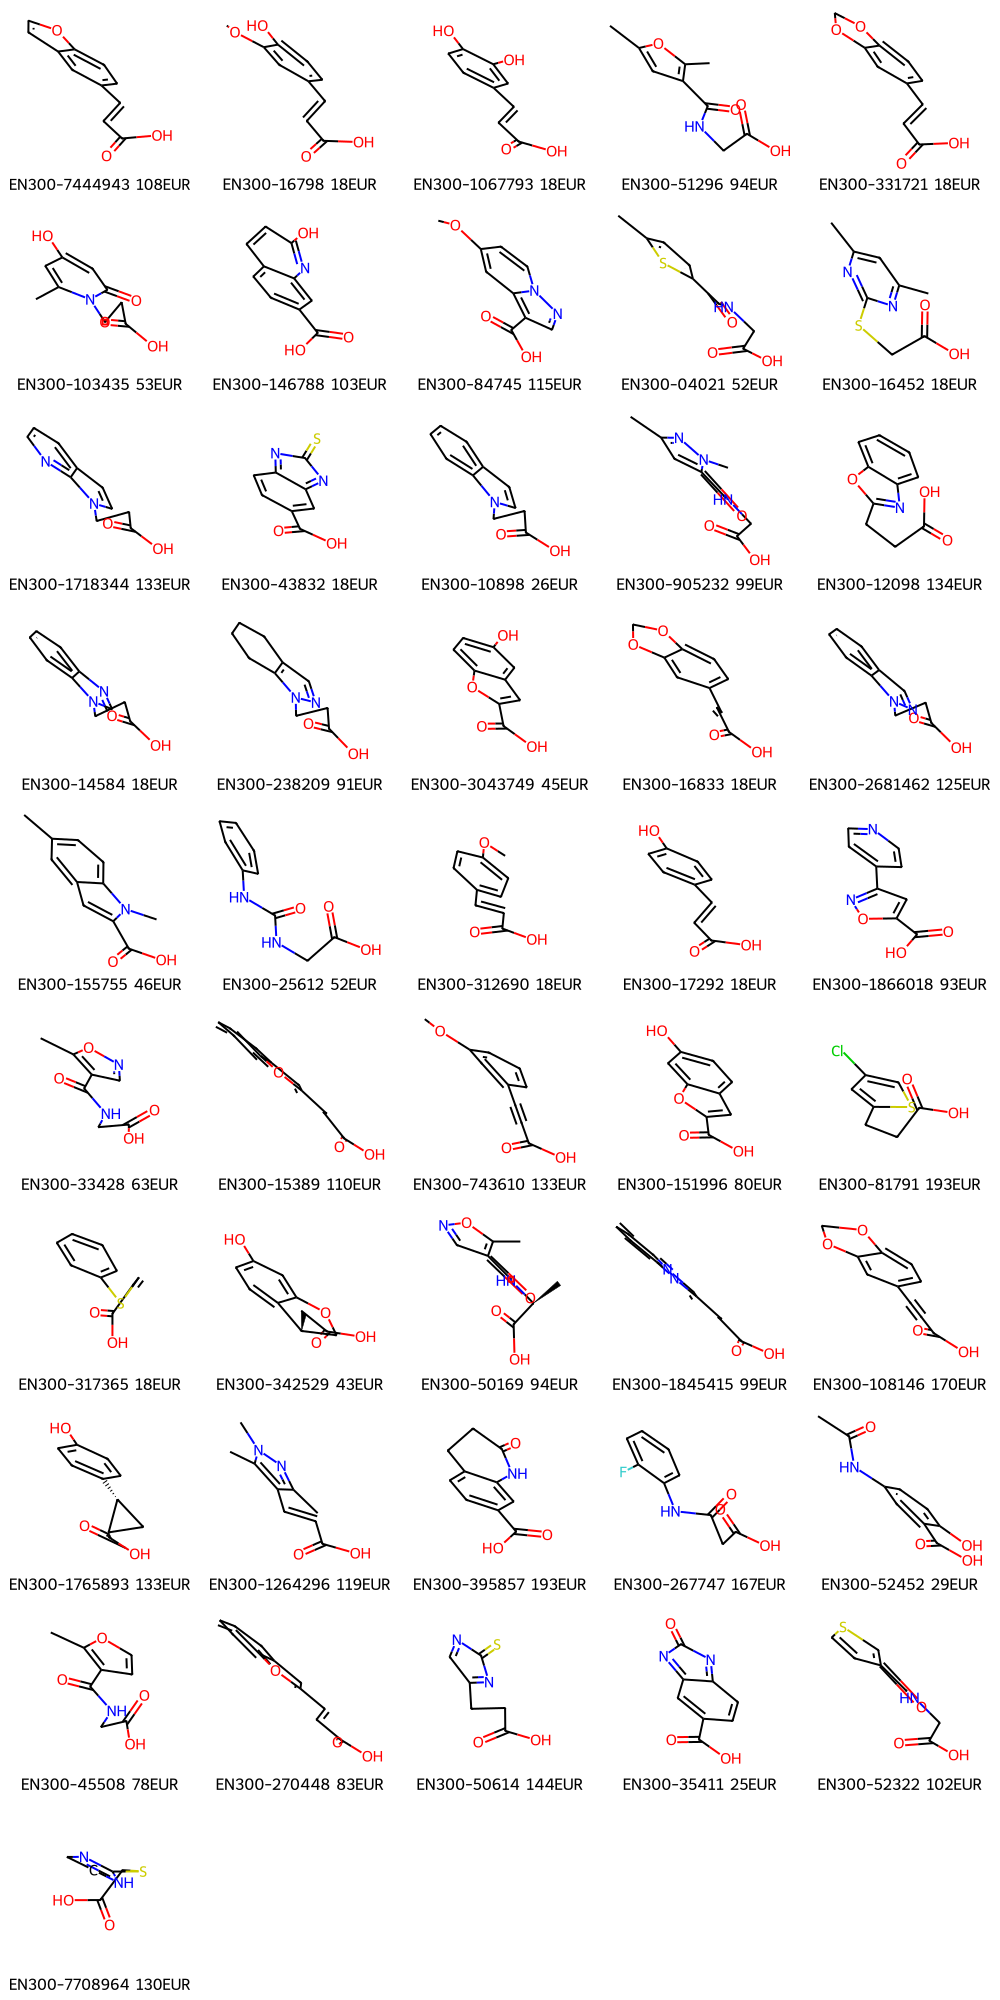

In [425]:
sub = combo.sort_values('Gold.Goldscore.Fitness', ascending=False)
Draw.MolsToGridImage(sub.mol, legends=(sub.code + ' '+sub.Price_EUR_100mg.astype(int).astype(str) +'EUR').to_list(), molsPerRow=5)

In [390]:
sites = {v for vs in combo['Gold.Protein.ActiveResidues'].str.split() for v in vs}
combo

{'ALA86',
 'ALA92',
 'ARG93',
 'ASP39',
 'CYS110',
 'GLN95',
 'GLU106',
 'GLU85',
 'GLU88',
 'GLY108',
 'GLY127',
 'GLY128',
 'GLY133',
 'HIS21',
 'LEU100',
 'LEU131',
 'LEU22',
 'LEU98',
 'PRO107',
 'PRO91',
 'SER105',
 'SER125',
 'SER7',
 'SER87',
 'THR126',
 'TYR89',
 'TYR90',
 'VAL124',
 'VAL84'}

In [411]:
from rdkit import Chem
from rdkit.Chem import AllChem
import networkx as nx
import numpy as np
import numpy.typing as npt
import itertools
from typing import List


def get_edit_distance(mol1: Chem.Mol, mol2: Chem.Mol) -> float:
    """
    Wasteful way to circumvent kekulisation issues.

    .. code::python

      mol1 = Chem.MolFromSmiles('c1ccccc1')
      mol1 = Chem.MolFromSmiles('c1cnccc1')
      mol2 = Chem.MolFromSmiles('C=CC=CC=C')
      print(get_edit_distance(mol1, mol2))
       
    """
    AllChem.SanitizeMol(mol1)
    AllChem.SanitizeMol(mol2)
    graphs1: List[nx.Graph] = [get_graph(res) for res in Chem.ResonanceMolSupplier(mol1, Chem.KEKULE_ALL)]
    graphs2: List[nx.Graph] = [get_graph(res) for res in Chem.ResonanceMolSupplier(mol2, Chem.KEKULE_ALL)]
    return min([nx.graph_edit_distance(g1, g2, edge_match=lambda a,b: a['weight'] == b['weight']) for g1, g2 in itertools.product(graphs1, graphs2)])

def get_graph(mol) -> nx.Graph:
    """
    Variant of https://gist.github.com/jhjensen2/6450138cda3ab796a30850610843cfff

    Returns adjacency matrix with atomic zahl as diagonal.
    """
    am: npt.ArrayLike[np.float64] = Chem.GetAdjacencyMatrix(mol,useBO=True)
    for i,atom in enumerate(mol.GetAtoms()):
        am[i,i] = atom.GetAtomicNum()
    G: nx.Graph = nx.from_numpy_array(am)
    return G

In [455]:
import itertools, random
mols = combo.mol.to_list()
random.shuffle(mols)
#distances = {}

for mol, nol in itertools.combinations(mols, r=2):
    name = mol.GetProp('_Name').split('|')[0]
    nane = nol.GetProp('_Name').split('|')[0]
    if (name, nane) in distances:
        continue
    print((name, nane))
    distances[(name, nane)] = get_edit_distance(mol, nol)
    distances[(nane, name)] = distances[(name, nane)]

('EN300-1866018', 'EN300-52452')
('EN300-1866018', 'EN300-50614')


KeyboardInterrupt: 

In [413]:
distances

{('EN300-7444943', 'EN300-16798'): 3.0,
 ('EN300-16798', 'EN300-7444943'): 3.0,
 ('EN300-7444943', 'EN300-1067793'): 5.0,
 ('EN300-1067793', 'EN300-7444943'): 5.0,
 ('EN300-7444943', 'EN300-51296'): 7.0,
 ('EN300-51296', 'EN300-7444943'): 7.0,
 ('EN300-7444943', 'EN300-331721'): 2.0,
 ('EN300-331721', 'EN300-7444943'): 2.0,
 ('EN300-7444943', 'EN300-103435'): 7.0,
 ('EN300-103435', 'EN300-7444943'): 7.0,
 ('EN300-7444943', 'EN300-146788'): 6.0,
 ('EN300-146788', 'EN300-7444943'): 6.0,
 ('EN300-7444943', 'EN300-84745'): 8.0,
 ('EN300-84745', 'EN300-7444943'): 8.0,
 ('EN300-7444943', 'EN300-04021'): 10.0,
 ('EN300-04021', 'EN300-7444943'): 10.0}

In [408]:
mol.GetProp('_Name').split('|')[0]

'EN300-7444943'

In [393]:
PandasTools.WriteSDF(combo.sort_values('Gold.Goldscore.Fitness', ascending=False),
                     'docked_filtered.sdf',
                     molColName='mol', idName='code',
                    properties=['name', 'comRMSD', 'CN_RMSD', '∆∆G', 'MMFF_score', 'Gold.Goldscore.Fitness','Gold.Goldscore.Internal.Vdw','Gold.Goldscore.Internal.Torsion','Gold.Goldscore.External.Vdw','Gold.Goldscore.Internal.HBond','Gold.Goldscore.External.HBond'])

In [221]:
N = Chem.MolFromSmiles('N')
AllChem.EmbedMolecule(N)
N.GetConformer()

In [313]:
x0487 = [hit for hit in hits if 'x0487' in hit.GetProp('_Name')][0]
x0487.SetProp('_Name', 'x0487')
methylacetamide = Monster([x0487]).place_smiles('CNC(=O)C').positioned_mol
methylamino = AllChem.DeleteSubstructs(methylacetamide, Chem.MolFromSmiles('C(=O)C'))
methylamino.SetProp('_Name', 'methylamino')
AllChem.SanitizeMol(methylamino)

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

['SER7',
 'HIS21',
 'LEU22',
 'ASP39',
 'VAL84',
 'GLU85',
 'ALA86',
 'SER87',
 'GLU88',
 'TYR89',
 'TYR90',
 'PRO91',
 'ALA92',
 'ARG93',
 'GLN95',
 'LEU98',
 'LEU100',
 'SER105',
 'GLU106',
 'PRO107',
 'GLY108',
 'CYS110',
 'VAL124',
 'SER125',
 'THR126',
 'GLY127',
 'GLY128',
 'LEU131',
 'GLY133']

In [315]:
#list(cutting.GetAtomsMatchingQuery(Chem.AtomFromSmarts('[#0]')))[0].GetIdx()

In [316]:
from fragmenstein import Quicktor
Quicktor.work_path = '/tmp/deleteme'
Quicktor.work_path = 'output2'

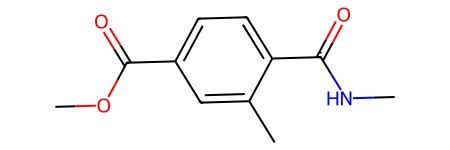

In [317]:
flatto = Chem.Mol( rxd )
flatto.RemoveAllConformers()
flatto

In [318]:
methylamino.GetProp('_Name'), cutting.GetProp('_Name')

('methylamino', 'EN300-268779_decarboxylated')

In [ ]:
from fragmenstein import Wictor, Victor, Igor, Quicktor

Igor.init_pyrosetta()

amido-EN300-268779 - Folder output/amido-EN300-268779 exists.
amido-EN300-268779 - Folder output/amido-EN300-268779 exists.


{'mol': <rdkit.Chem.rdchem.Mol at 0x383d6bf40>,
 'MMFF_score': 59.19401716115682,
 'CN_RMSD': 4.574974782230232,
 'name': 'amido-EN300-268779',
 'smiles': 'CN[C](=O)c1ccc(C(=O)OC)cc1C',
 'error': '',
 'mode': 'expansion',
 '∆∆G': 16.18926035216907,
 '∆G_bound': 460.7159226524155,
 '∆G_unbound': 444.5266623002464,
 'comRMSD': 4.306207540741561,
 'N_constrained_atoms': 13,
 'N_unconstrained_atoms': 2,
 'runtime': 2.1196441650390625,
 'regarded': ['methylamino', 'EN300-268779_decarboxylated'],
 'disregarded': []}

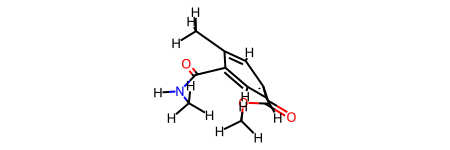

In [335]:
neighborhood = vicky.monster.get_neighborhood(vicky.apo_pdbblock,
                                                             cutoff=vicky.settings['ff_neighborhood'],
                                                             addHs=True)
min_result = vicky.monster.mmff_minimize(vicky.minimized_mol,
                                                    neighborhood=neighborhood,
                                                    ff_max_displacement=float(vicky.settings.get('ff_max_displacement', 0.)),
                                                    ff_constraint=int(vicky.settings.get('ff_constraint', 10)),
                                                    allow_lax=True)
min_result.mol

61.40157566119584

In [298]:
cuttingside_idx, baseside_idx

(11, 14)

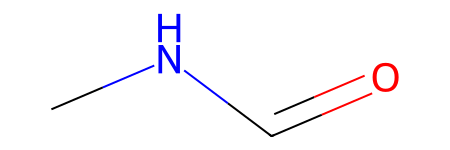

In [289]:
Chem.MolFromSmiles('C(=O)N[CH3]')

In [290]:
list()

In [285]:
help(rxd.GetAtomsMatchingQuery)

Help on method GetAtomsMatchingQuery:

GetAtomsMatchingQuery(...) method of rdkit.Chem.rdchem.Mol instance
    GetAtomsMatchingQuery( (Mol)self, (QueryAtom)qa) -> _ROQAtomSeq :
        Returns a read-only sequence containing all of the atoms in a molecule that match the query atom.
        
    
        C++ signature :
            RDKit::ReadOnlySeq<RDKit::QueryAtomIterator_<RDKit::Atom, RDKit::ROMol>, RDKit::Atom*, RDKit::AtomCountFunctor>* GetAtomsMatchingQuery(boost::shared_ptr<RDKit::ROMol>,RDKit::QueryAtom*)



In [268]:

rxd.GetSubstructMatch( Chem.MolFromSmiles('C(=O)N[CH3:14]') ) #[0]

(11, 12, 13, 14)

In [190]:
mol = Chem.MolFromSmiles('CB(O)O')

In [191]:
from rdkit import ForceField as FF

AllChem.EmbedMolecule(mol)
p: FF.MMFFMolProperties = AllChem.MMFFGetMoleculeProperties(mol, 'MMFF94')
ff = AllChem.MMFFGetMoleculeForceField(mol, p)
ff,

(None,)

In [ ]:


with Chem.SDWriter('not-pocket.sdf') as sdfh:
    for hit in fluff:
        sdfh.write(hit)
        
len(fluff)


df.mol

In [79]:
PandasTools.WriteSDF(df.sort_values('Gold.Goldscore.Fitness', ascending=False).head(1000),
                     'docked_filtered.sdf',
                     molColName='mol', idName
                     allNumeric=True)

Help on function WriteSDF in module rdkit.Chem.PandasTools:

WriteSDF(df, out, molColName='ROMol', idName=None, properties=None, allNumeric=False, forceV3000=False)
    Write an SD file for the molecules in the dataframe. Dataframe columns can be exported as
    SDF tags if specified in the "properties" list. "properties=list(df.columns)" would export
    all columns.
    The "allNumeric" flag allows to automatically include all numeric columns in the output.
    User has to make sure that correct data type is assigned to column.
    "idName" can be used to select a column to serve as molecule title. It can be set to
    "RowID" to use the dataframe row key as title.



In [ ]:
x0451S1